**Collin Gonzalez - A00382429**

**Juan Ramirez -**

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Análisis Exploratorio de Datos - Sistema de Anotación de Video

Ahora que tenemos los datos en un mismo dataset por coordenadas hacemos el EDA

In [30]:
df = pd.read_csv('../../db/poses_dataset.csv')
print(df.head())

         x0        y0        z0        x1        y1        z1        x2  \
0  0.529586  0.225994 -0.544099  0.545759  0.207719 -0.520949  0.558619   
1  0.514749  0.214820 -0.424005  0.531973  0.196832 -0.400889  0.542074   
2  0.512379  0.213049 -0.479321  0.530193  0.195311 -0.454911  0.541729   
3  0.513686  0.215705 -0.464948  0.530943  0.198360 -0.442846  0.540564   
4  0.511391  0.214577 -0.427555  0.527089  0.197664 -0.406394  0.535601   

         y2        z2        x3  ...       y30       z30       x31       y31  \
0  0.207437 -0.521142  0.569026  ...  0.794852  0.416390  0.585441  0.833516   
1  0.196426 -0.400960  0.550751  ...  0.782368  0.660540  0.579761  0.832633   
2  0.194692 -0.455039  0.550316  ...  0.789381  0.618580  0.571212  0.840754   
3  0.197792 -0.442872  0.548828  ...  0.784287  0.572390  0.574309  0.832000   
4  0.197398 -0.406407  0.544256  ...  0.786348  0.548257  0.575098  0.831336   

        z31       x32       y32       z32   action  source_video  
0

In [31]:
print("Dimensiones del dataset:", df.shape)
print("\nInformación del dataset:")
display(df.info())

Dimensiones del dataset: (11299, 101)

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11299 entries, 0 to 11298
Columns: 101 entries, x0 to source_video
dtypes: float64(99), object(2)
memory usage: 8.7+ MB


None

**Limpiar datos**

In [32]:
#valores faltantes
print(df.isnull().sum())

x0              0
y0              0
z0              0
x1              0
y1              0
               ..
x32             0
y32             0
z32             0
action          0
source_video    0
Length: 101, dtype: int64


No tenemos valores nulos

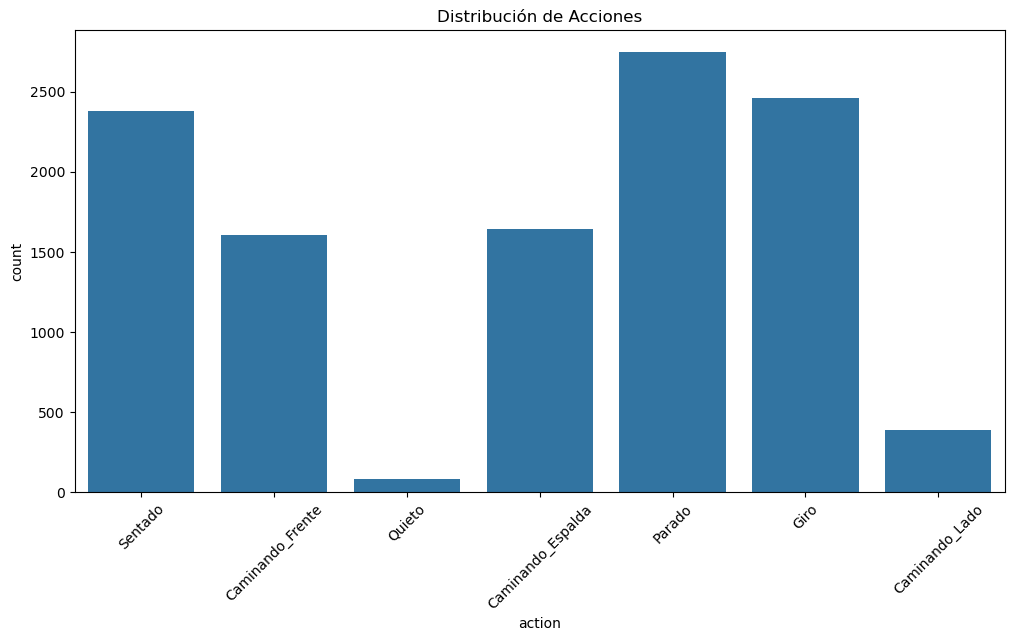

In [33]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='action')
plt.xticks(rotation=45)
plt.title('Distribución de Acciones')
plt.show()

**Outliers**

En este paso vamos a visualizar la distribución de las coordenadas (x, y, z) de los landmarks y su relación con cada tipo de acción mediante boxplots.

Para esto, primero separamos las coordenadas por tipo (x, y, z) y luego creamos una función plot_boxplots_by_groups que nos permite visualizar los datos en grupos de 9 gráficos (3x3) para mantener una visualización clara y legible.

Cada boxplot muestra la distribución de una coordenada específica para cada tipo de acción, lo que nos permite identificar patrones y posibles outliers en los datos.

Los gráficos se organizan por grupos y se muestran con un tamaño adecuado (20x15) para facilitar la visualización, con etiquetas rotadas a 45 grados para mejorar la legibilidad. Esta visualización es crucial para entender cómo varían las posiciones de los landmarks según la acción realizada y para identificar posibles anomalías en los datos antes de proceder con el entrenamiento del modelo.

In [34]:
# Separar coordenadas por tipo (x, y, z)
x_coords = [col for col in df.columns if col.startswith('x')]
y_coords = [col for col in df.columns if col.startswith('y')]
z_coords = [col for col in df.columns if col.startswith('z')]

# Función para mostrar boxplots en grupos de 9
def plot_boxplots_by_groups(coords, df, title_prefix, n_cols=3):
    n_plots = len(coords)
    n_rows = (n_plots + n_cols - 1) // n_cols  # Redondear hacia arriba

    for start_idx in range(0, n_plots, 9):
        plt.figure(figsize=(20, 15))
        coords_subset = coords[start_idx:start_idx + 9]

        for i, column in enumerate(coords_subset, 1):
            plt.subplot(3, 3, i)
            sns.boxplot(y=df[column], x=df['action'], width=0.5)
            plt.title(f'{column}', fontsize=10)
            plt.xticks(rotation=45, fontsize=8)
            plt.yticks(fontsize=8)

        plt.suptitle(f'{title_prefix} (Grupo {start_idx//9 + 1})', y=1.02, fontsize=14)
        plt.tight_layout()
        plt.show()

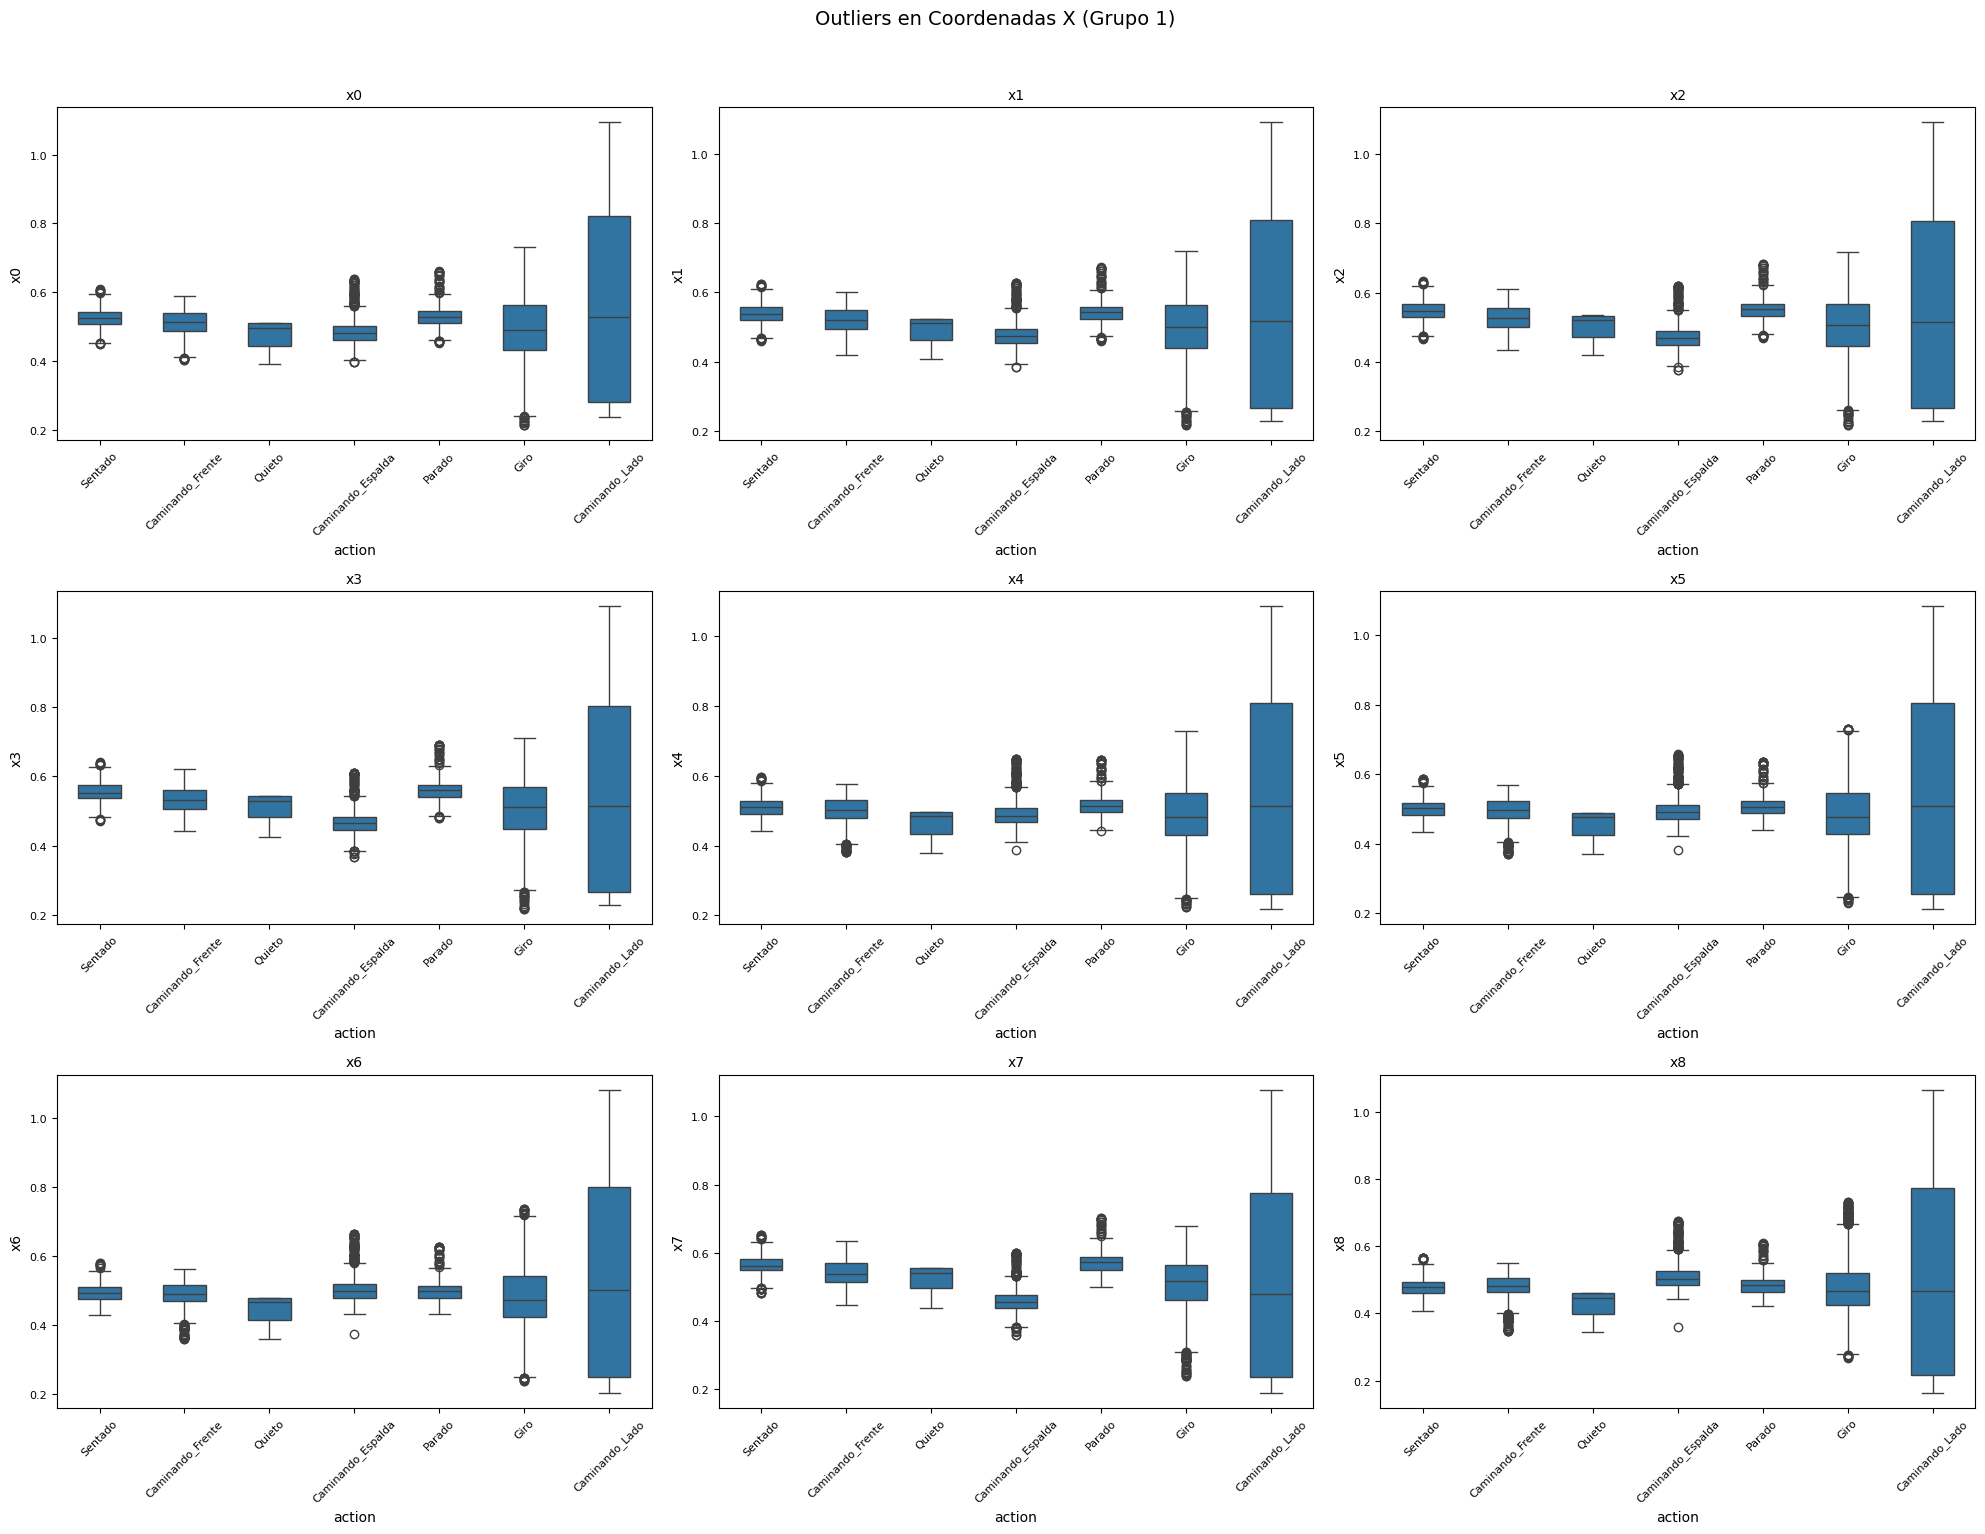

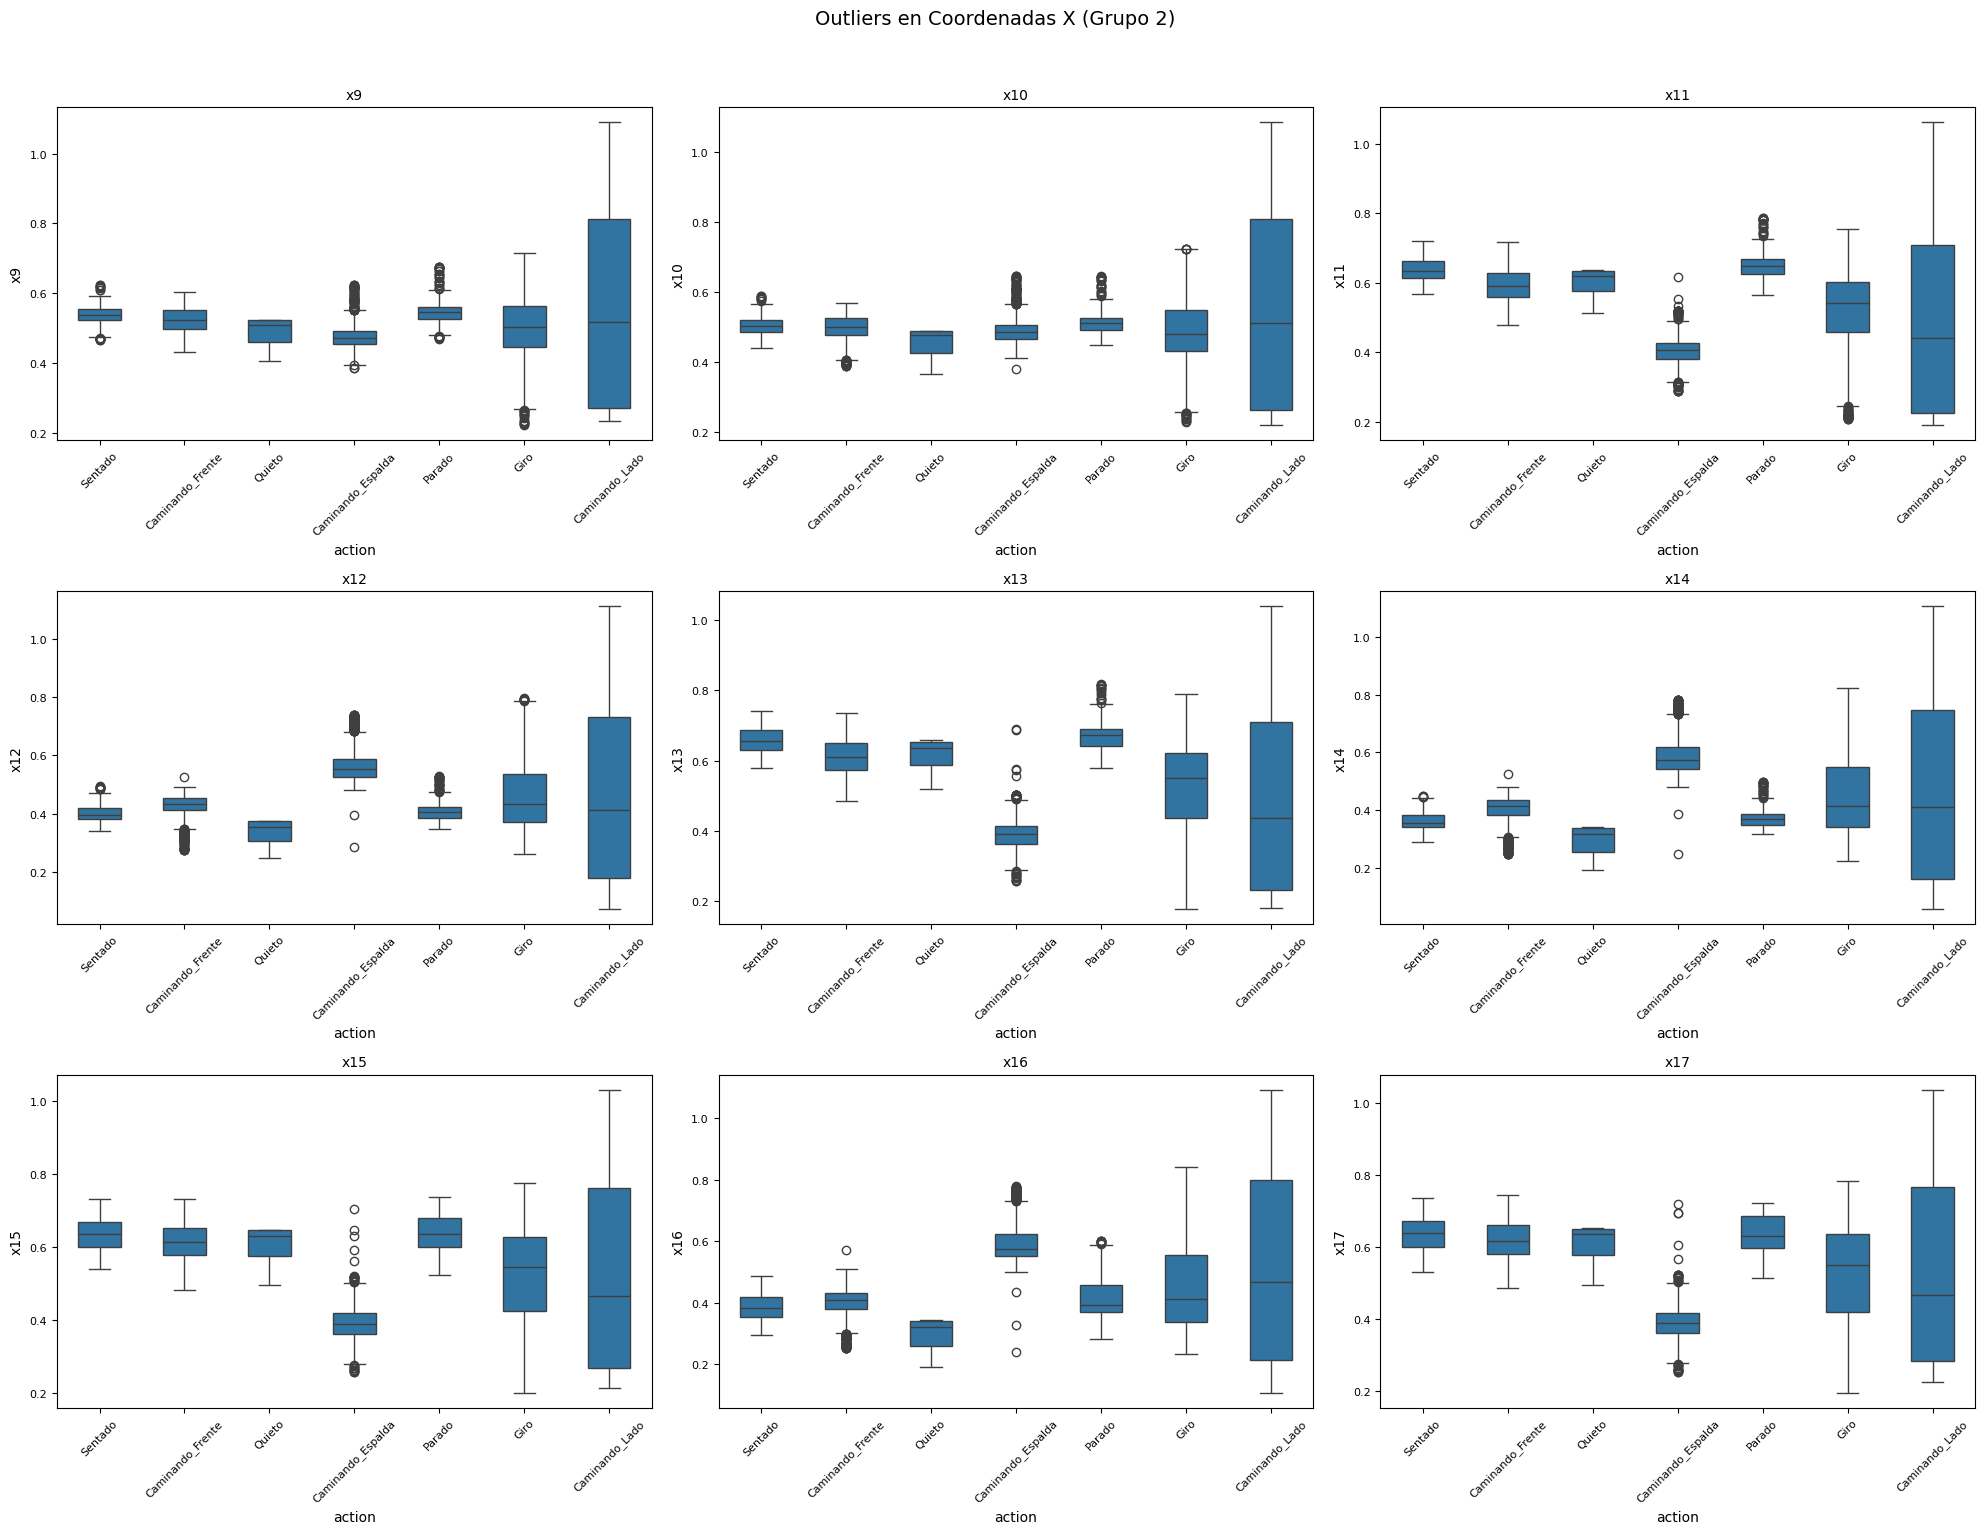

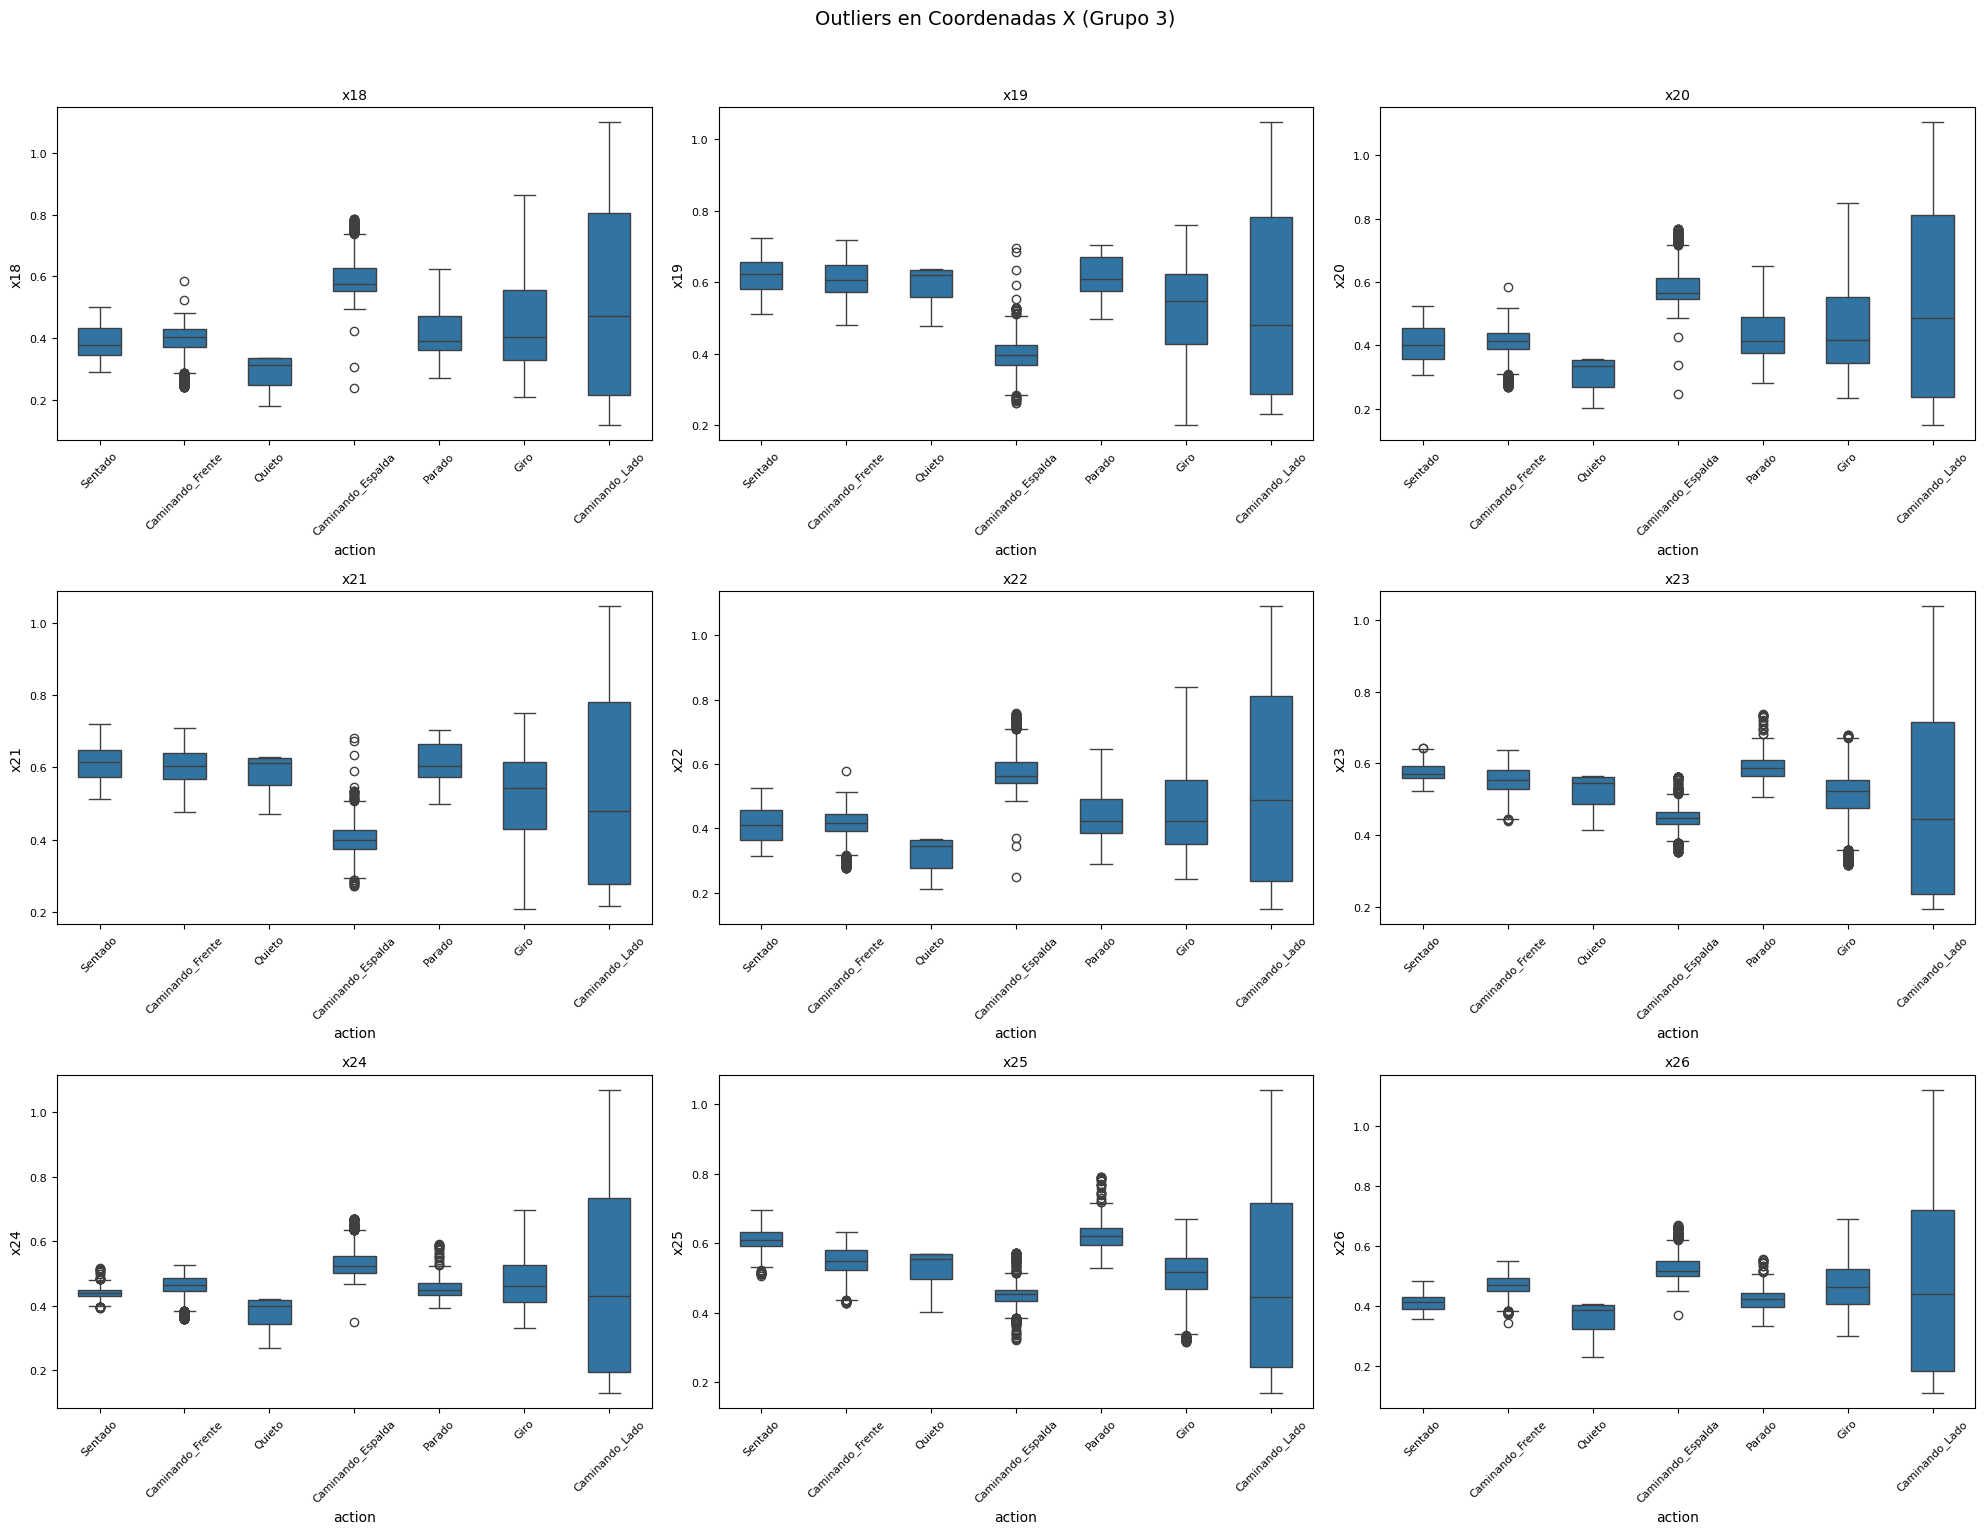

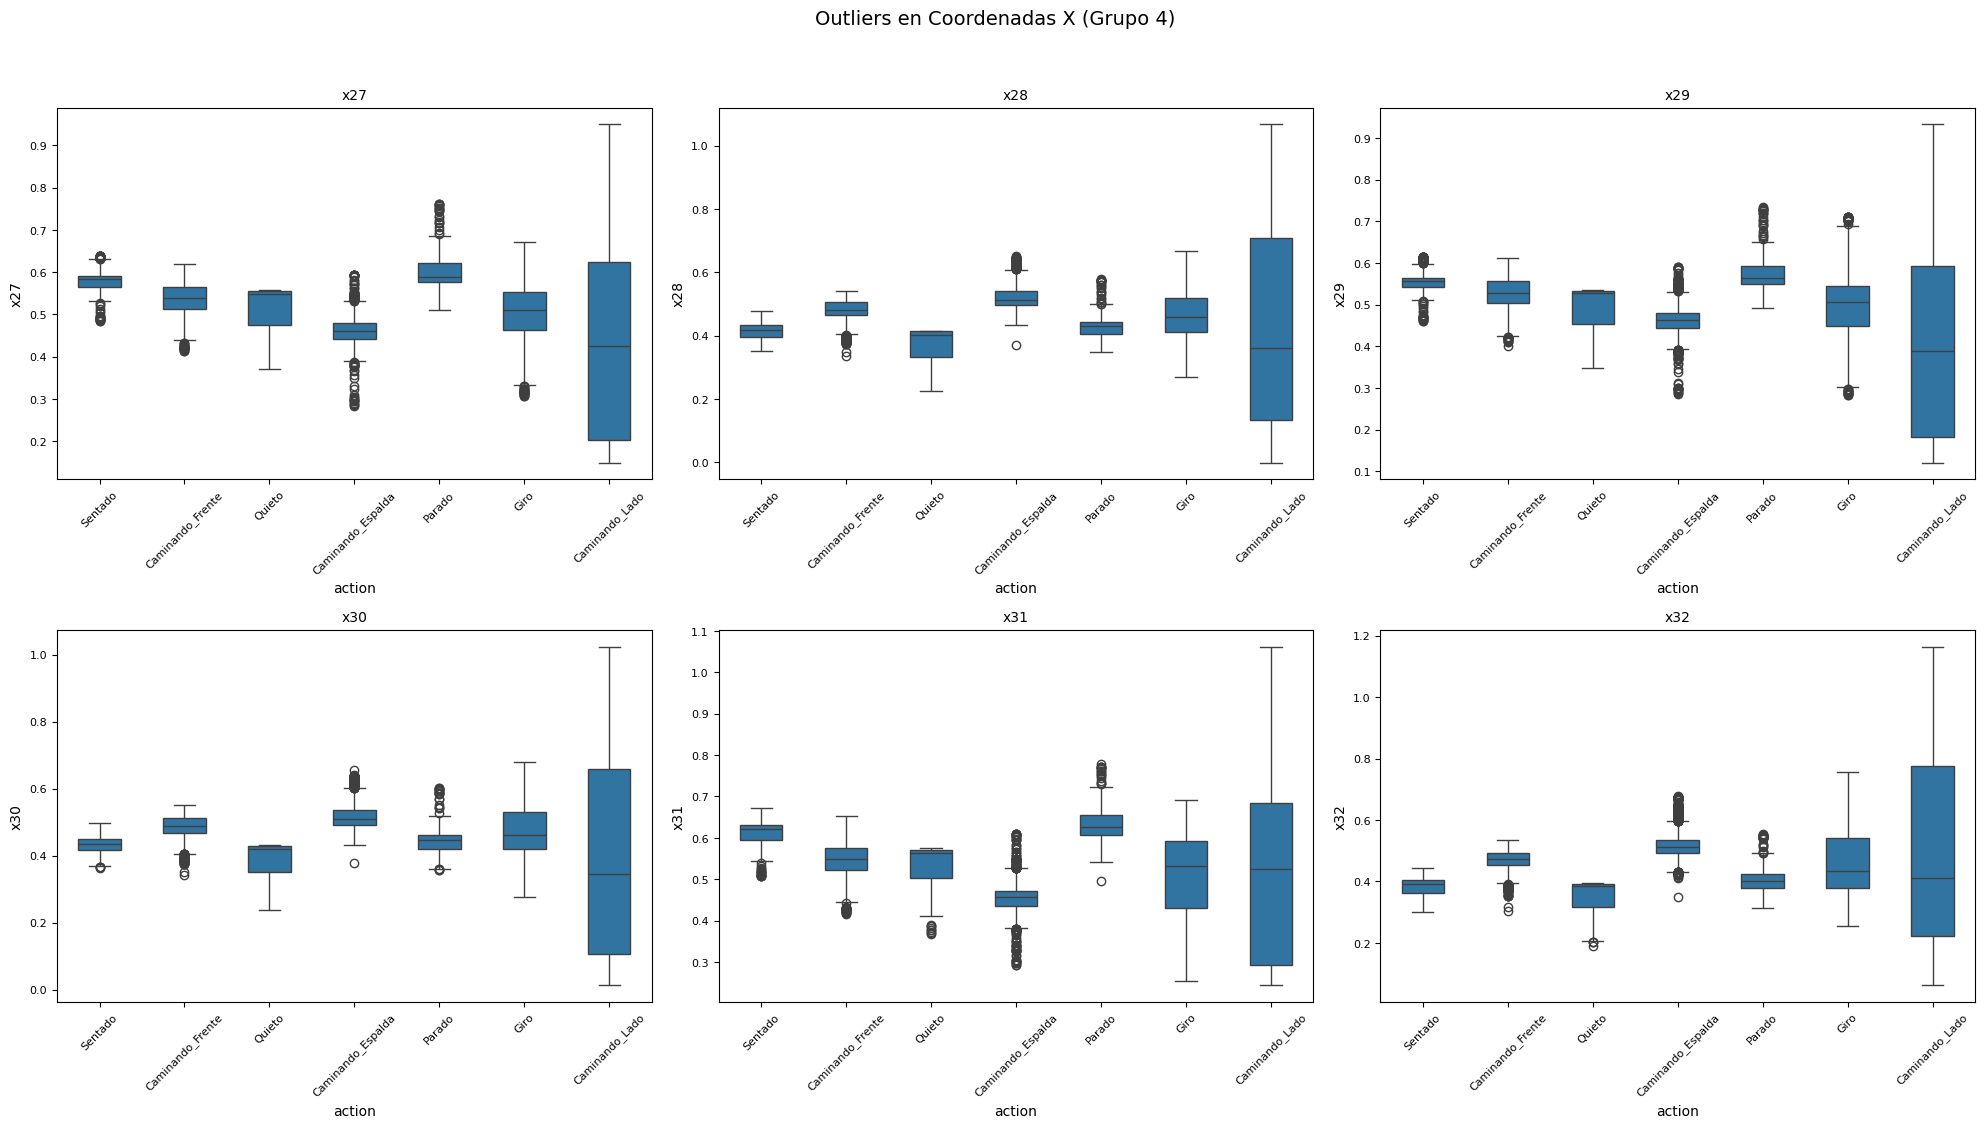

In [35]:
plot_boxplots_by_groups(x_coords, df, 'Outliers en Coordenadas X')

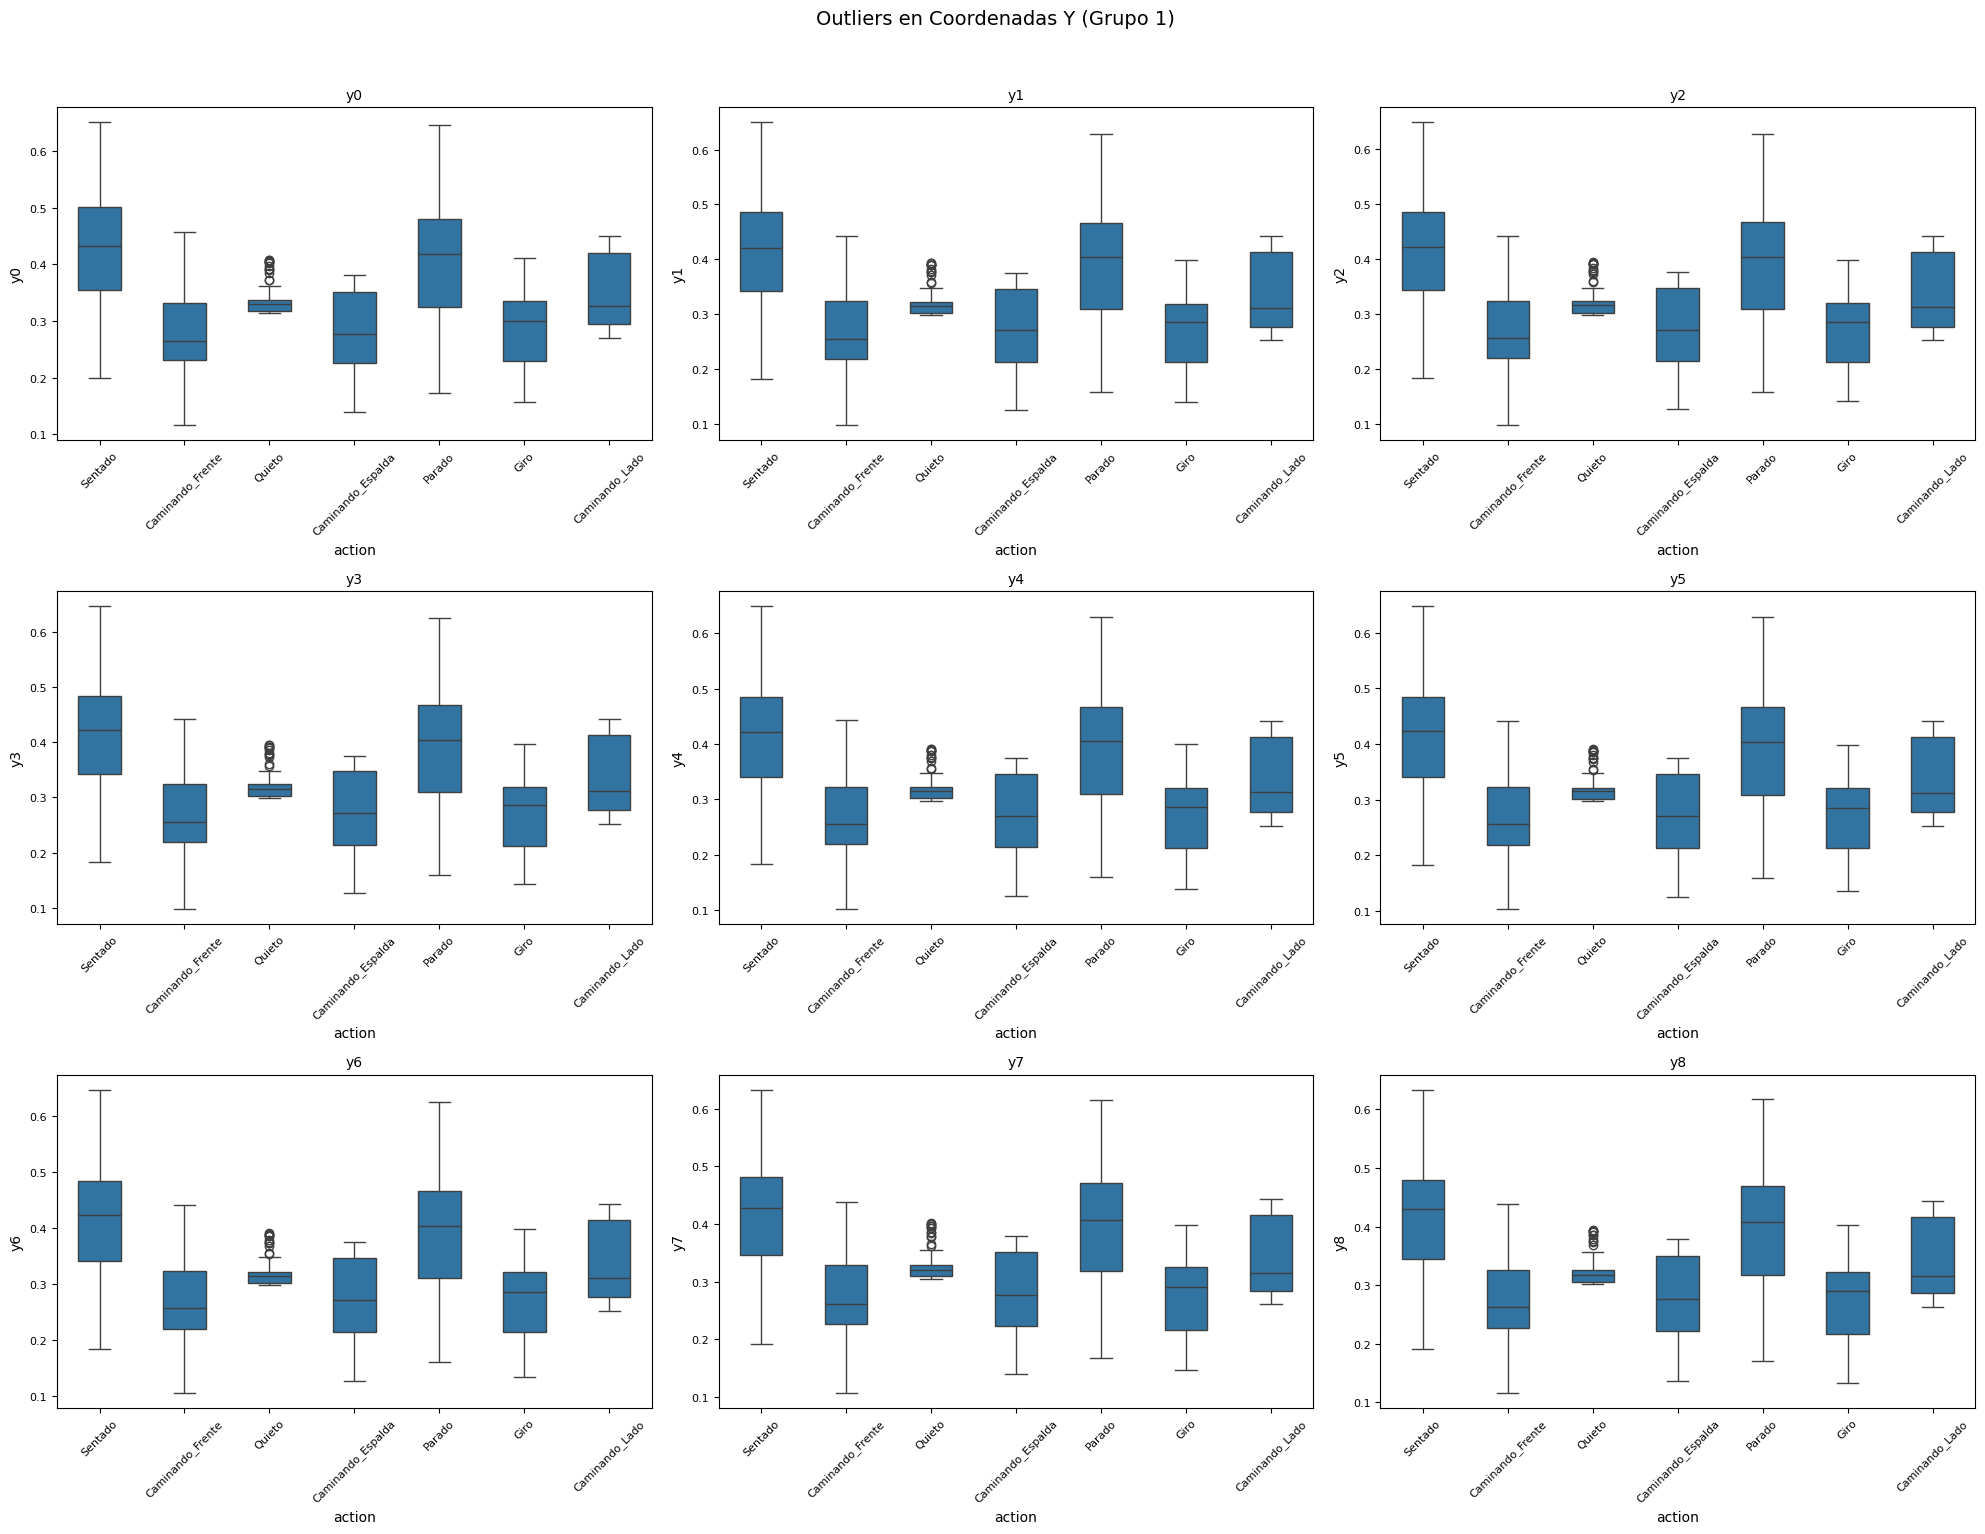

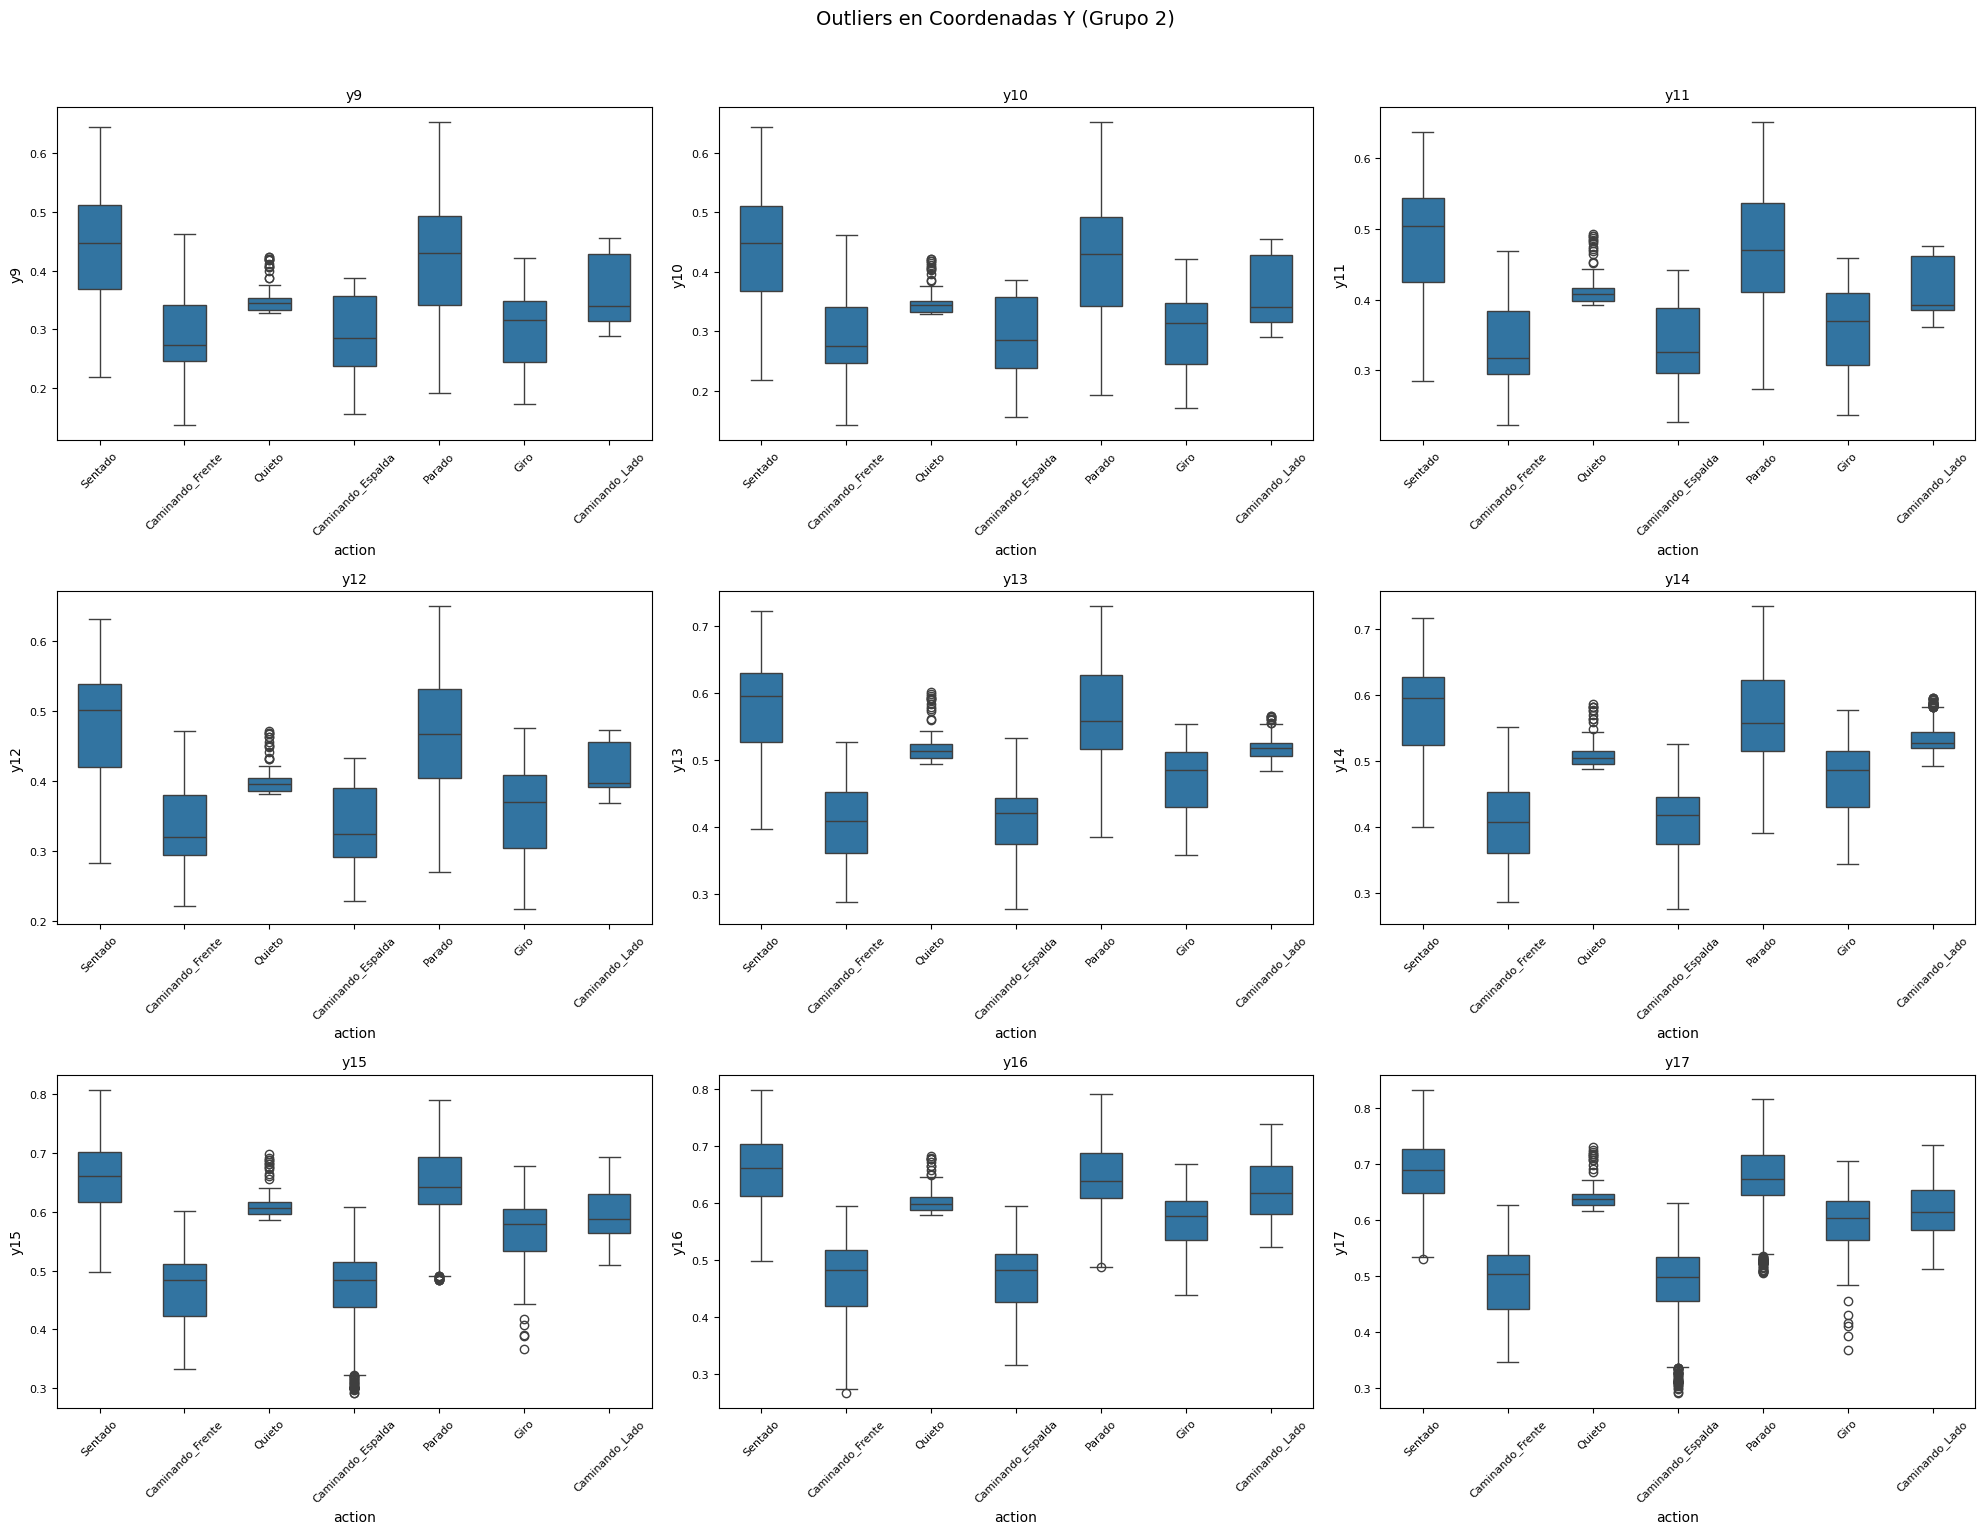

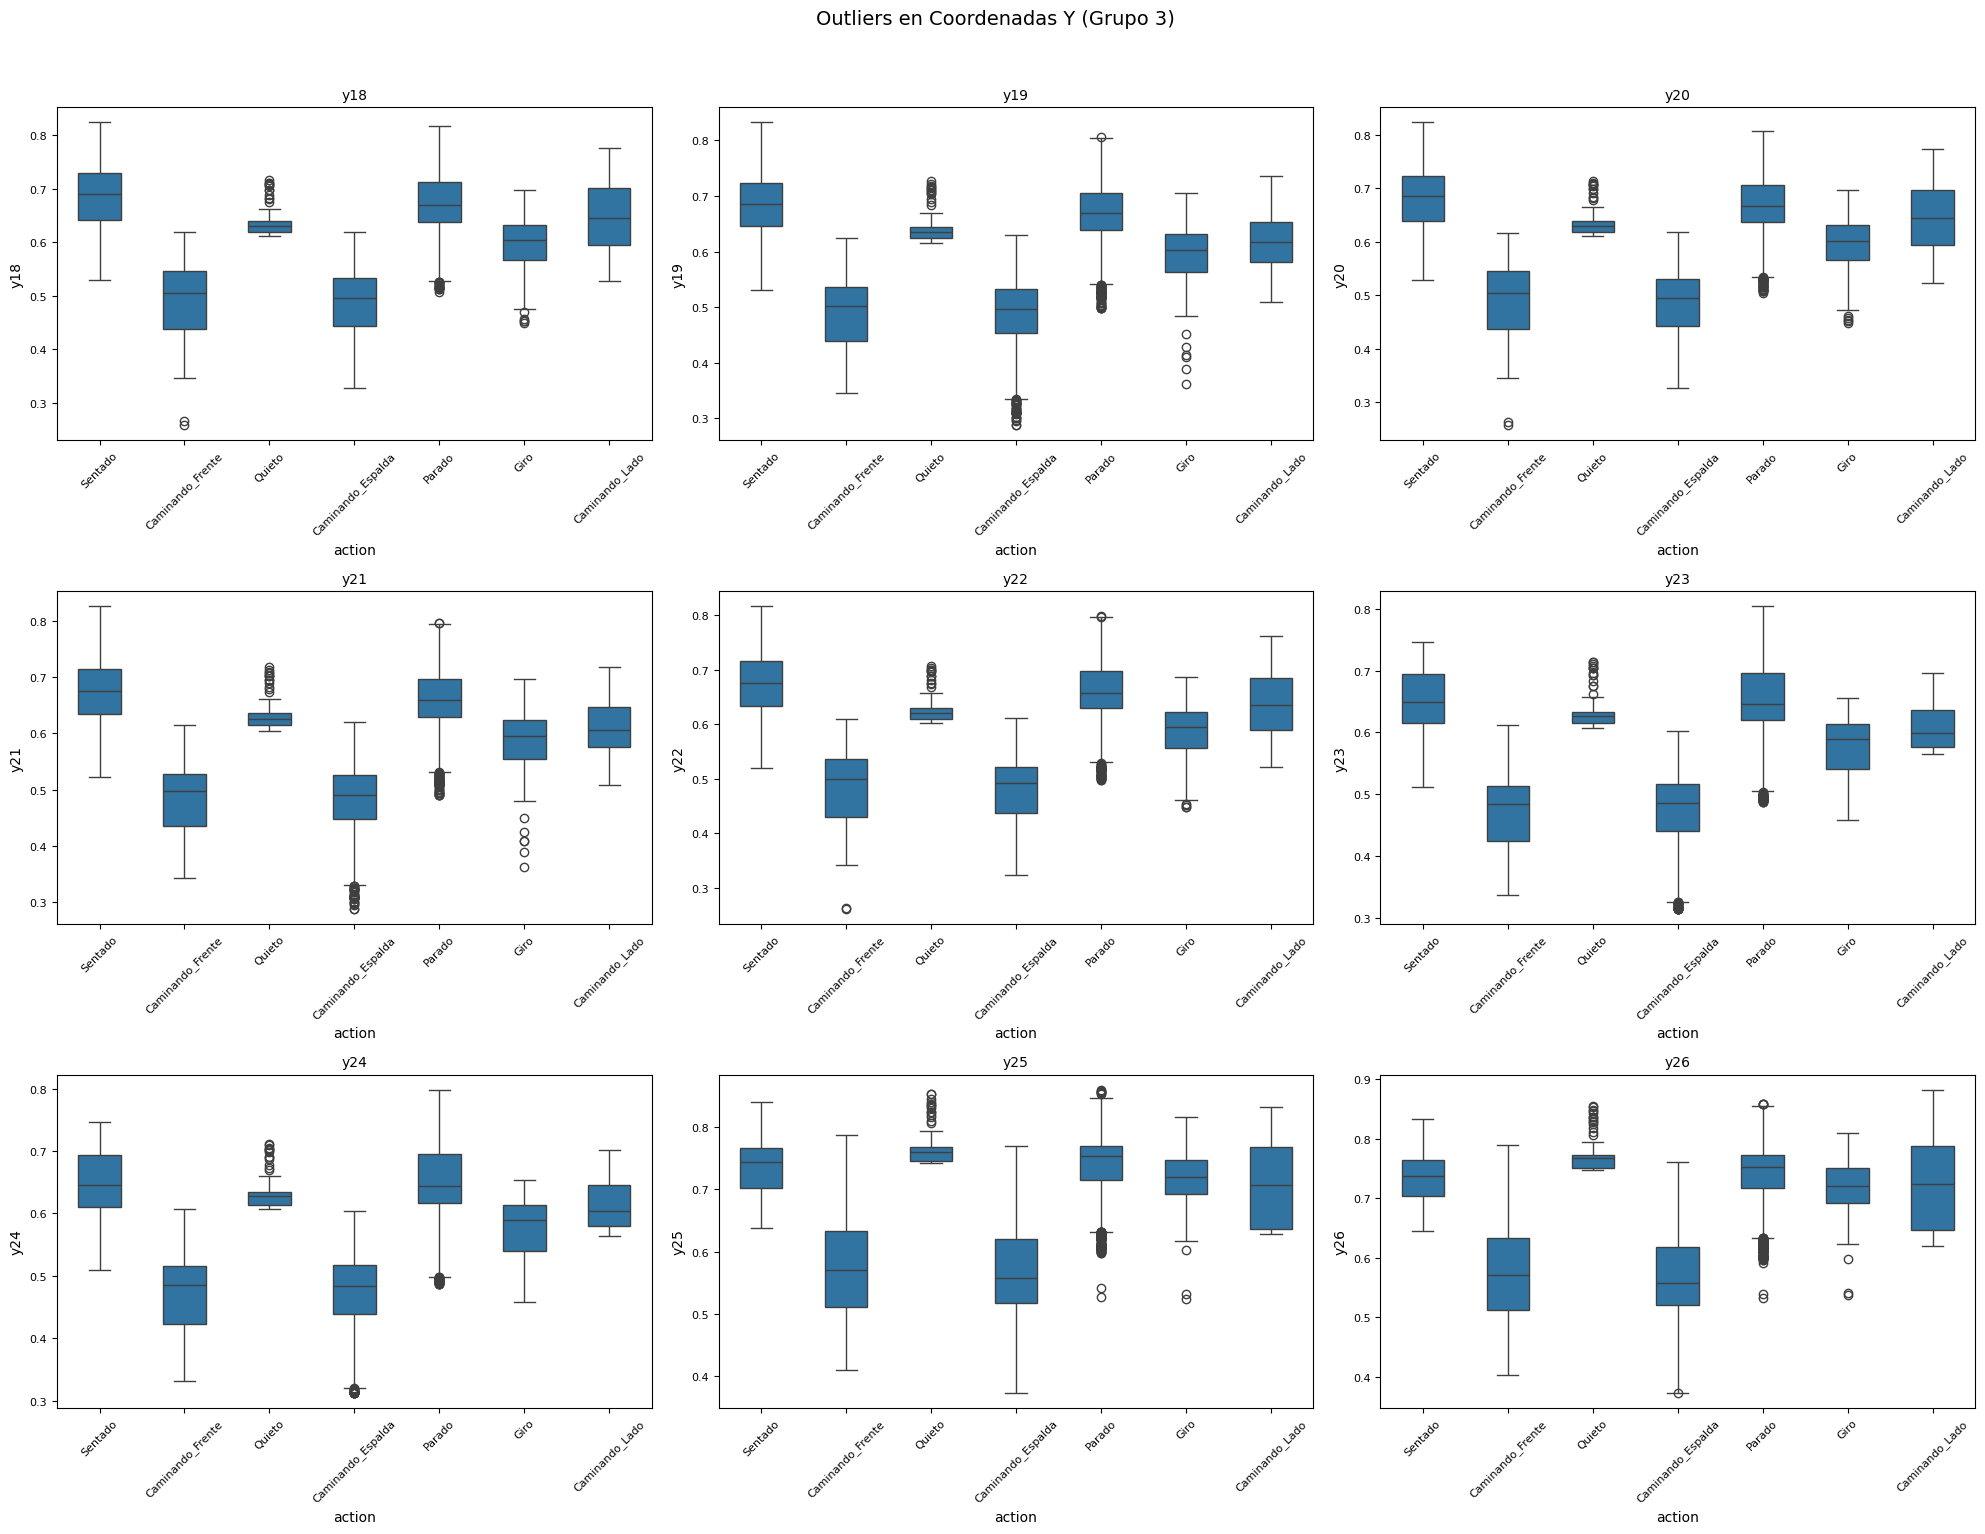

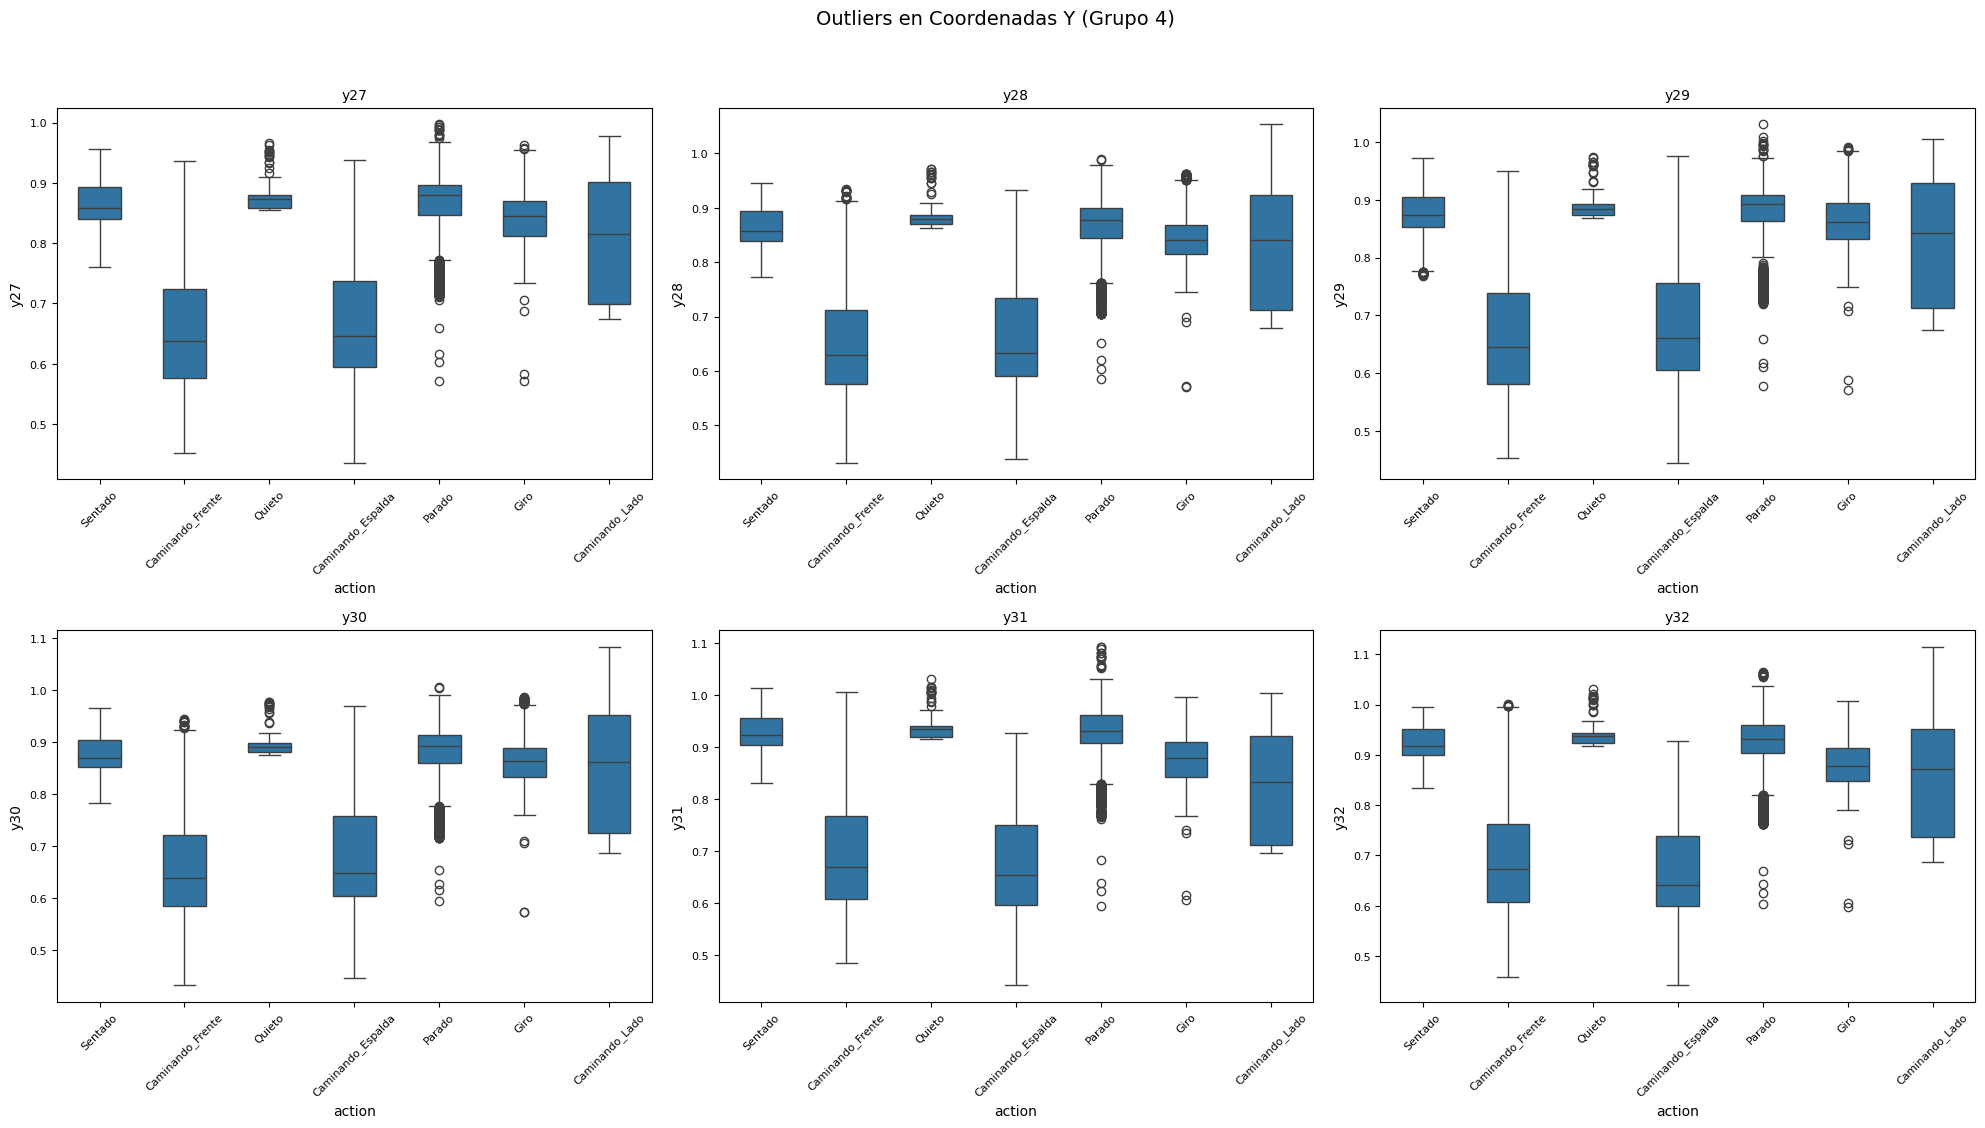

In [36]:
plot_boxplots_by_groups(y_coords, df, 'Outliers en Coordenadas Y')

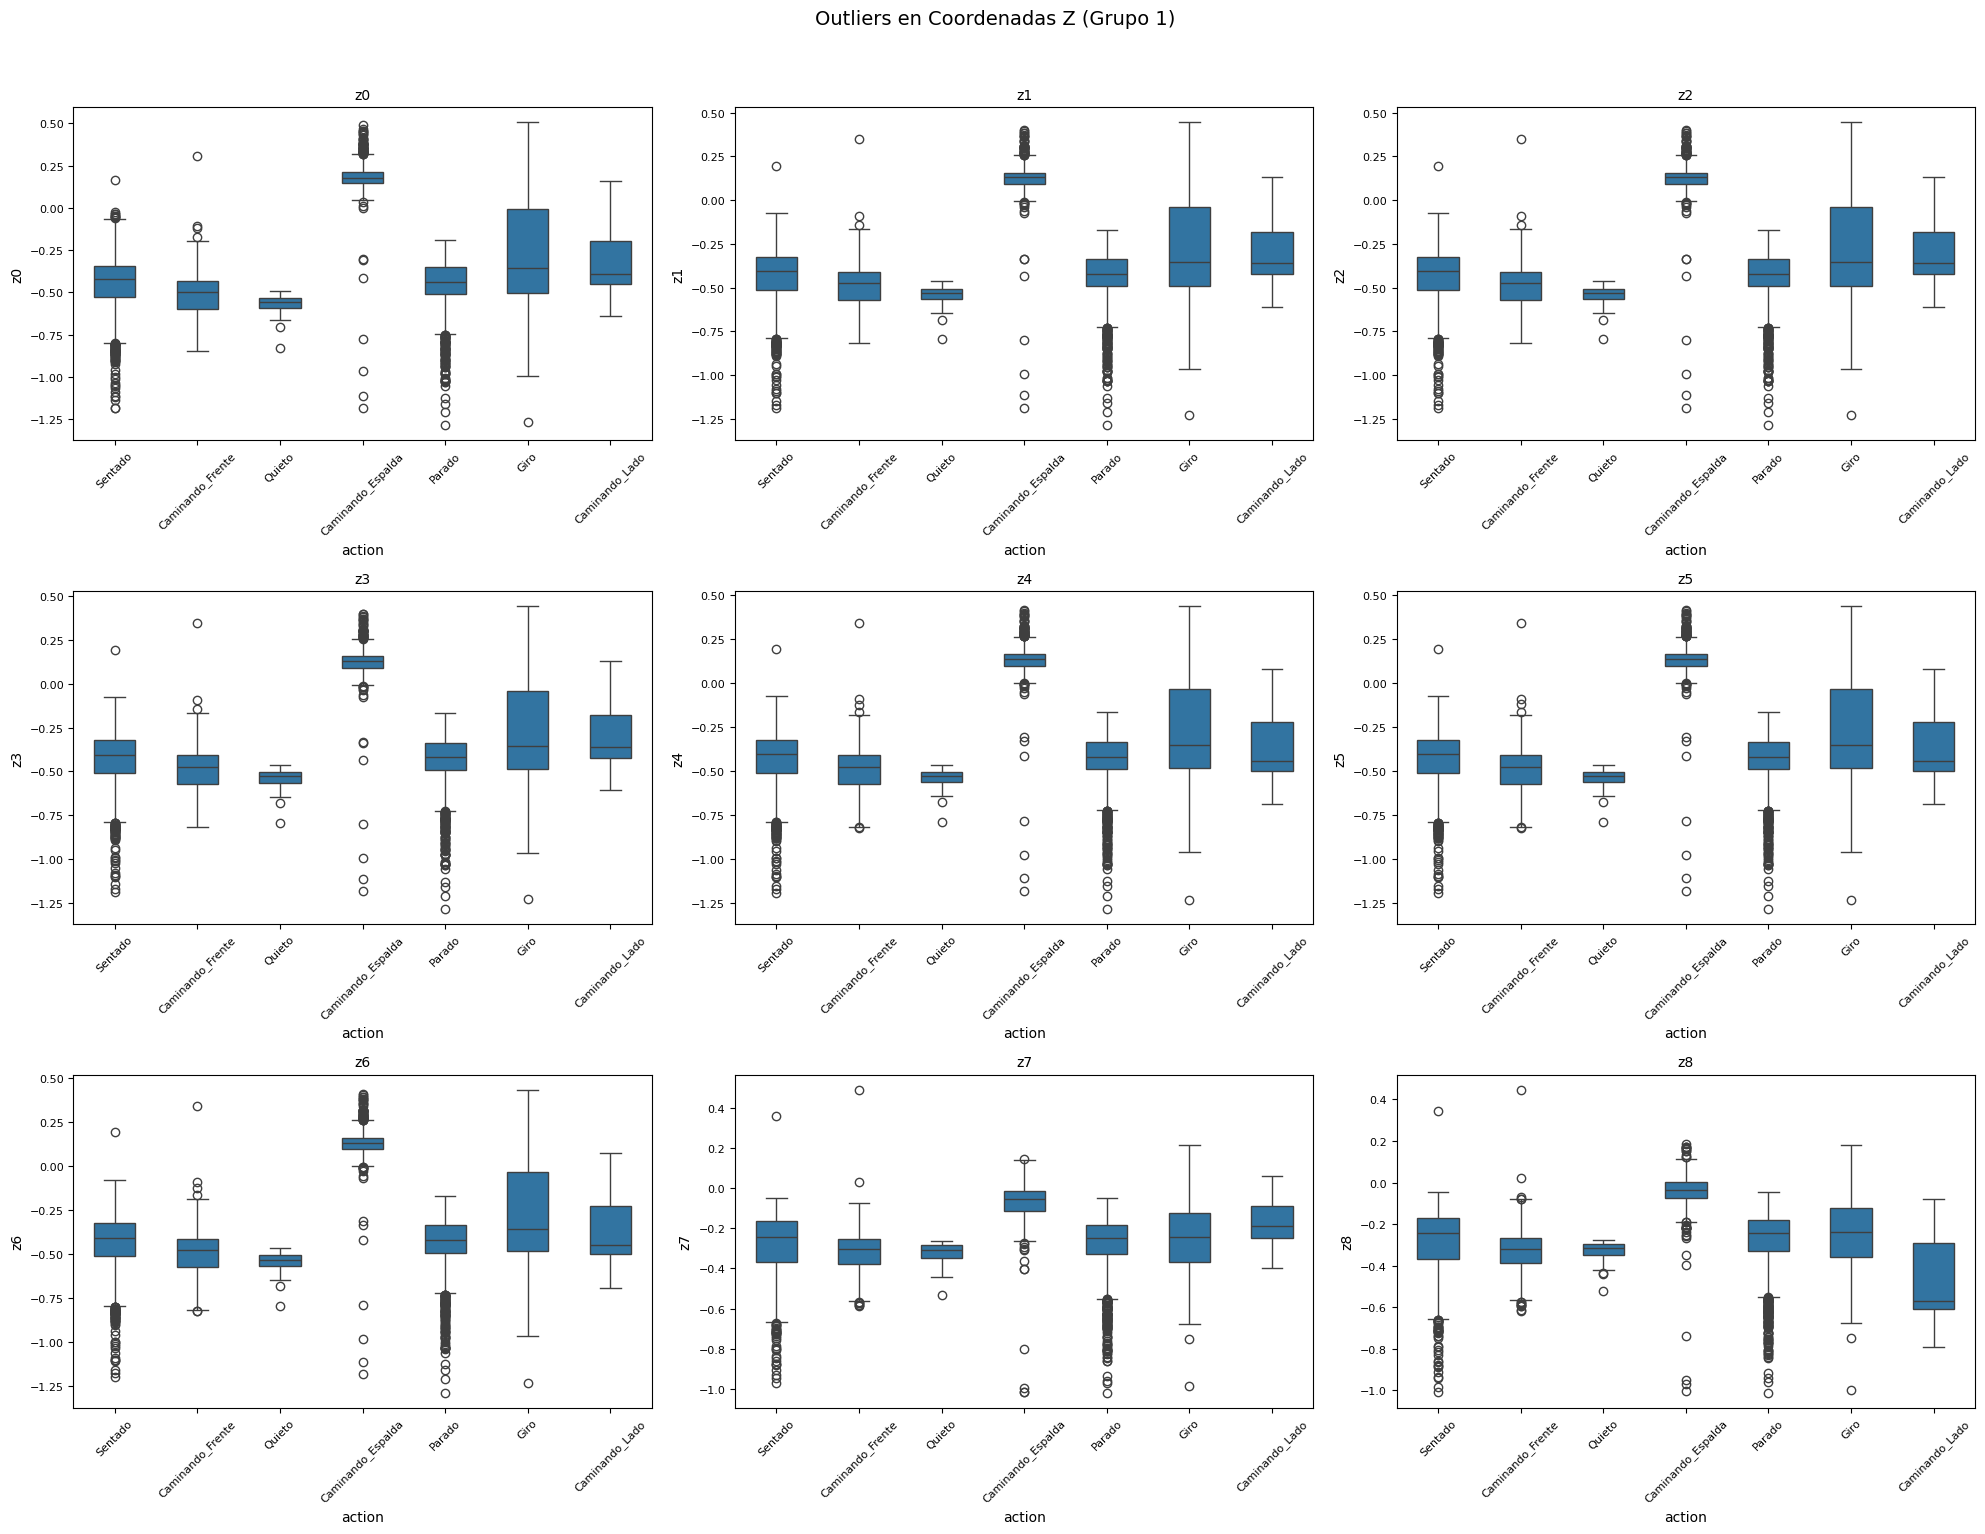

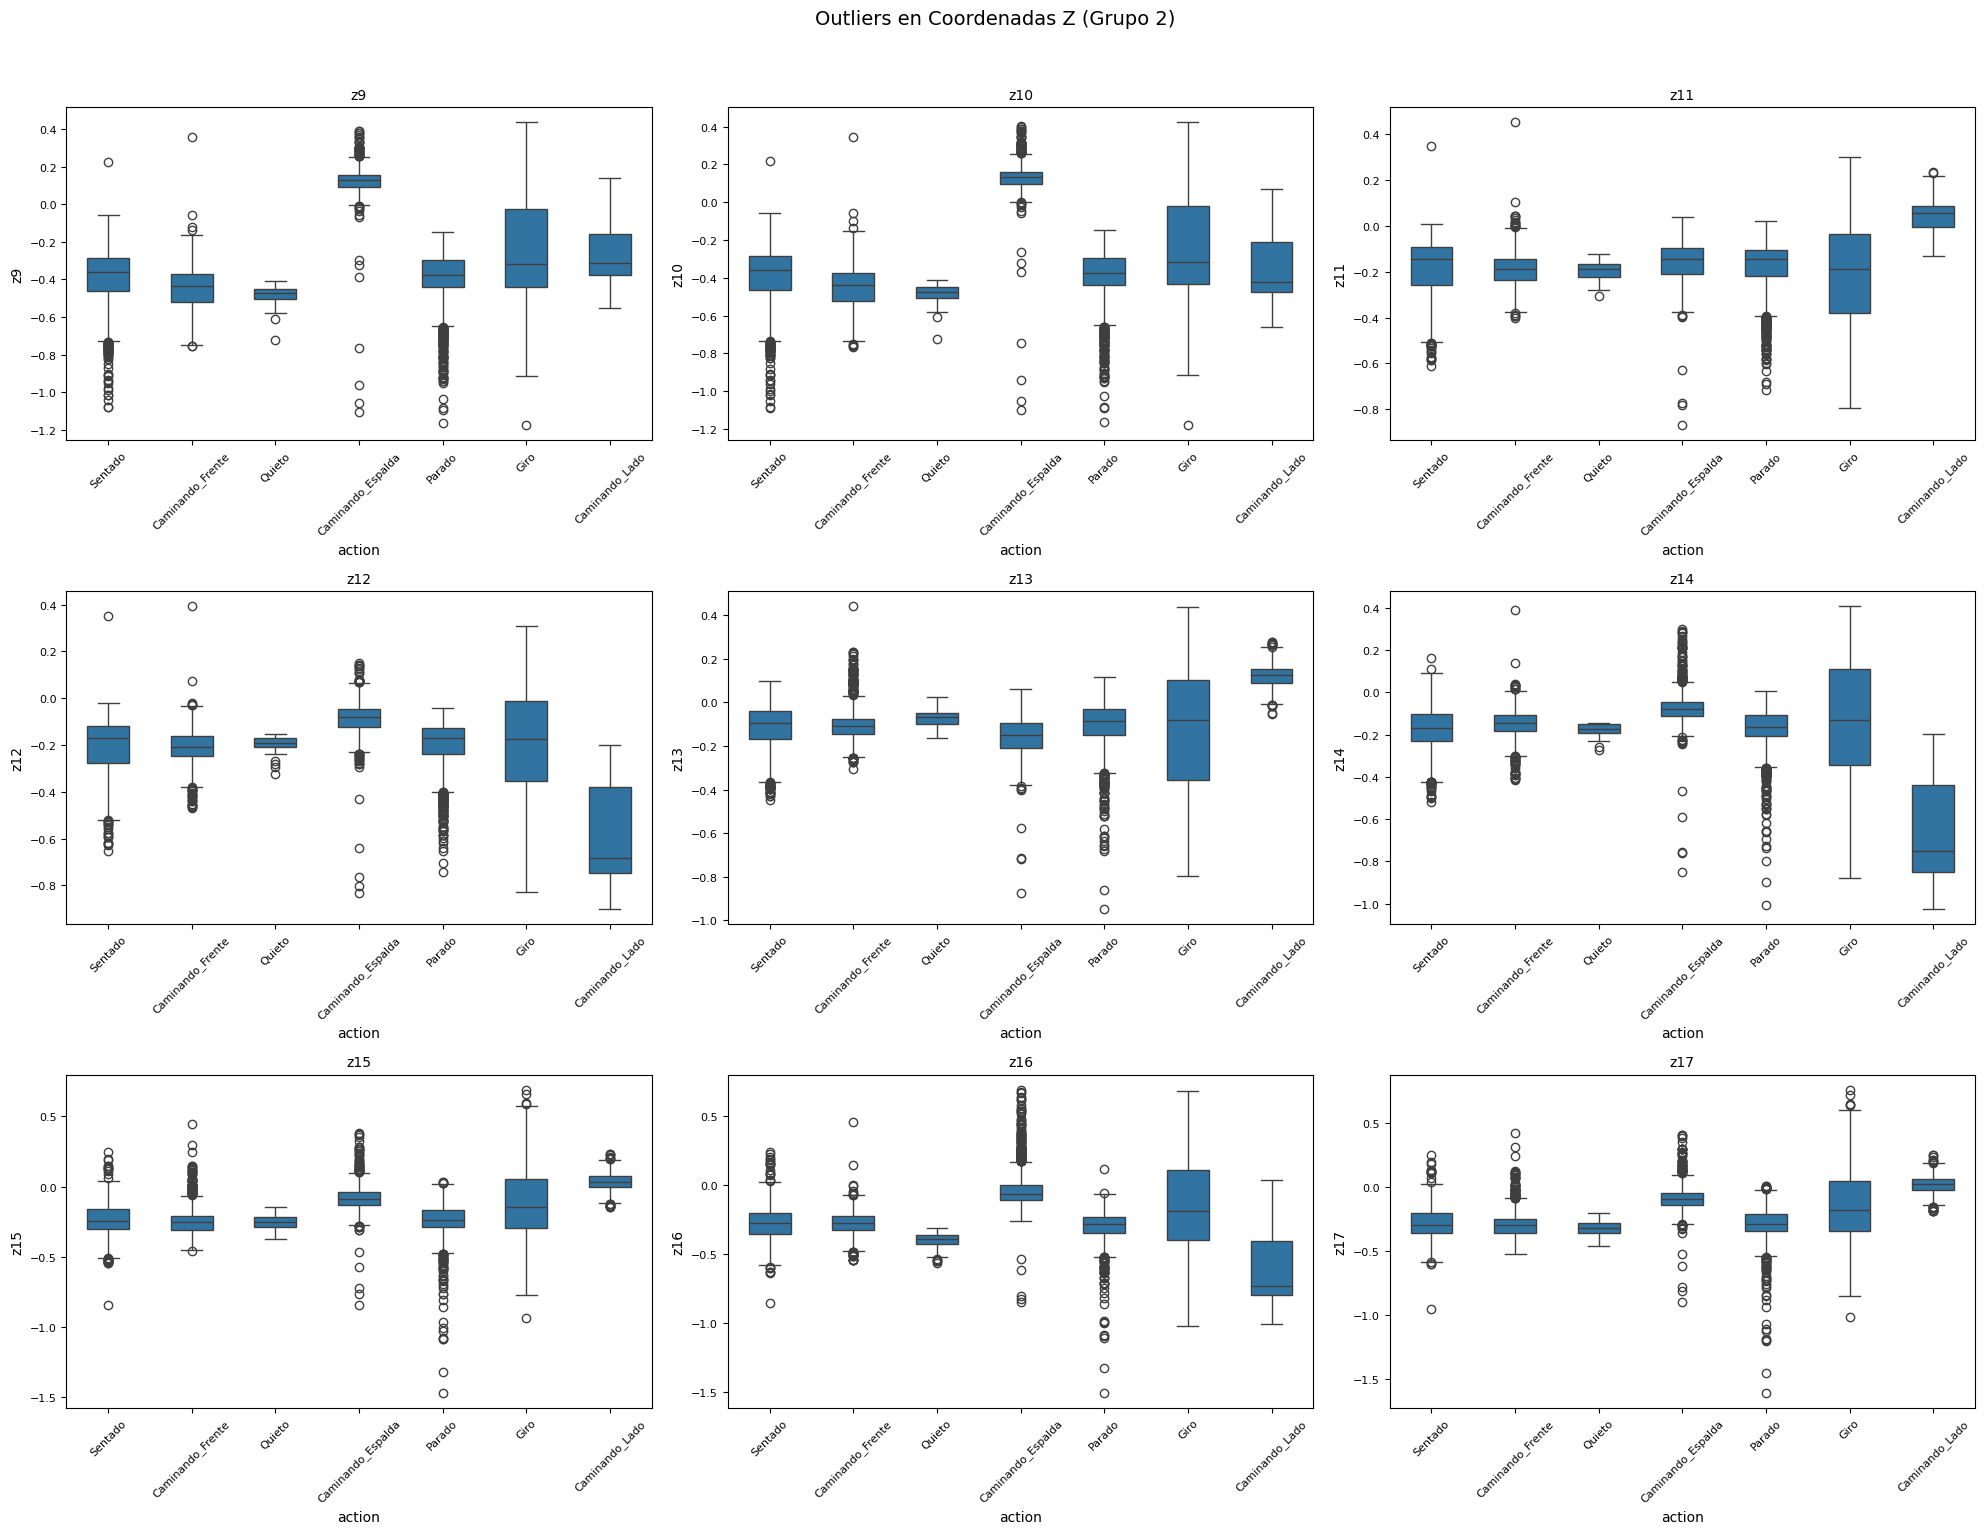

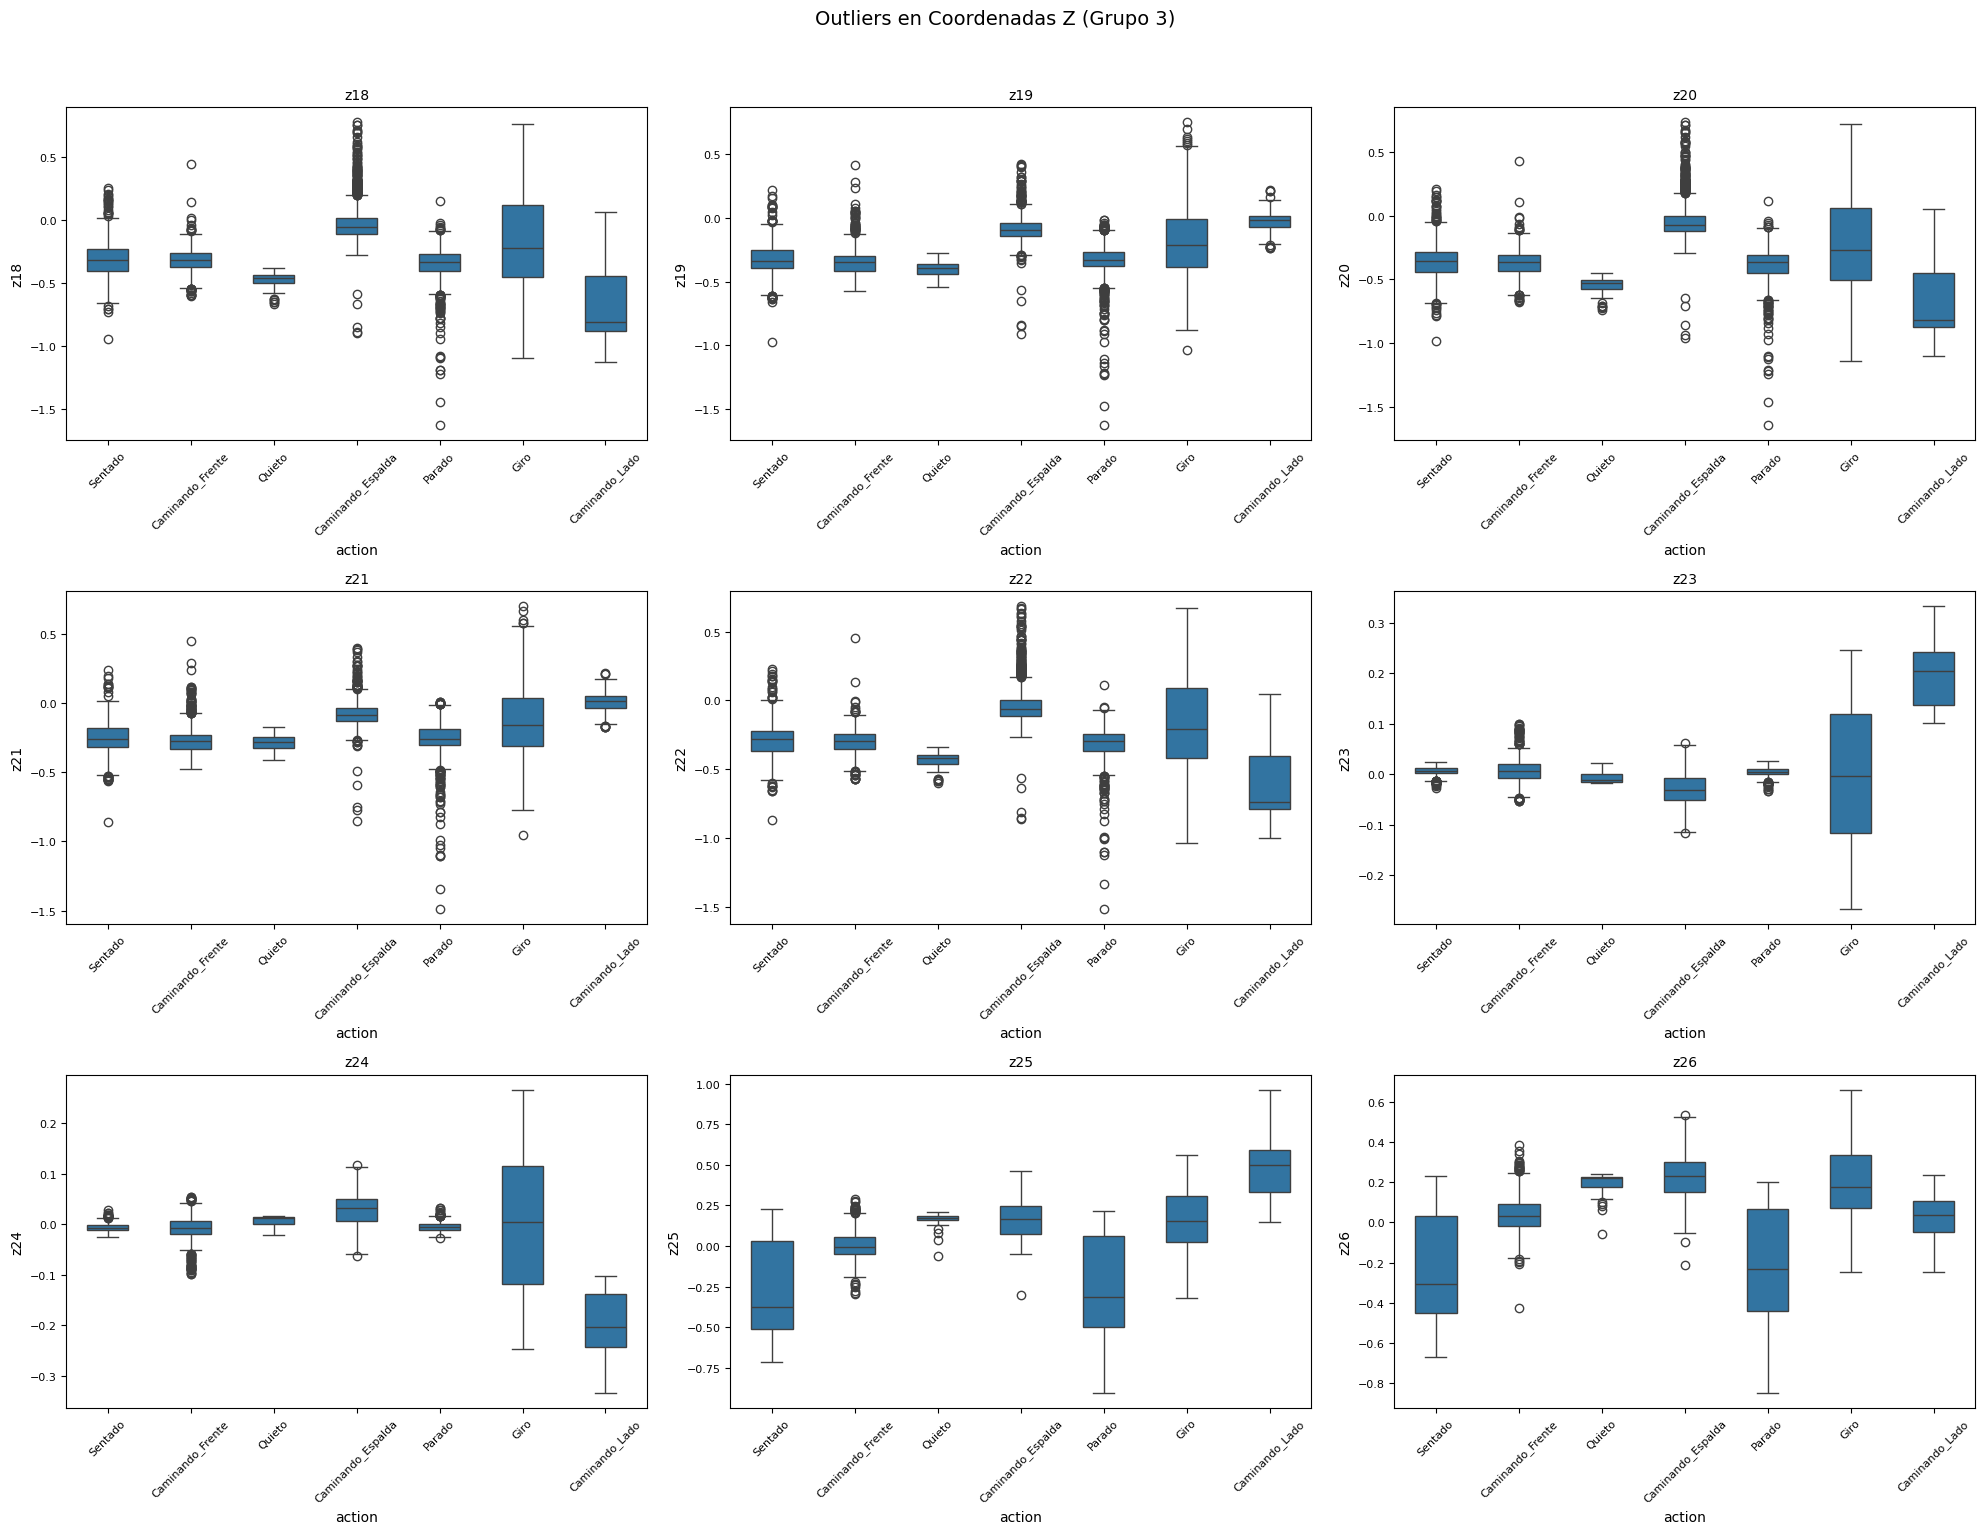

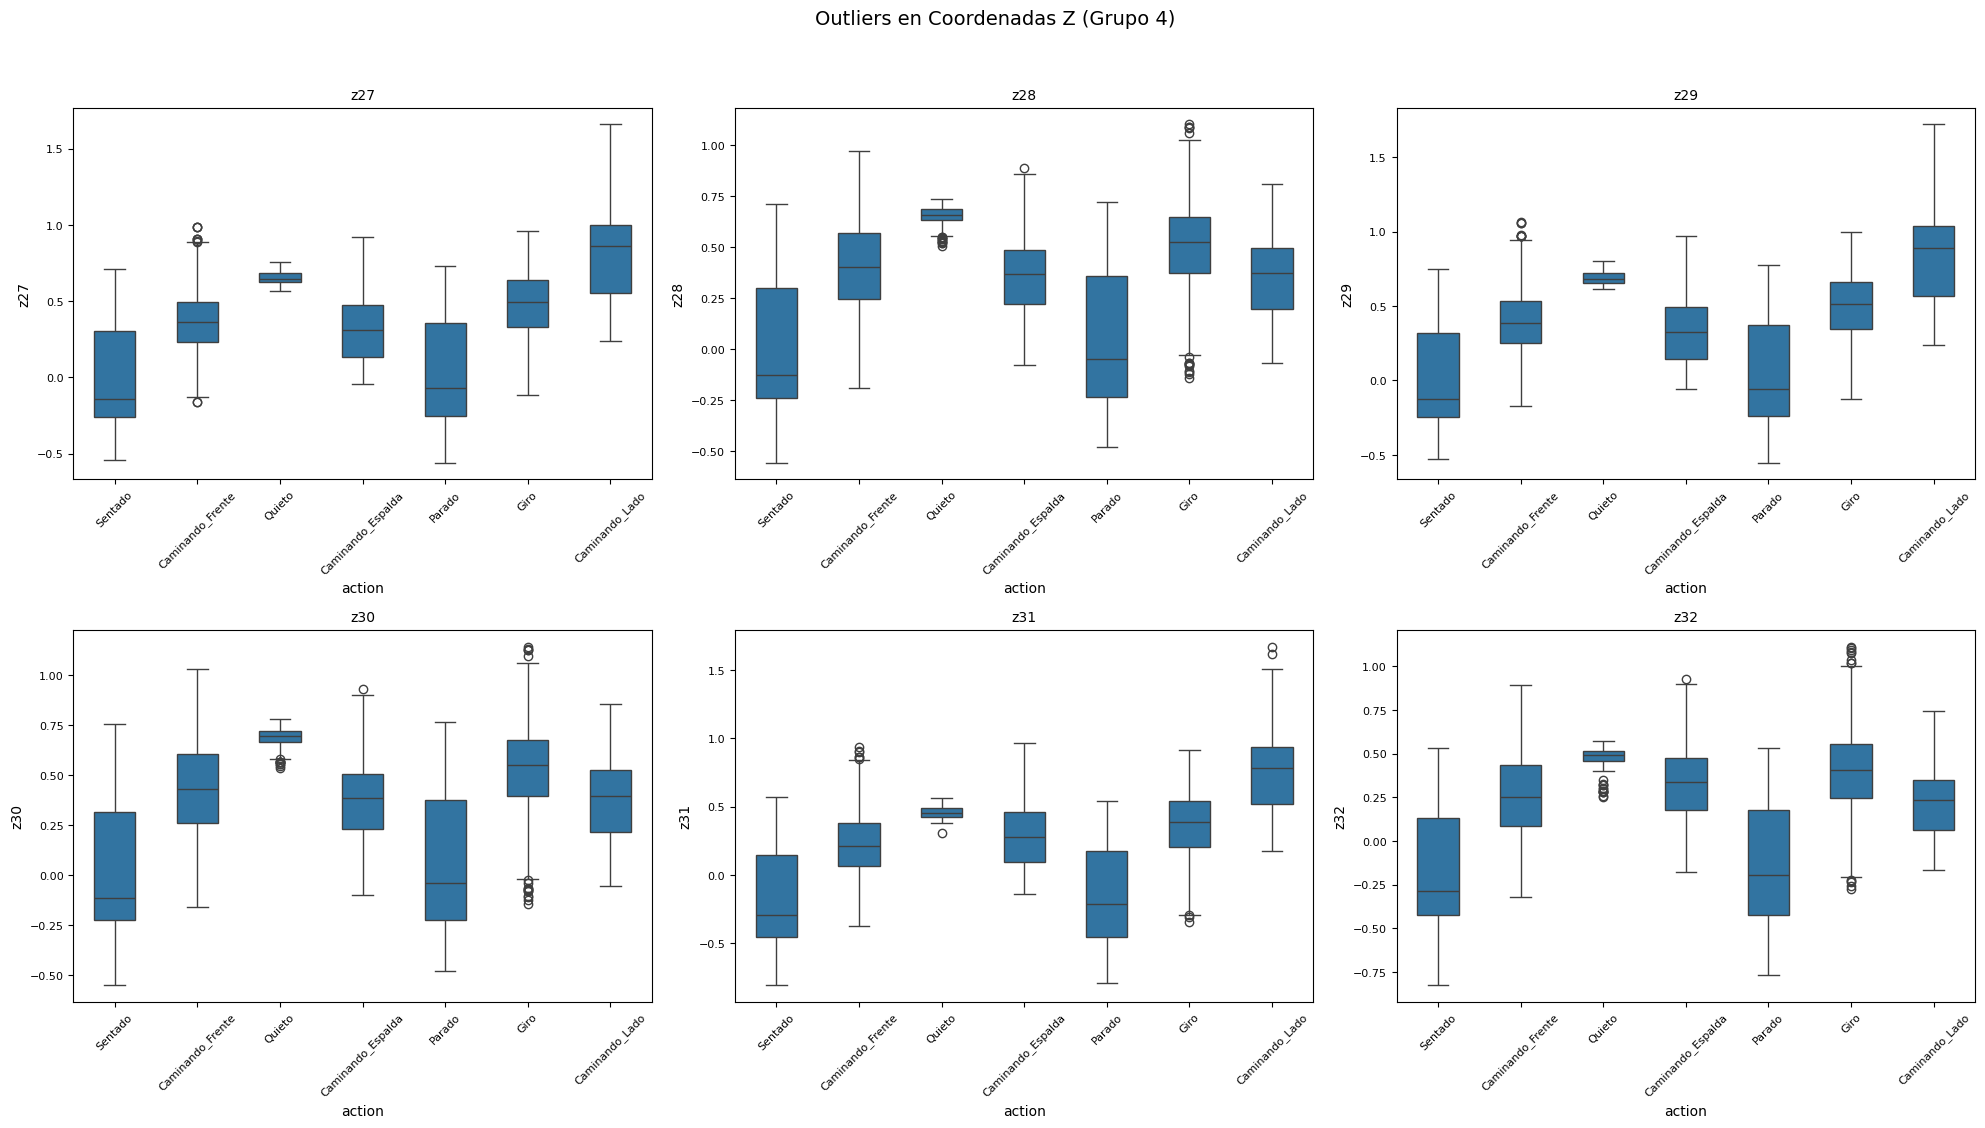

In [37]:
plot_boxplots_by_groups(z_coords, df, 'Outliers en Coordenadas Z')

**Limpieza outliers**

En este paso realizamos la limpieza de outliers utilizando el método IQR (Rango Intercuartílico) de manera específica para cada tipo de acción.

Primero, creamos una copia del DataFrame original para preservar los datos originales. Luego, para cada tipo de acción y cada coordenada, calculamos los límites superior e inferior usando el método IQR (Q3 - Q1) multiplicado por 1.5, y marcamos como NaN aquellos valores que caen fuera de estos límites.

Este enfoque por tipo de acción es importante porque diferentes acciones pueden tener rangos normales de movimiento distintos.

Finalmente, eliminamos todas las filas que contienen valores NaN para asegurar que solo conservamos datos completos y limpios.

El proceso nos muestra cuántos registros se conservaron después de la limpieza y el porcentaje de datos que se mantuvieron, lo que nos ayuda a evaluar el impacto de la limpieza en nuestro conjunto de datos.

Este paso es crucial para asegurar la calidad de los datos que usaremos para entrenar nuestro modelo de clasificación.

In [38]:
# Crear copia del DataFrame original
df_cleaned = df.copy()

# Filtrar outliers usando IQR para cada coordenada por tipo de acción
for action in df['action'].unique():
    action_mask = df_cleaned['action'] == action

    for column in df_cleaned.columns:
        if column != 'action' and column != 'source_video':
            Q1 = df_cleaned.loc[action_mask, column].quantile(0.25)
            Q3 = df_cleaned.loc[action_mask, column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            # Crear máscara para outliers
            outlier_mask = (df_cleaned.loc[action_mask, column] >= lower_bound) & \
                          (df_cleaned.loc[action_mask, column] <= upper_bound)

            # Aplicar máscara
            df_cleaned.loc[action_mask & ~outlier_mask, column] = np.nan

# Eliminar filas con valores NaN
df_cleaned = df_cleaned.dropna()

print(f"Registros originales: {len(df)}")
print(f"Registros después de limpieza: {len(df_cleaned)}")
print(f"Porcentaje de datos conservados: {(len(df_cleaned)/len(df))*100:.2f}%")

Registros originales: 11299
Registros después de limpieza: 9168
Porcentaje de datos conservados: 81.14%


Después de aplicar la limpieza de outliers mediante el método IQR, se conservó el 81.14% de los datos originales (9,168 de 11,299 registros), lo que indica que el proceso de limpieza eliminó una cantidad razonable de valores atípicos mientras mantiene la mayoría de los datos relevantes para el análisis.

**Despues de la limpieza**

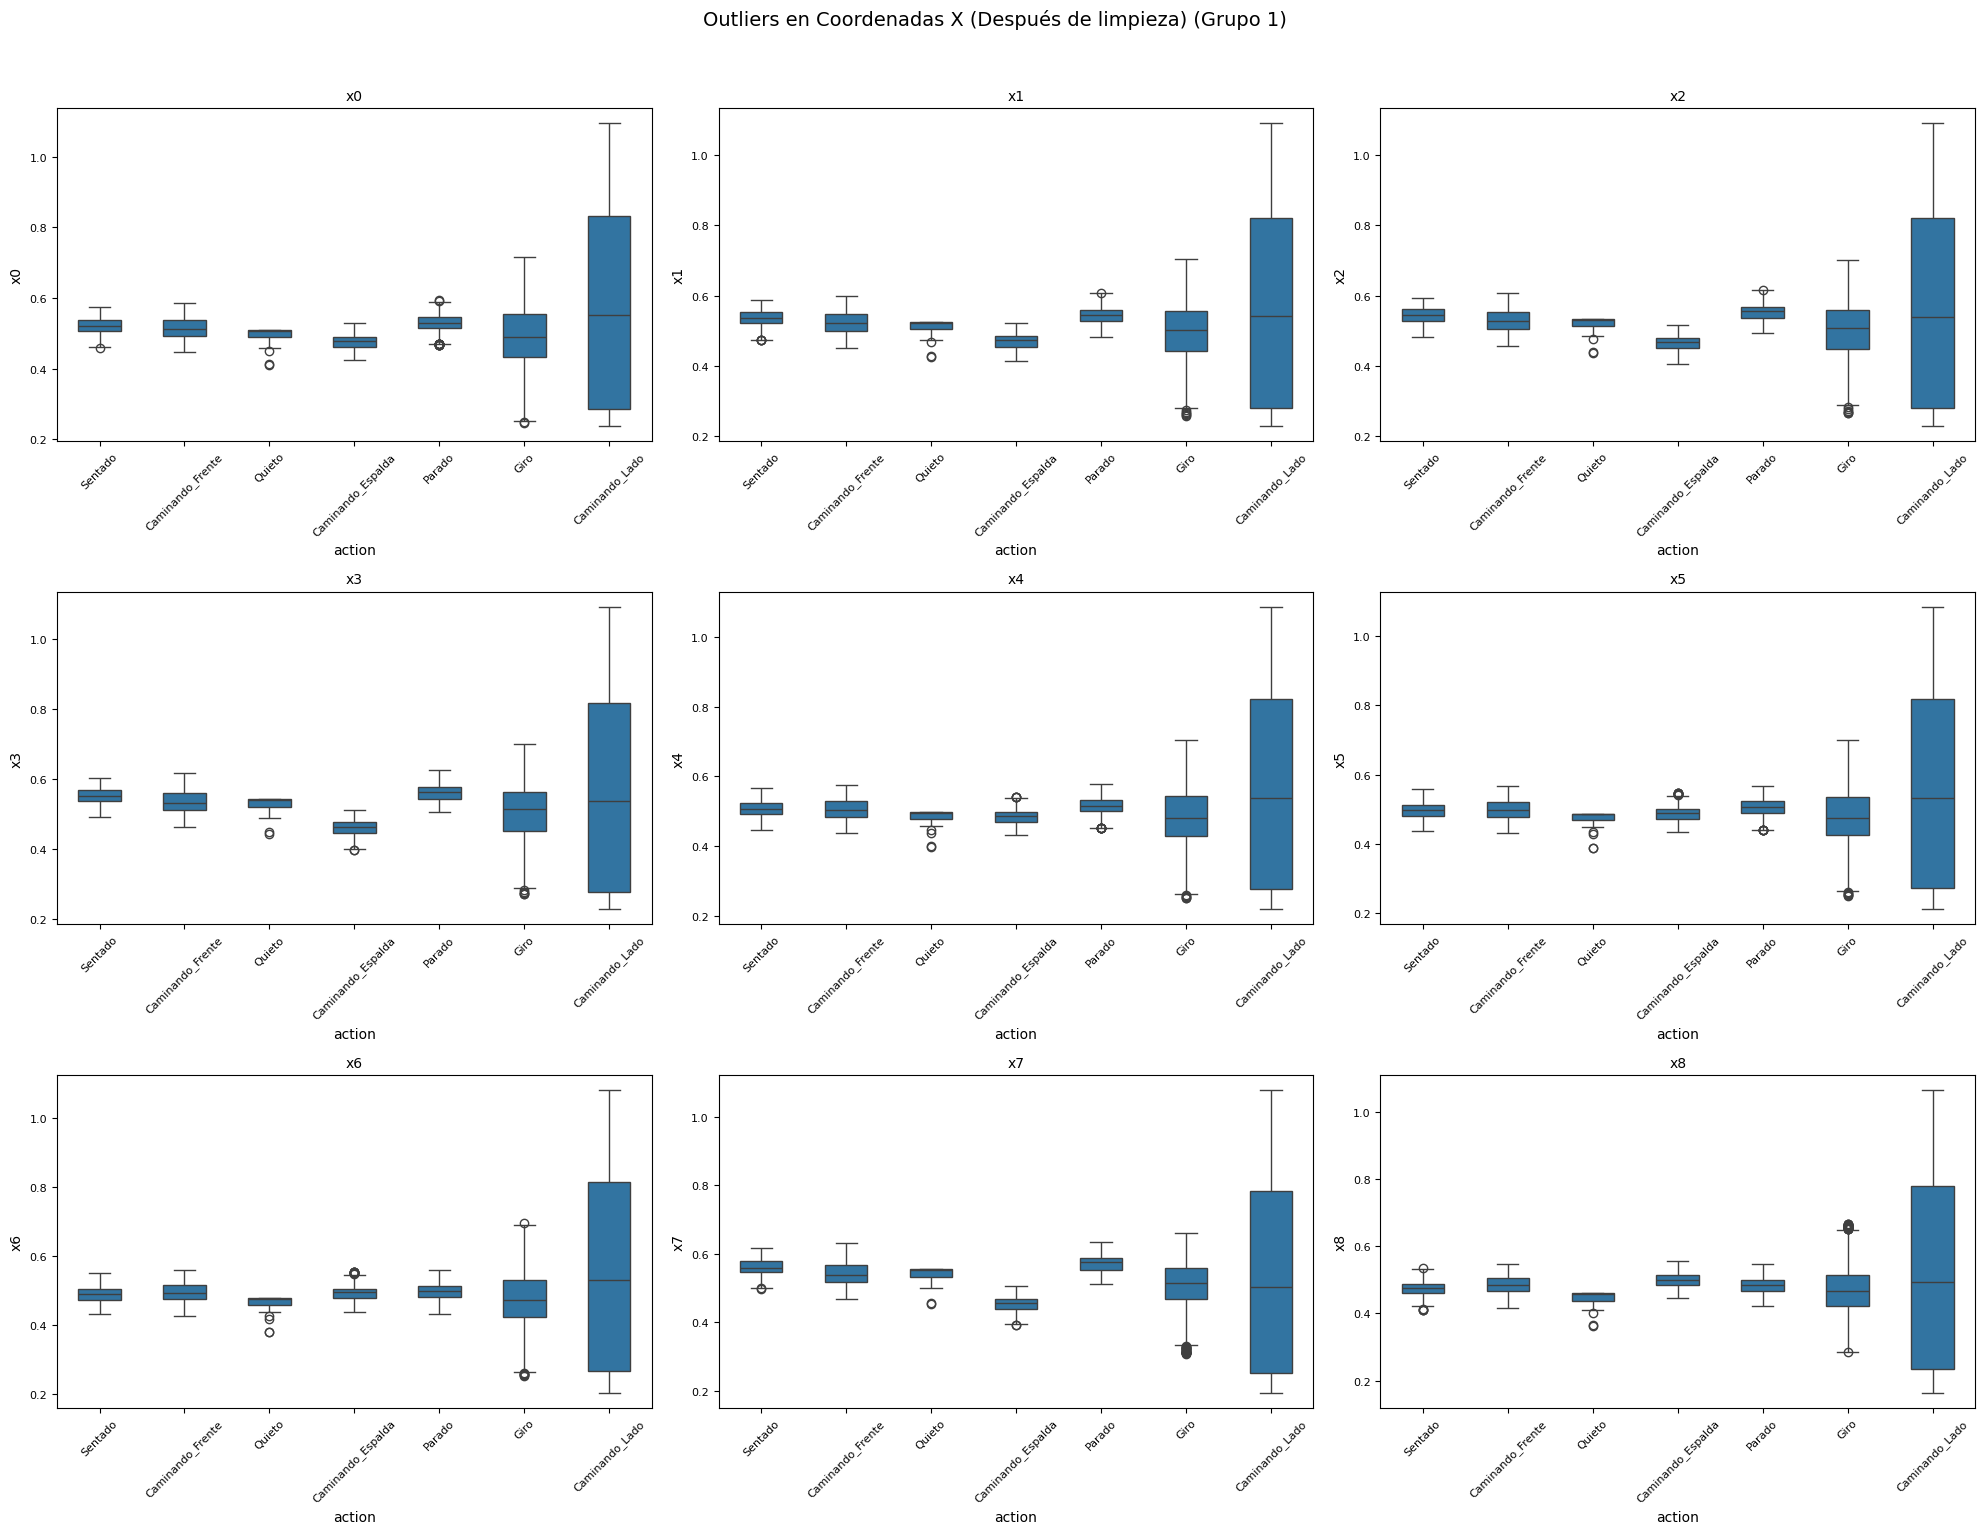

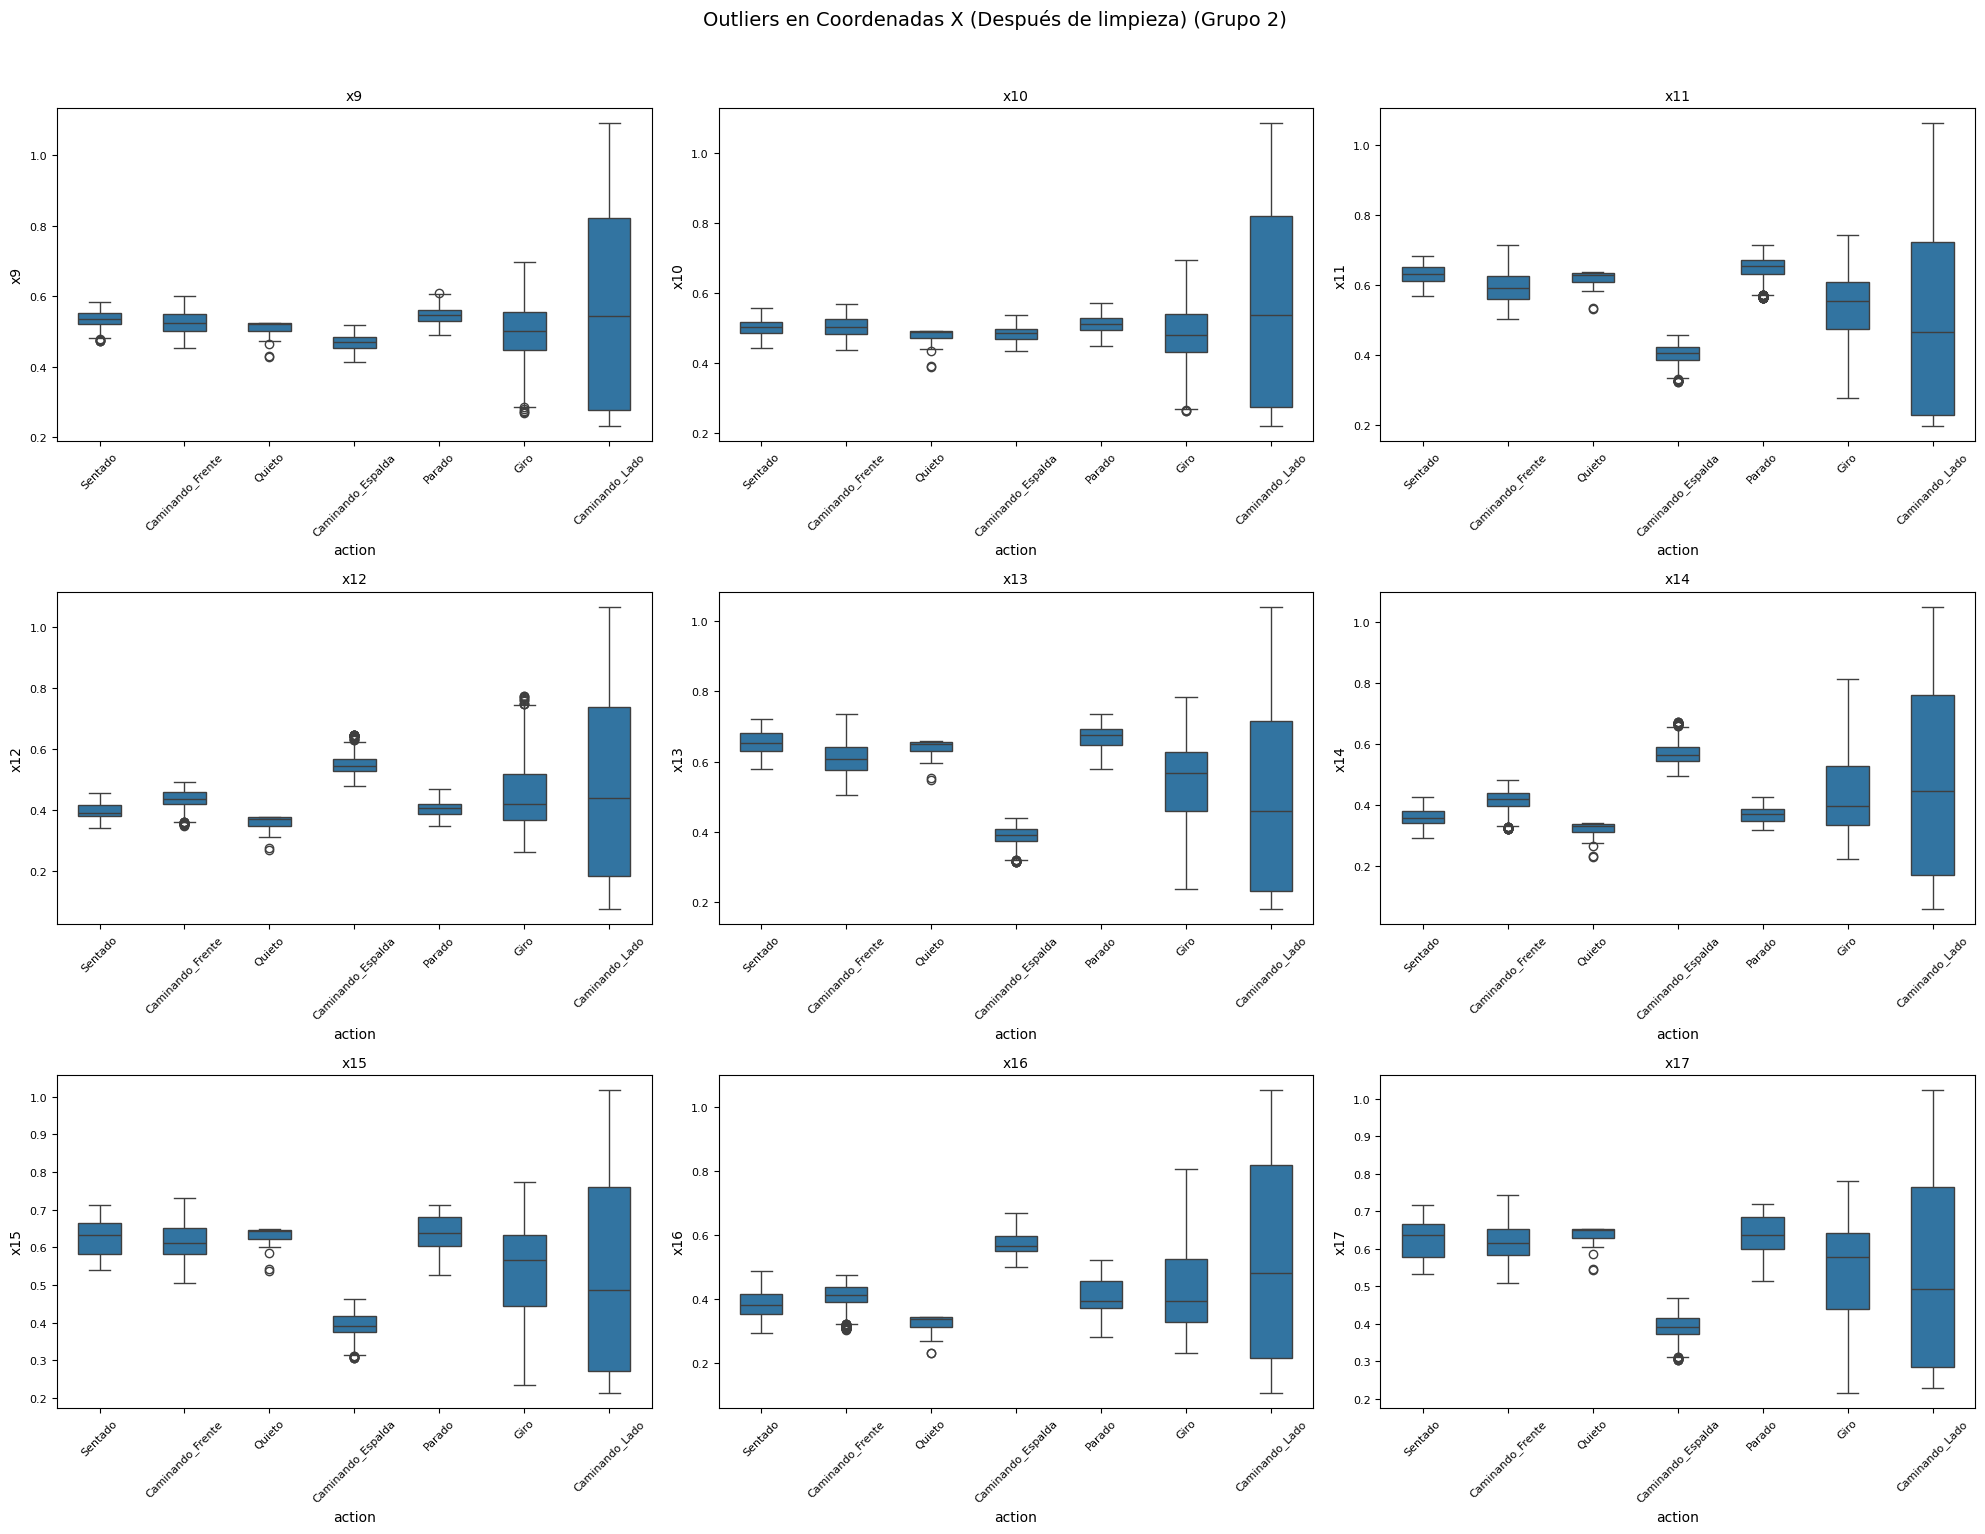

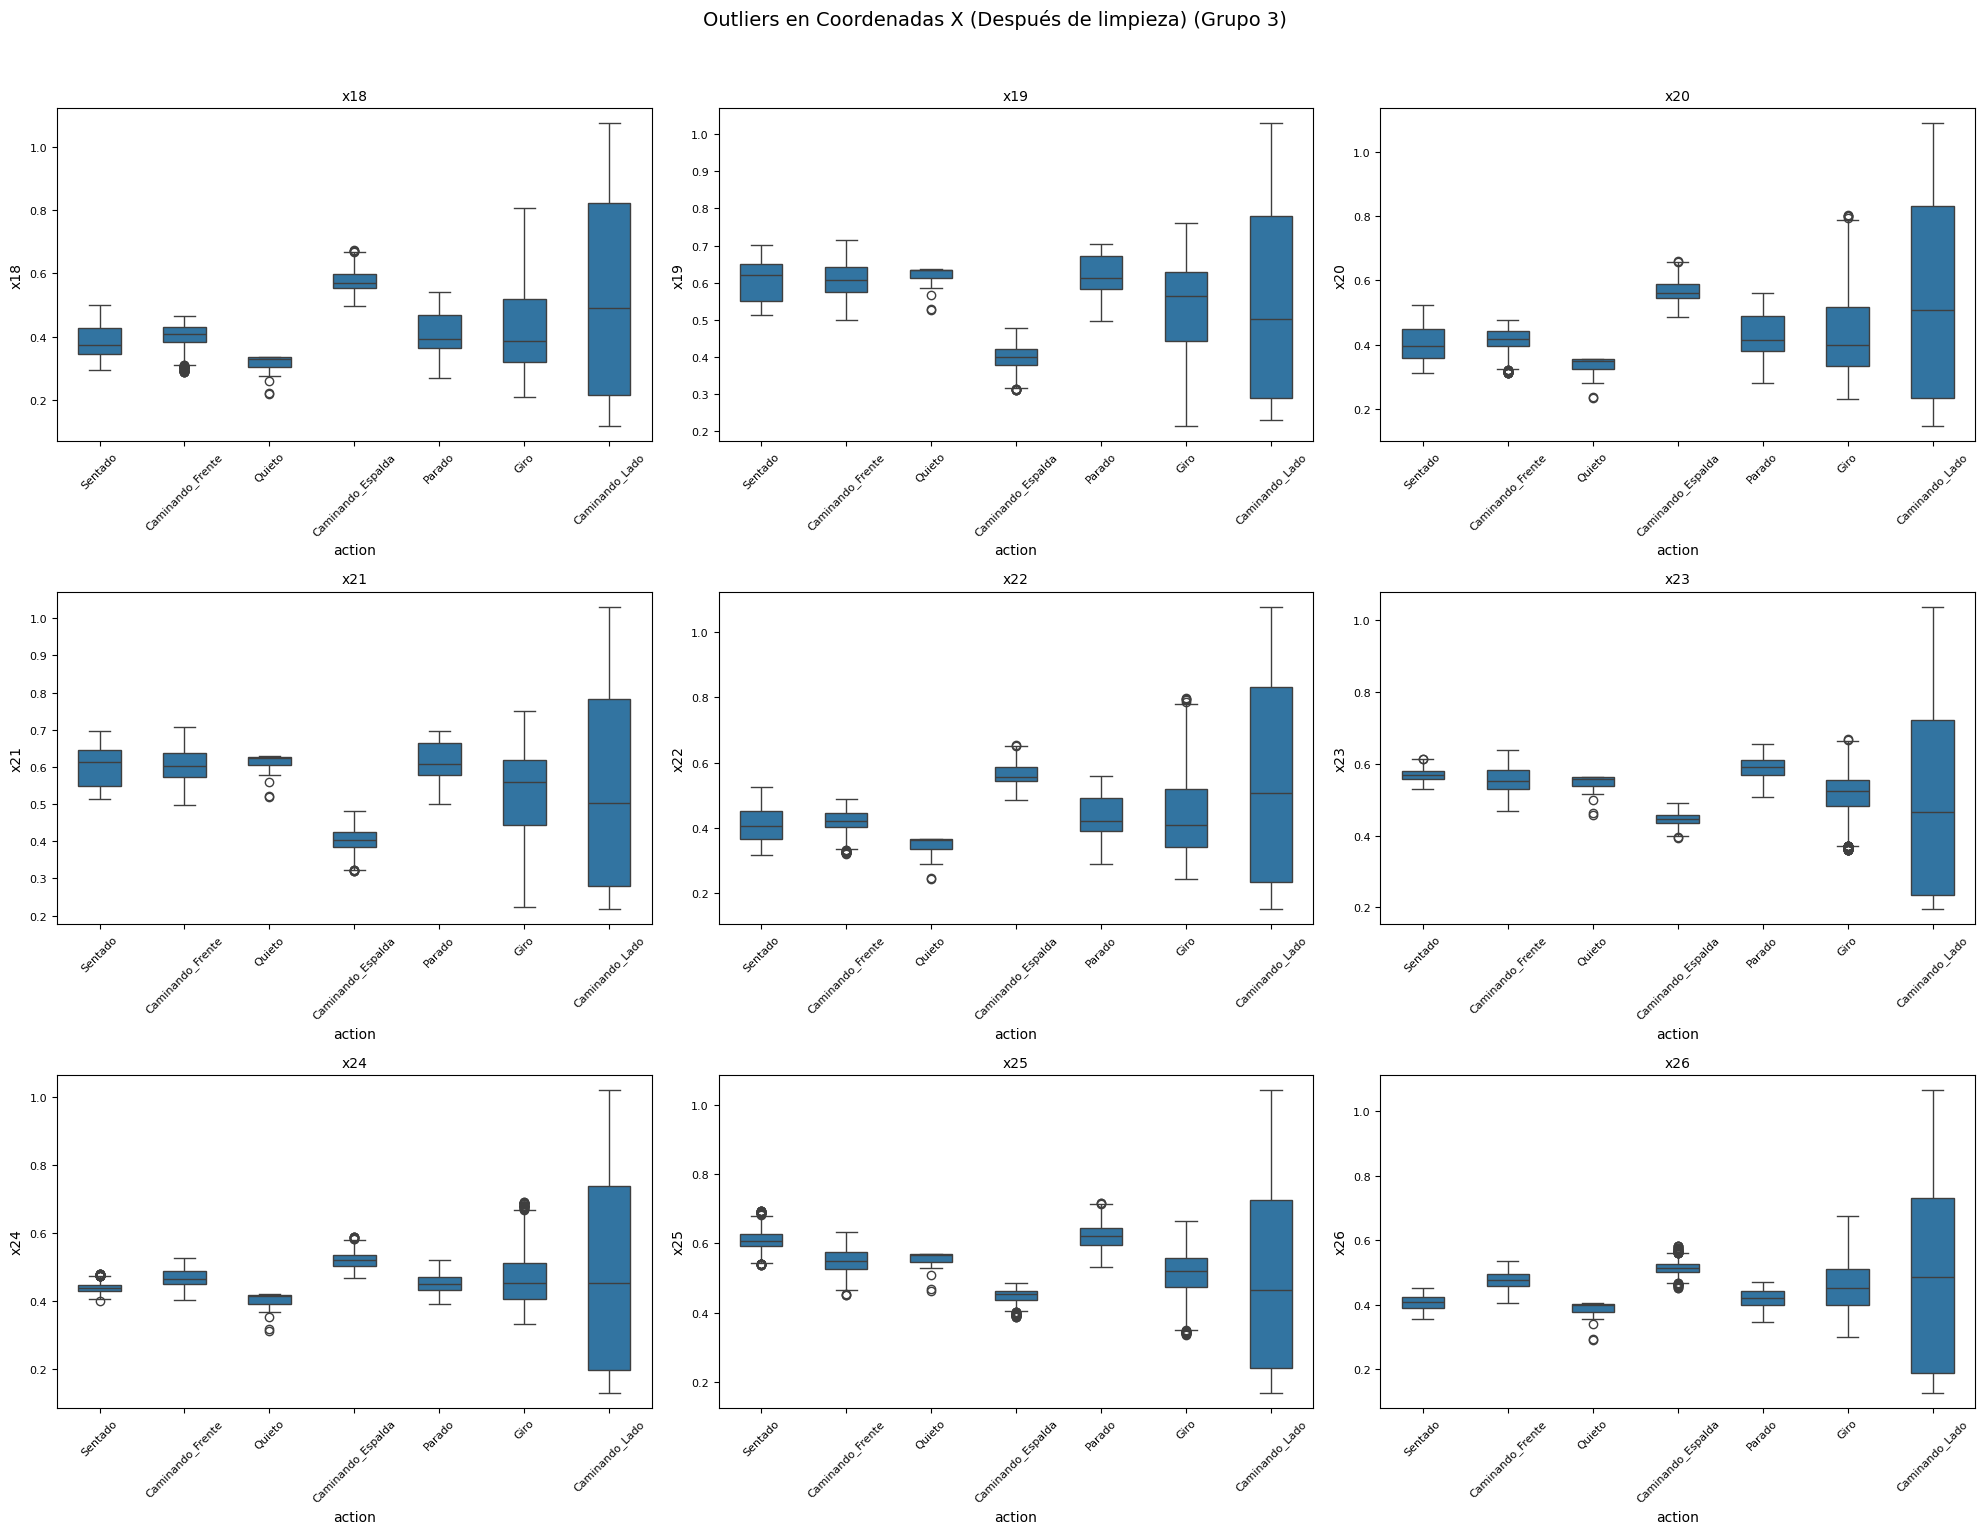

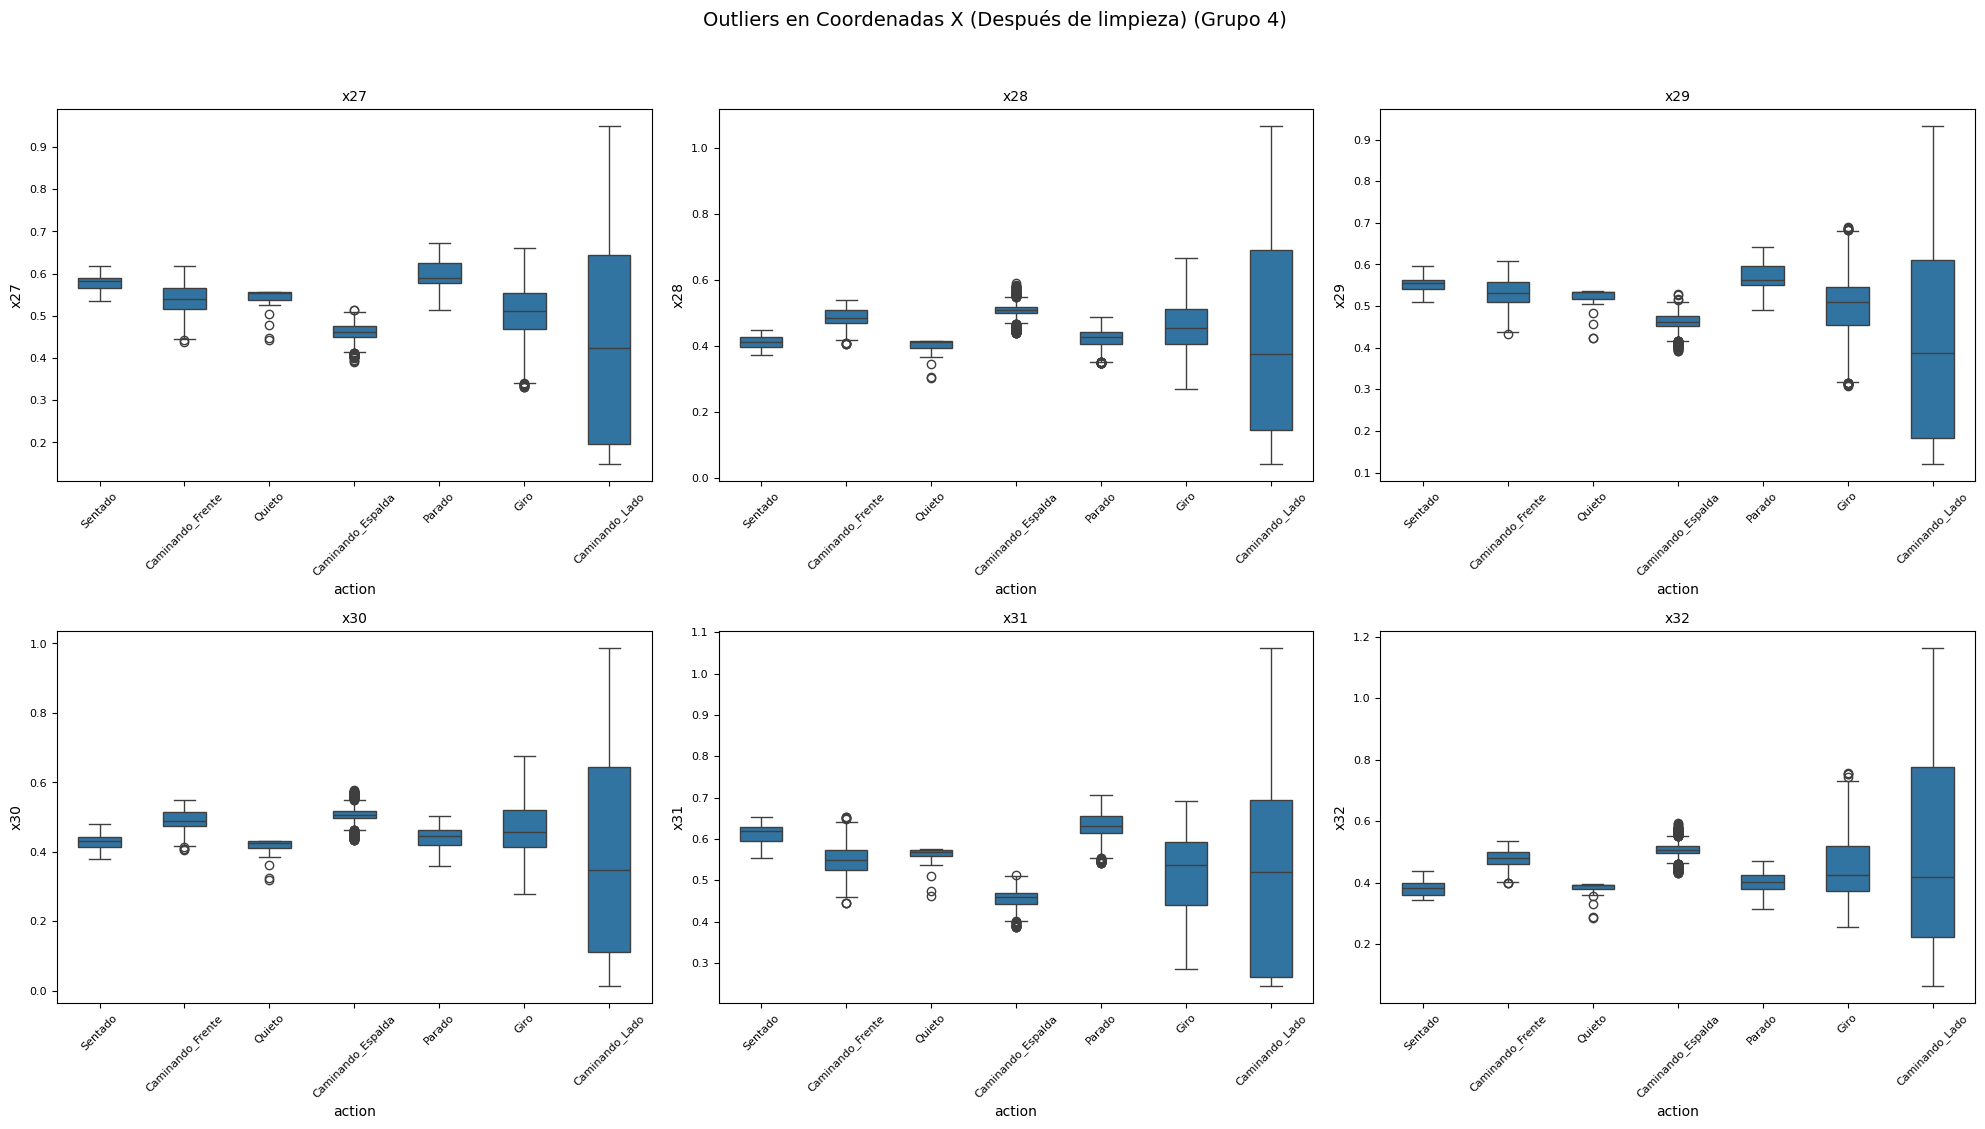

In [39]:
plot_boxplots_by_groups(x_coords, df_cleaned, 'Outliers en Coordenadas X (Después de limpieza)')

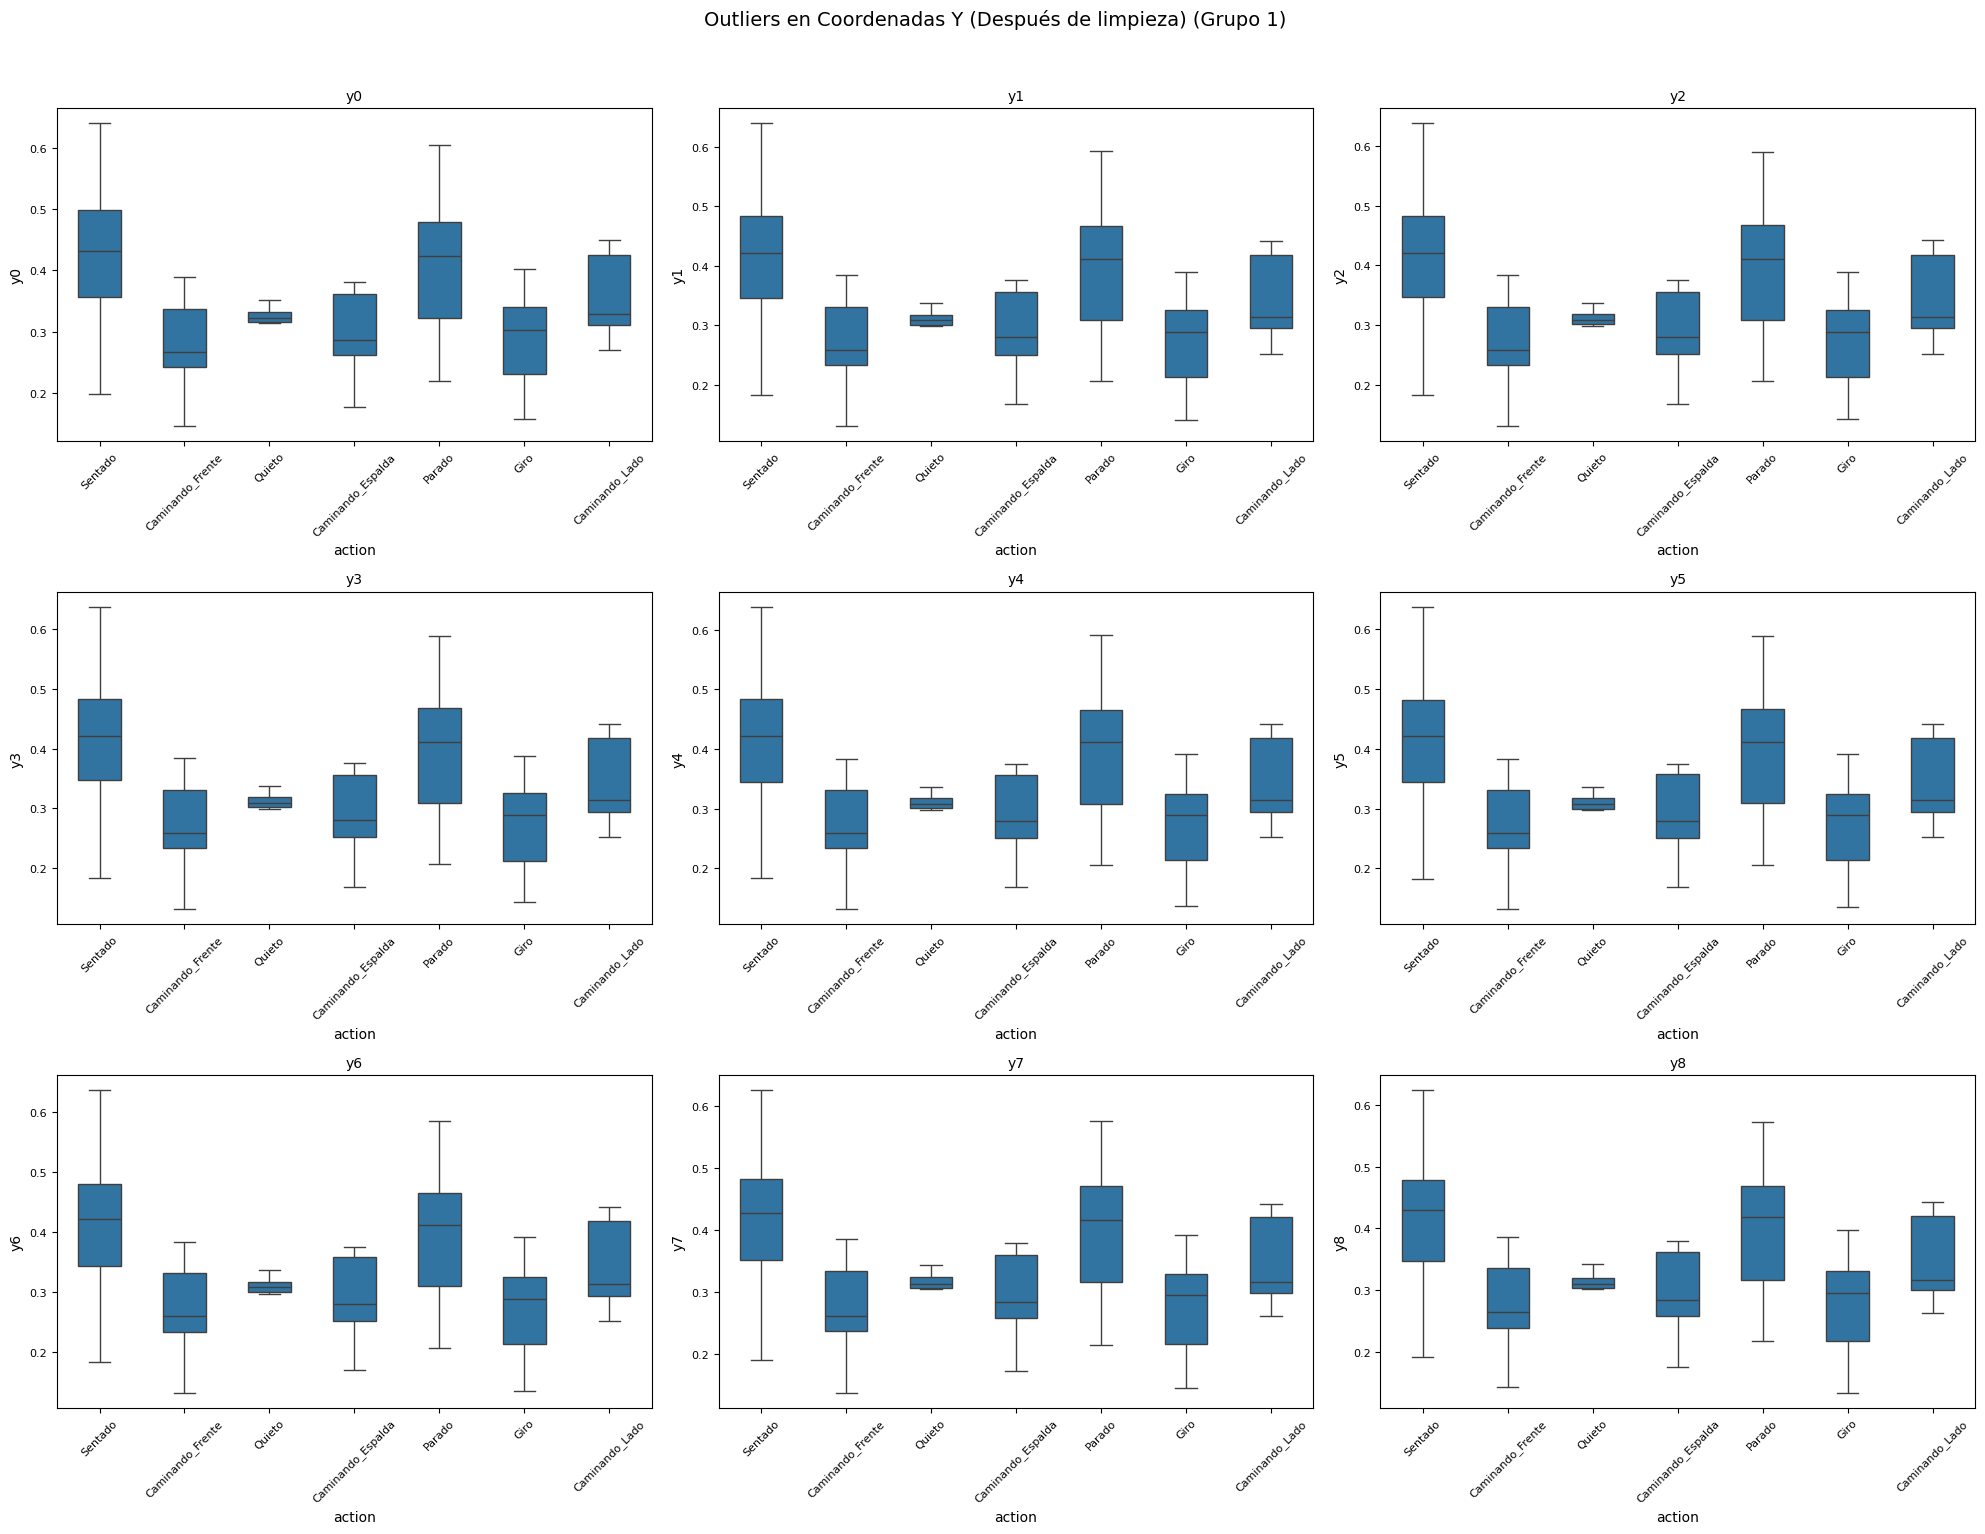

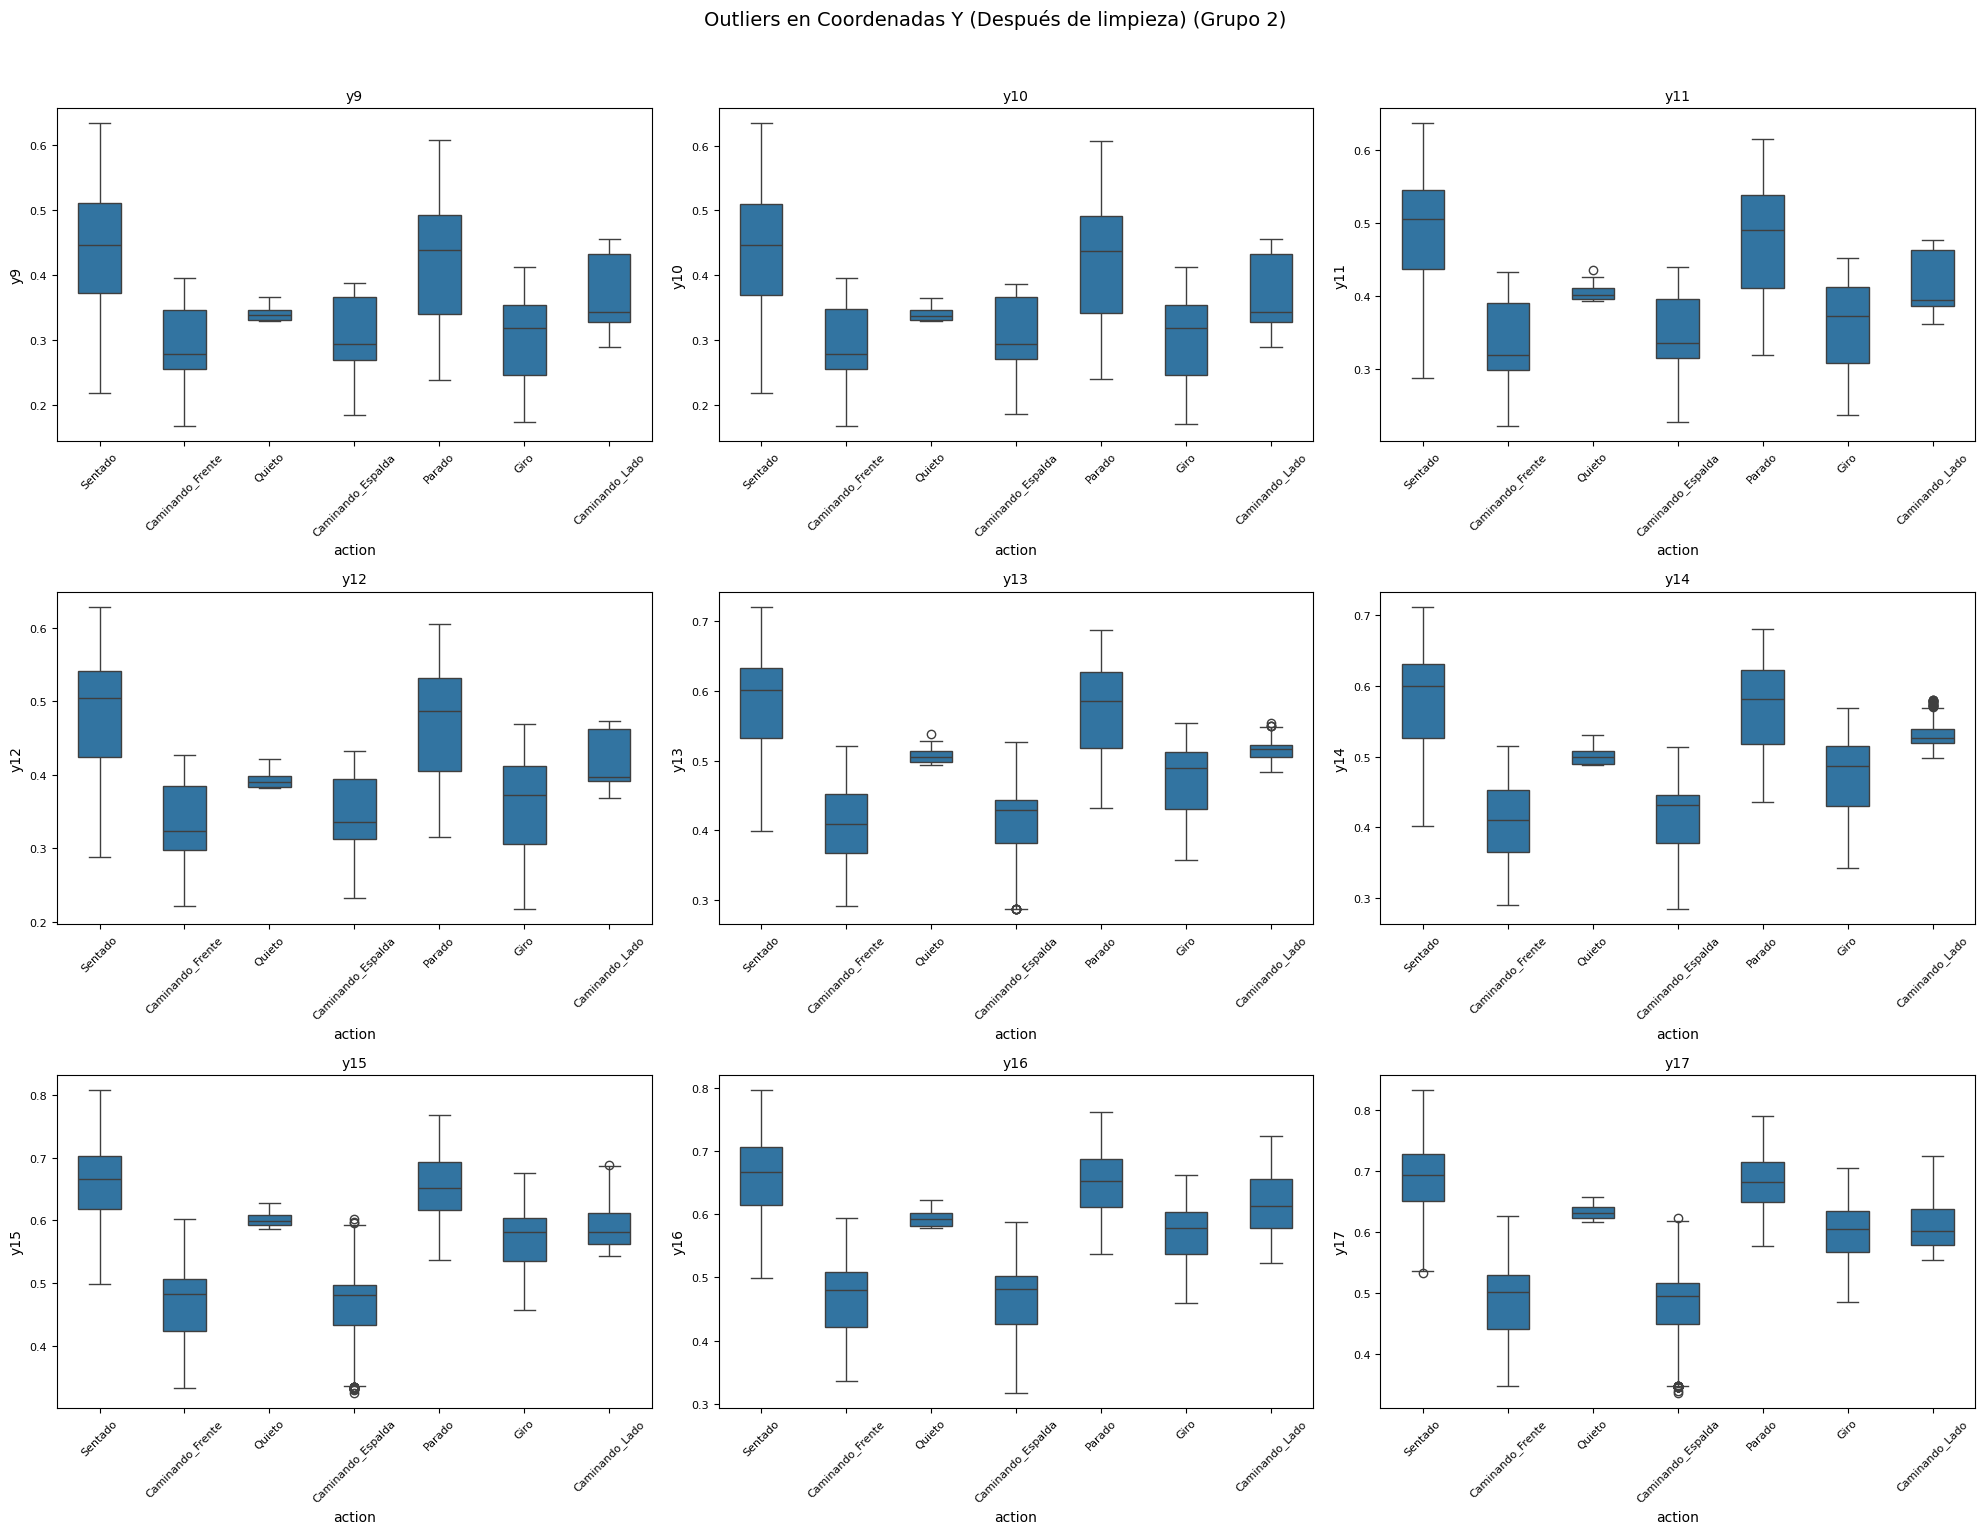

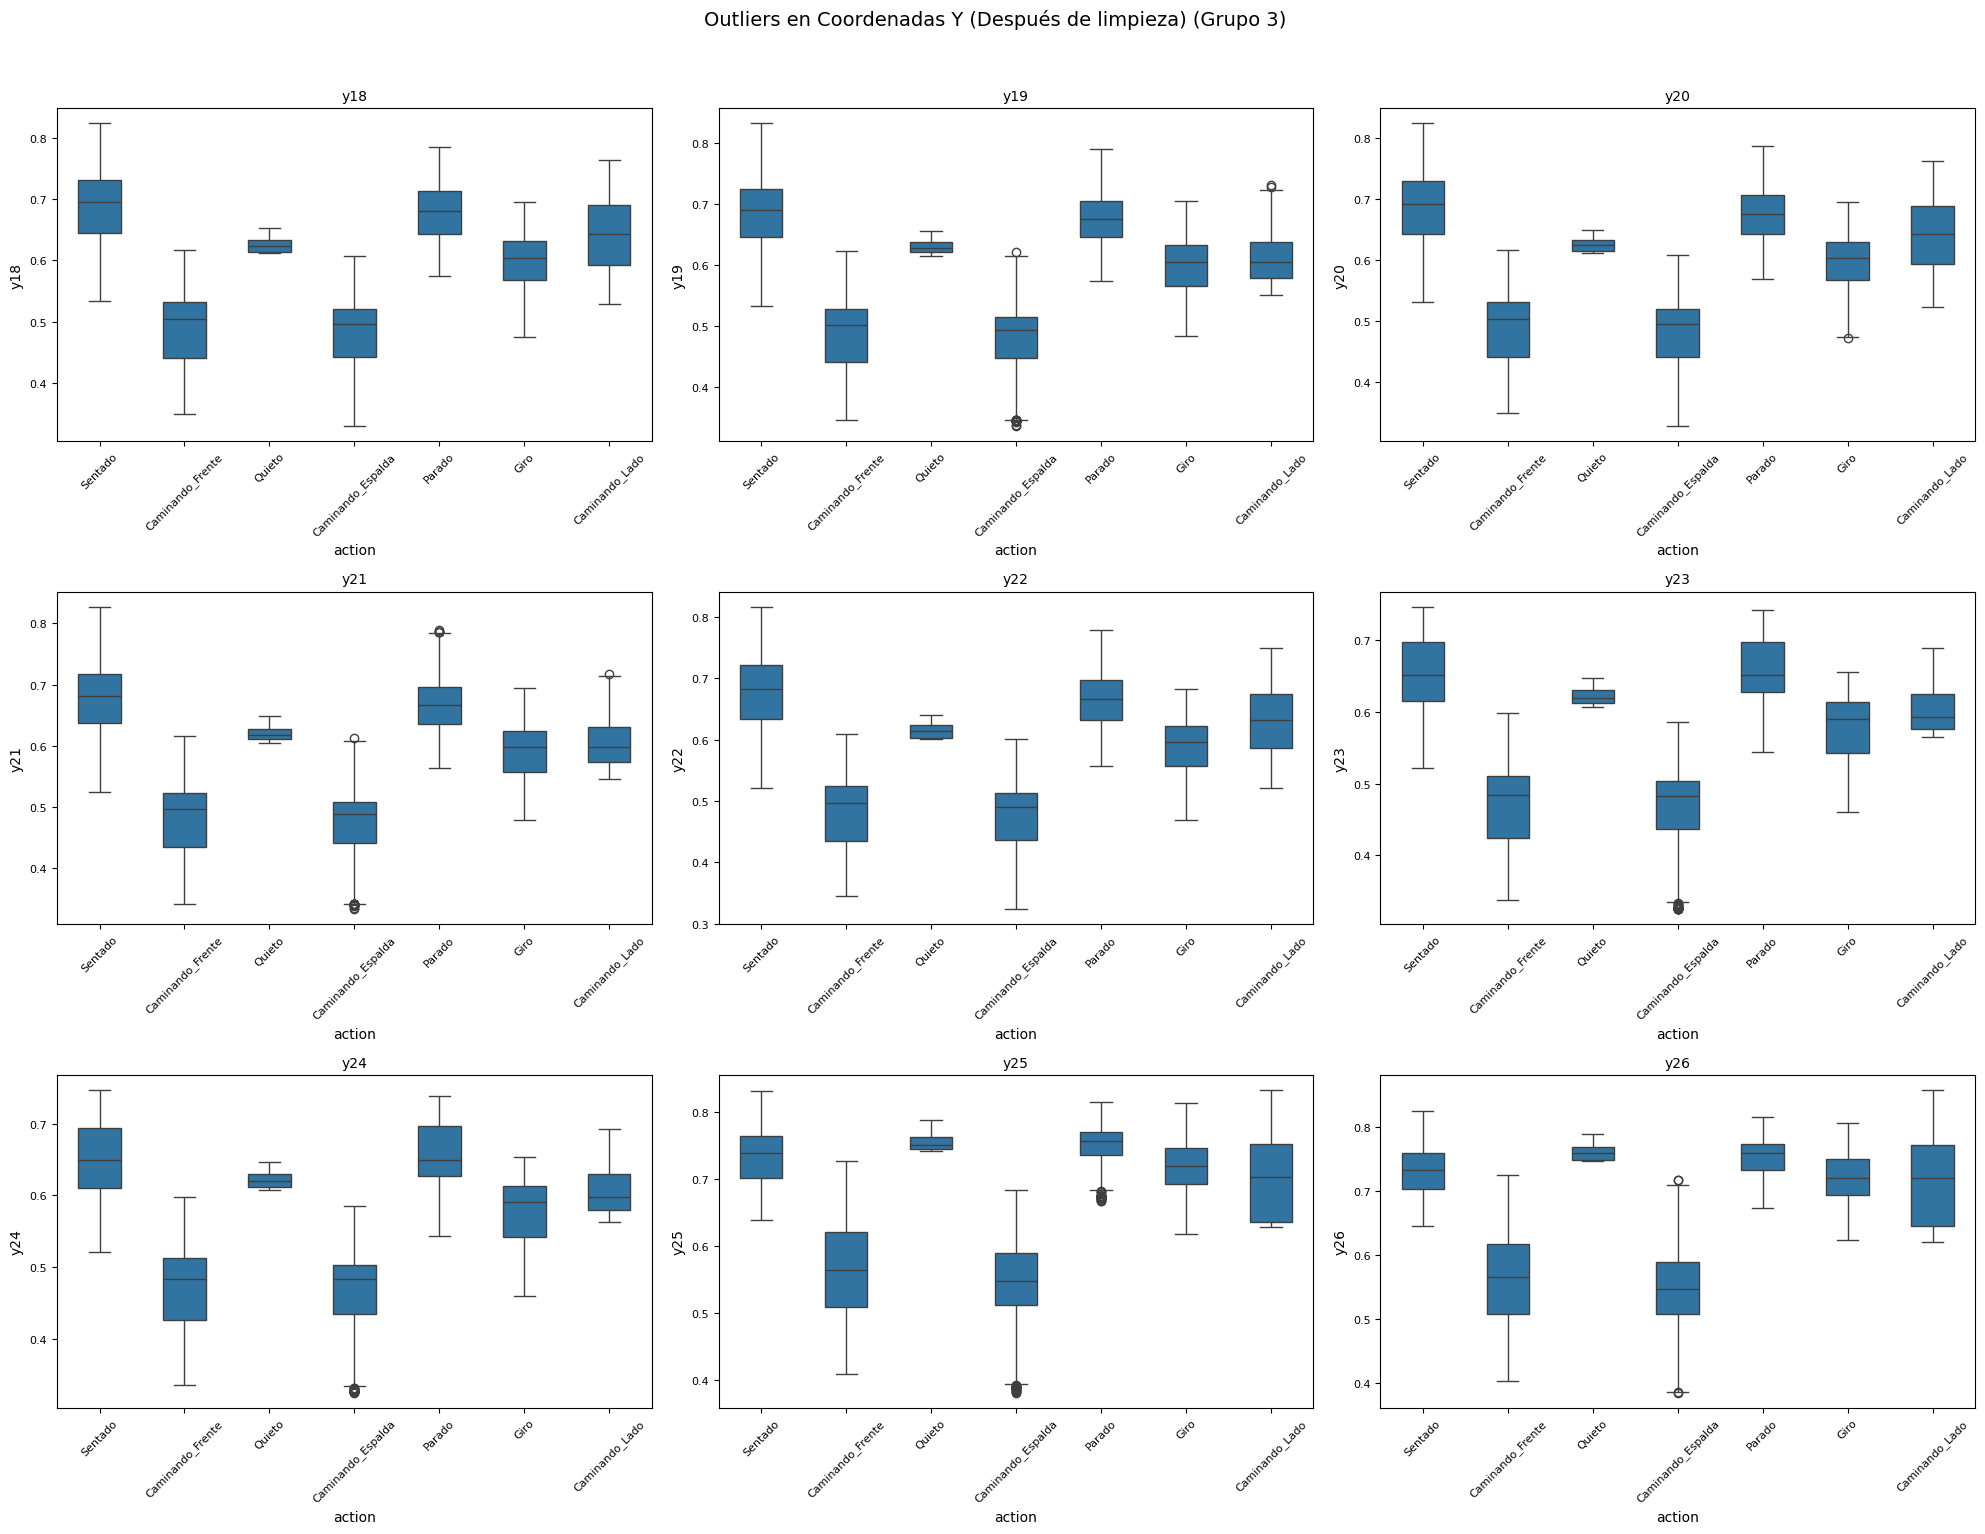

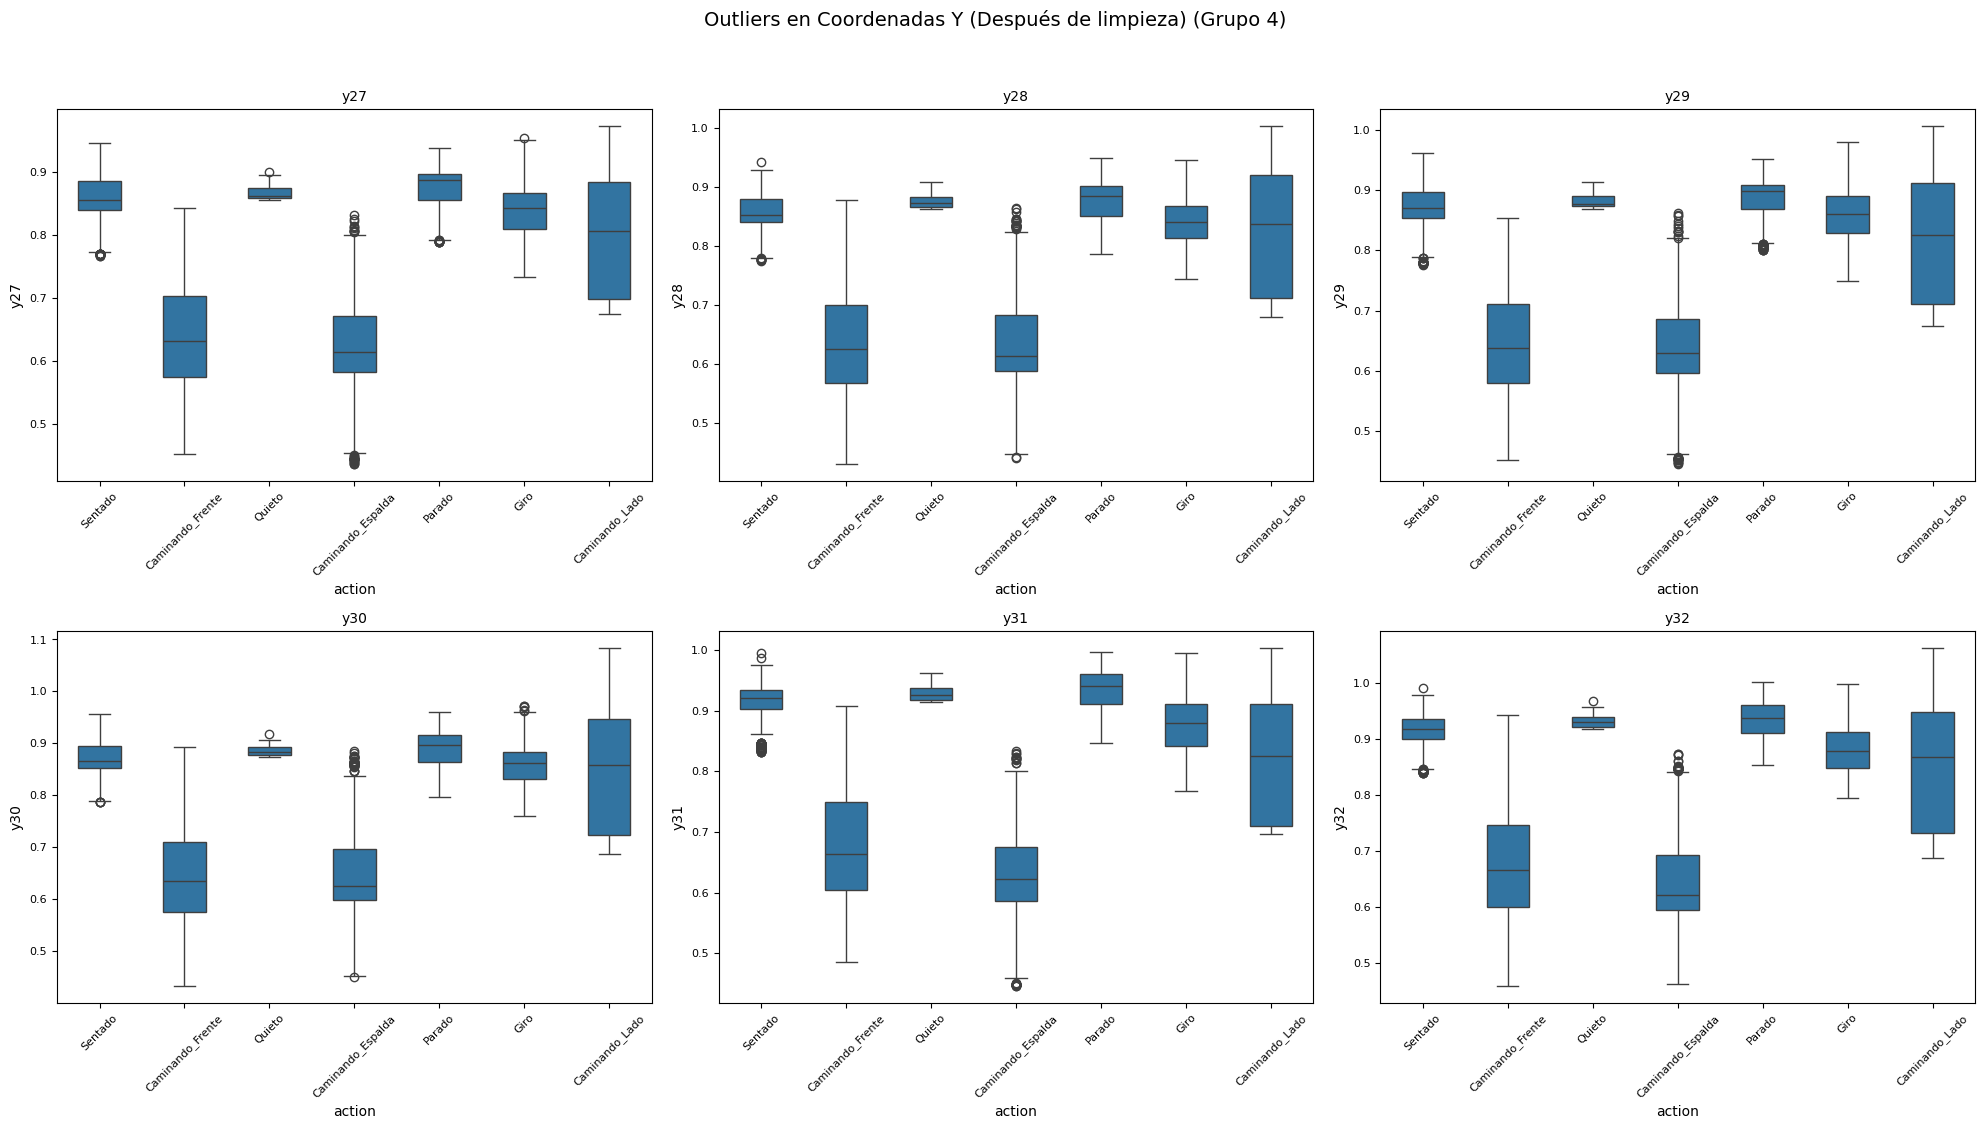

In [40]:
plot_boxplots_by_groups(y_coords, df_cleaned, 'Outliers en Coordenadas Y (Después de limpieza)')

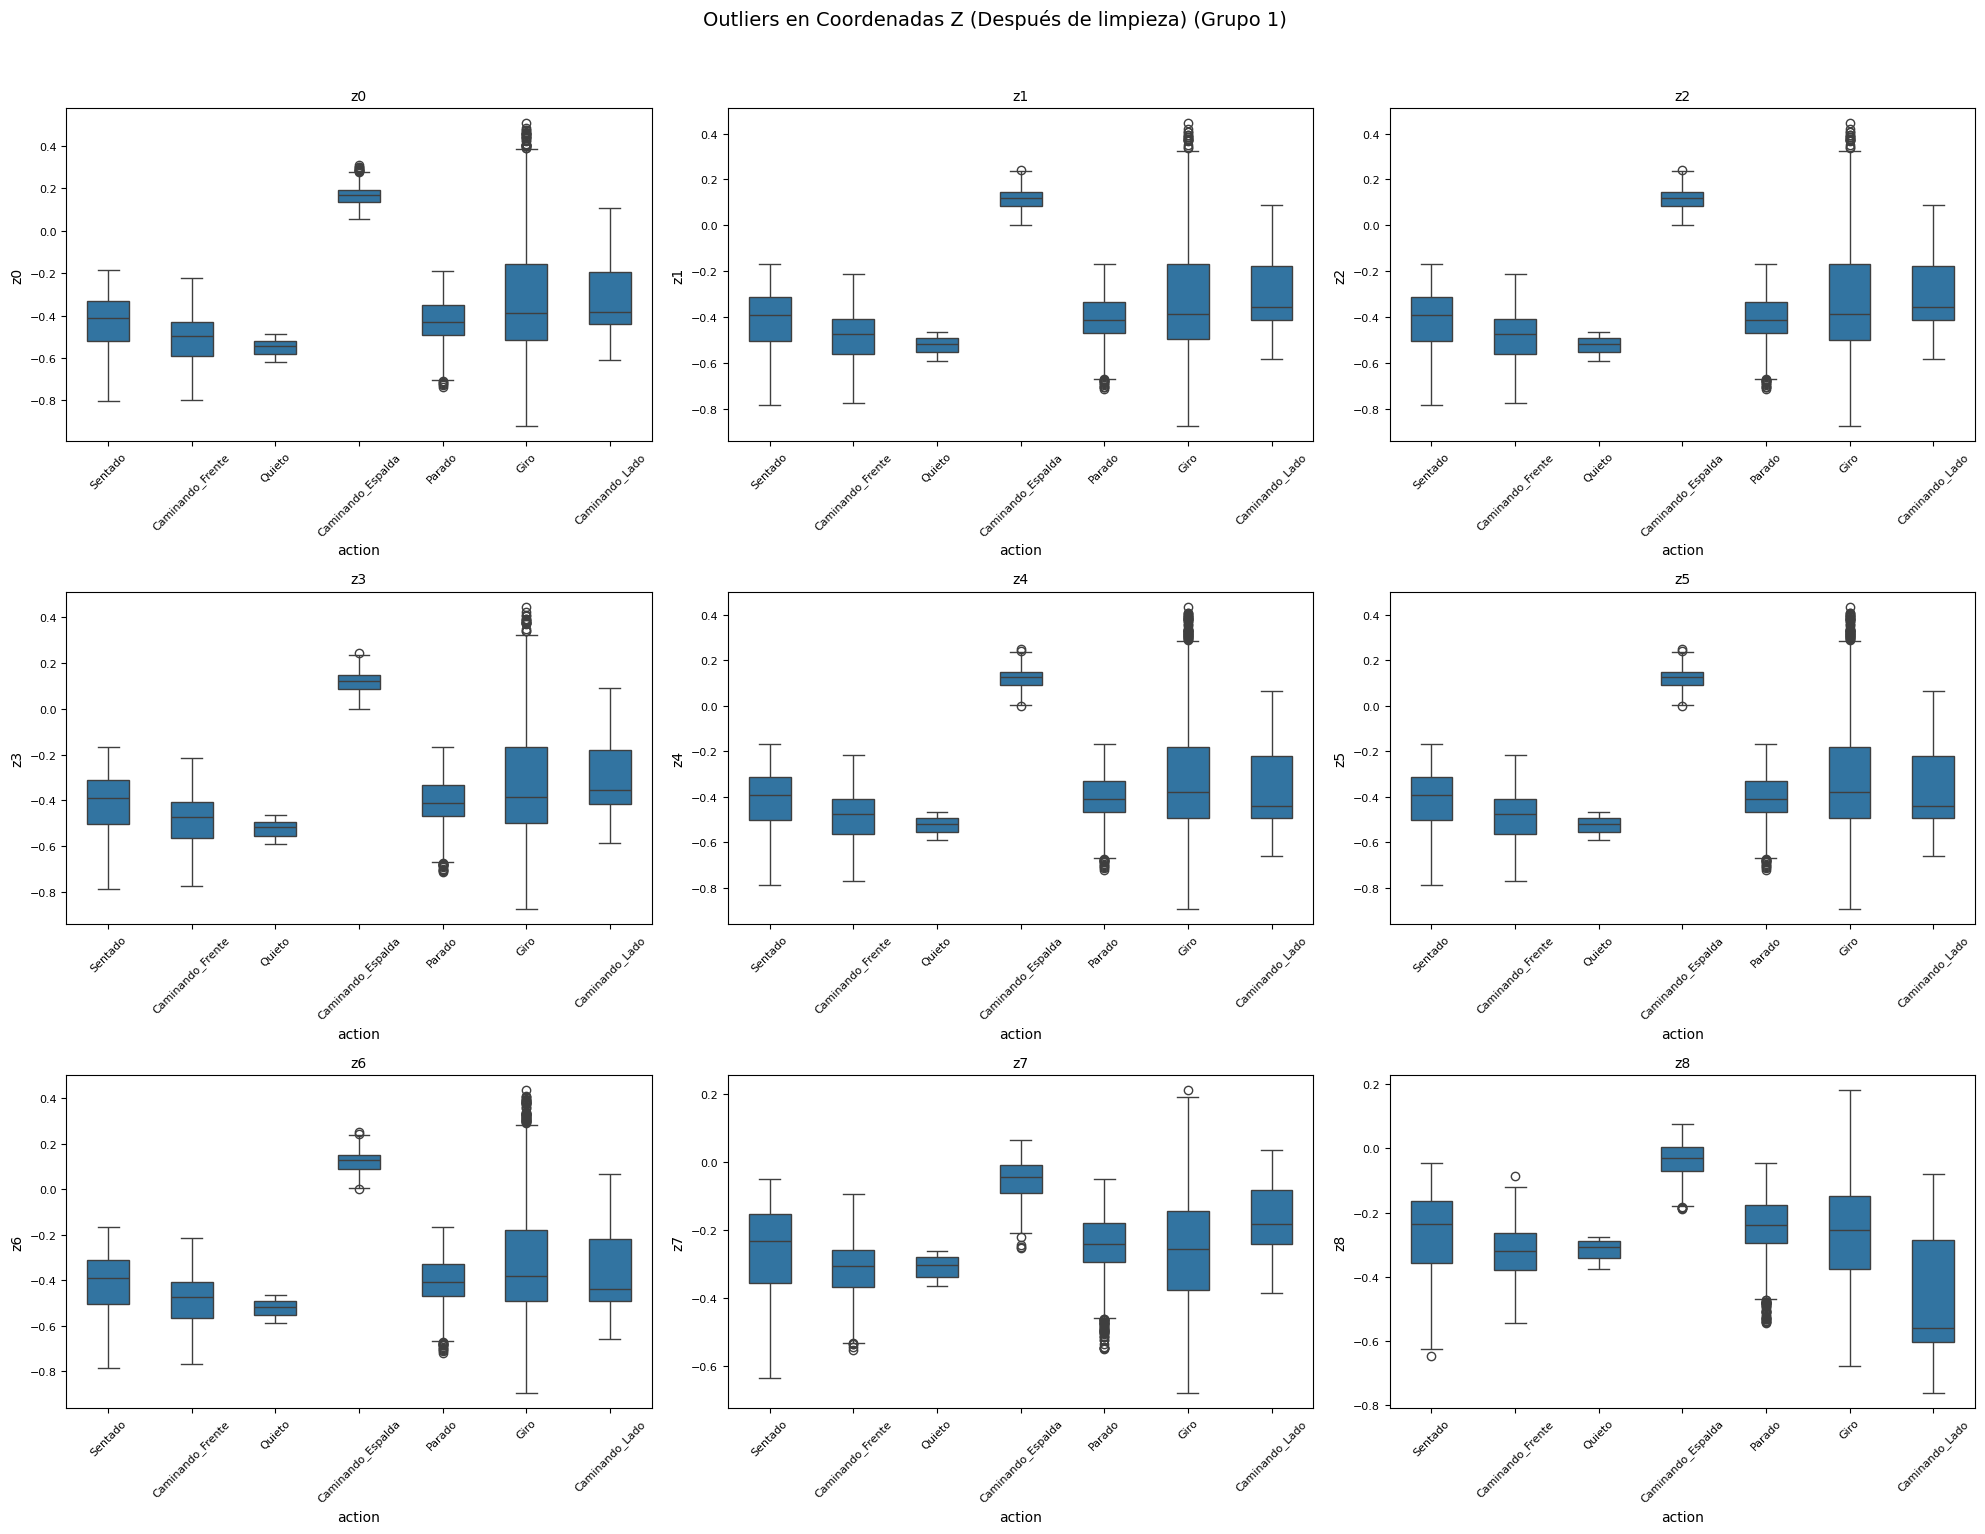

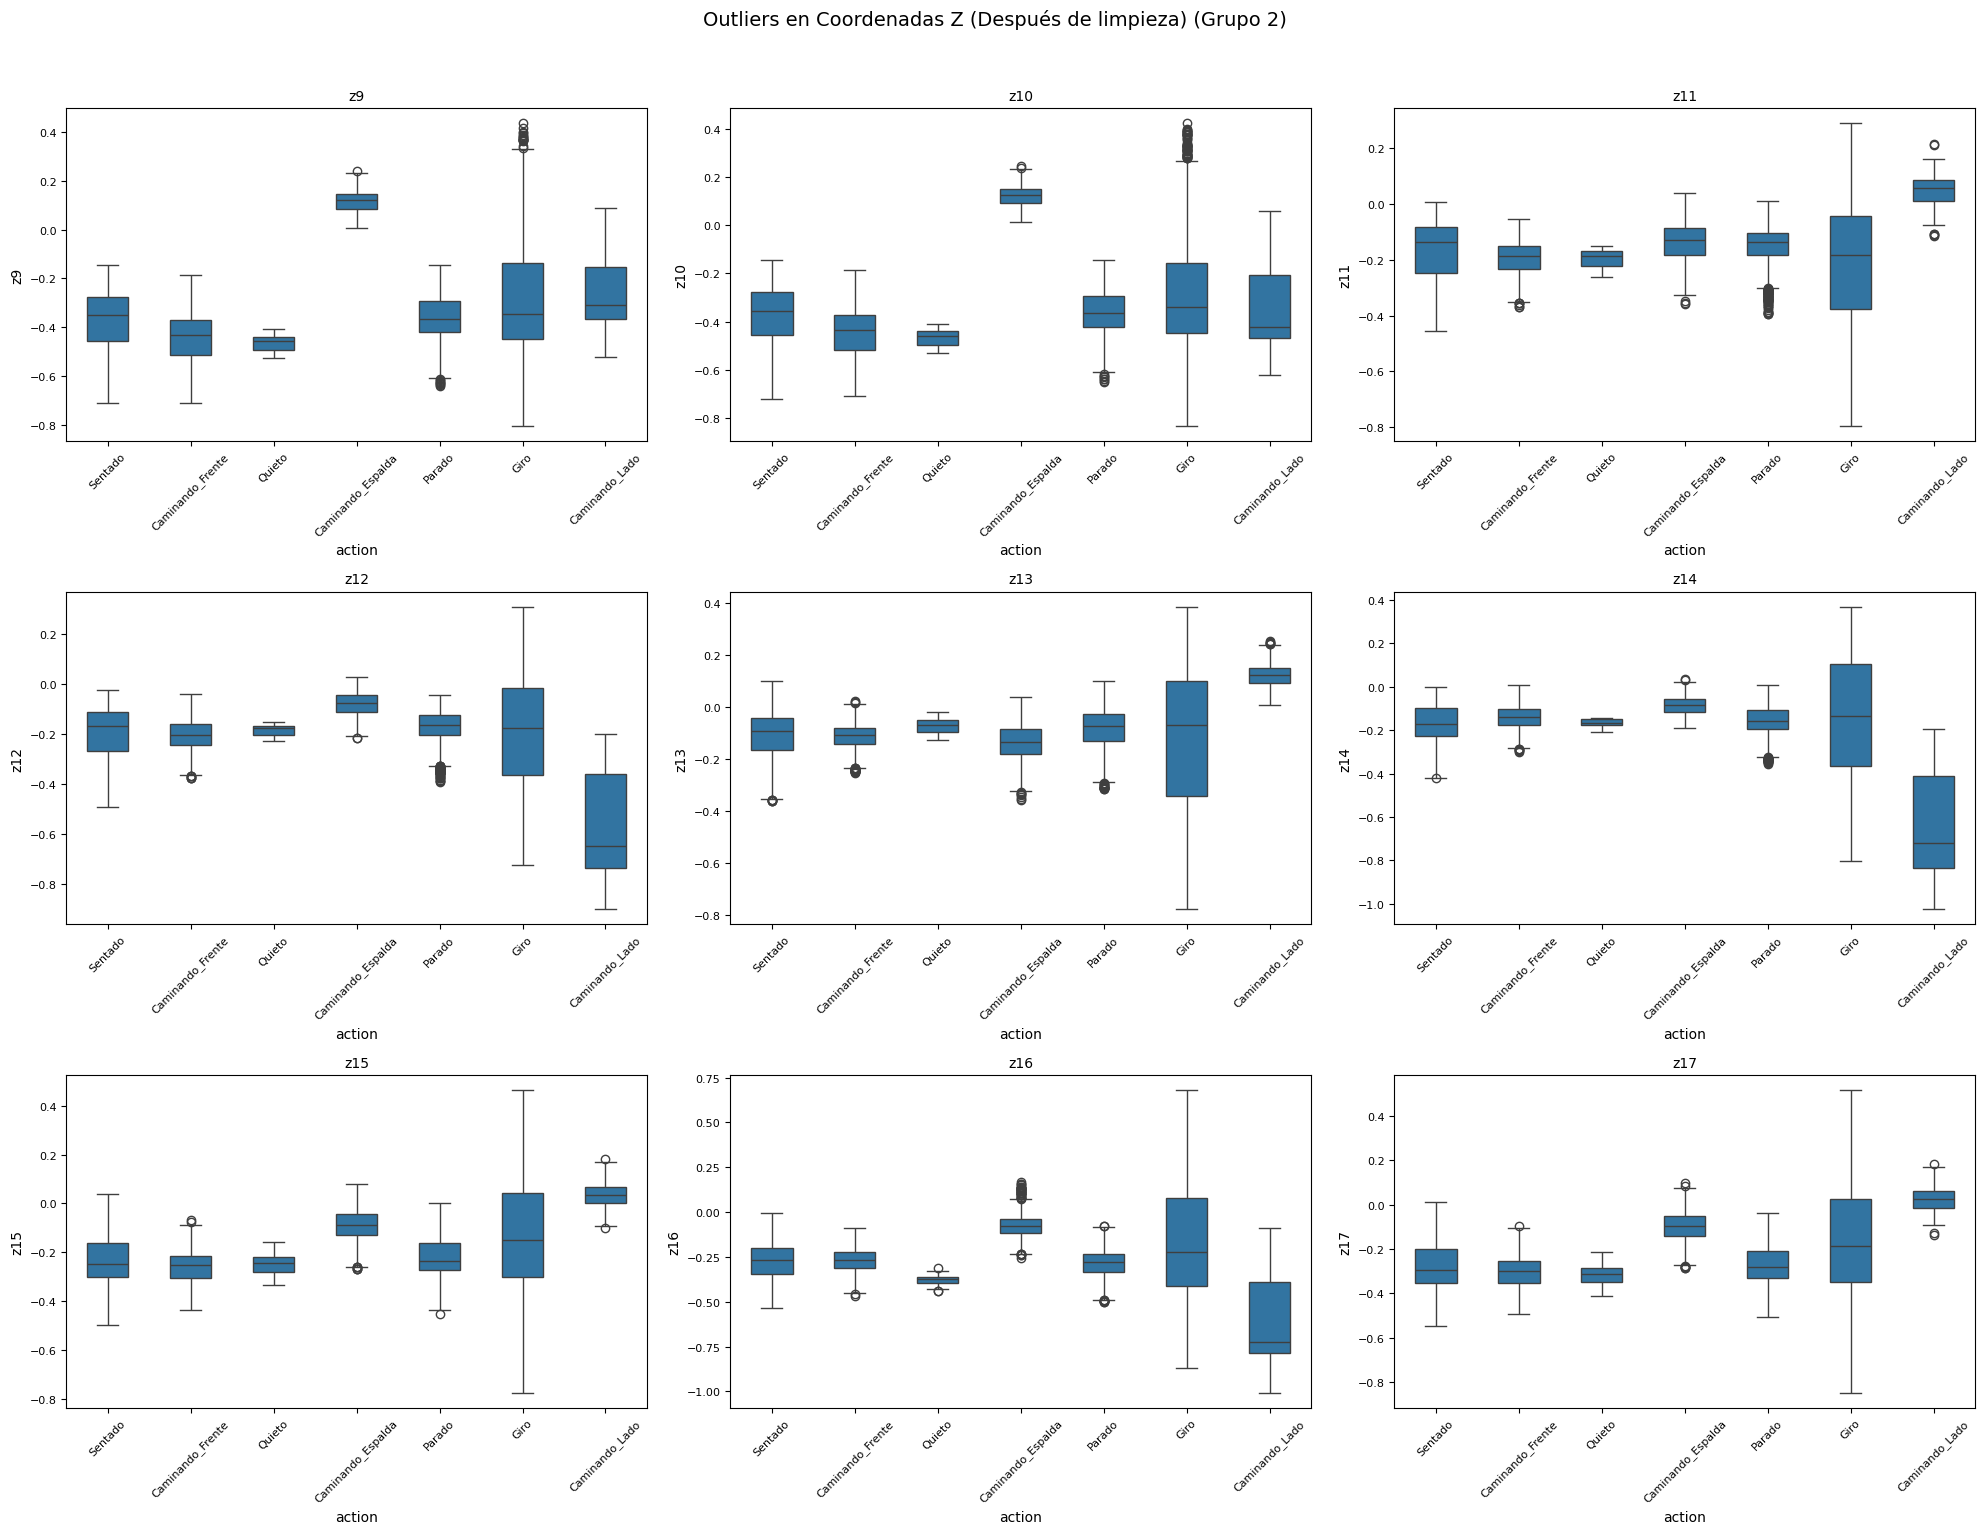

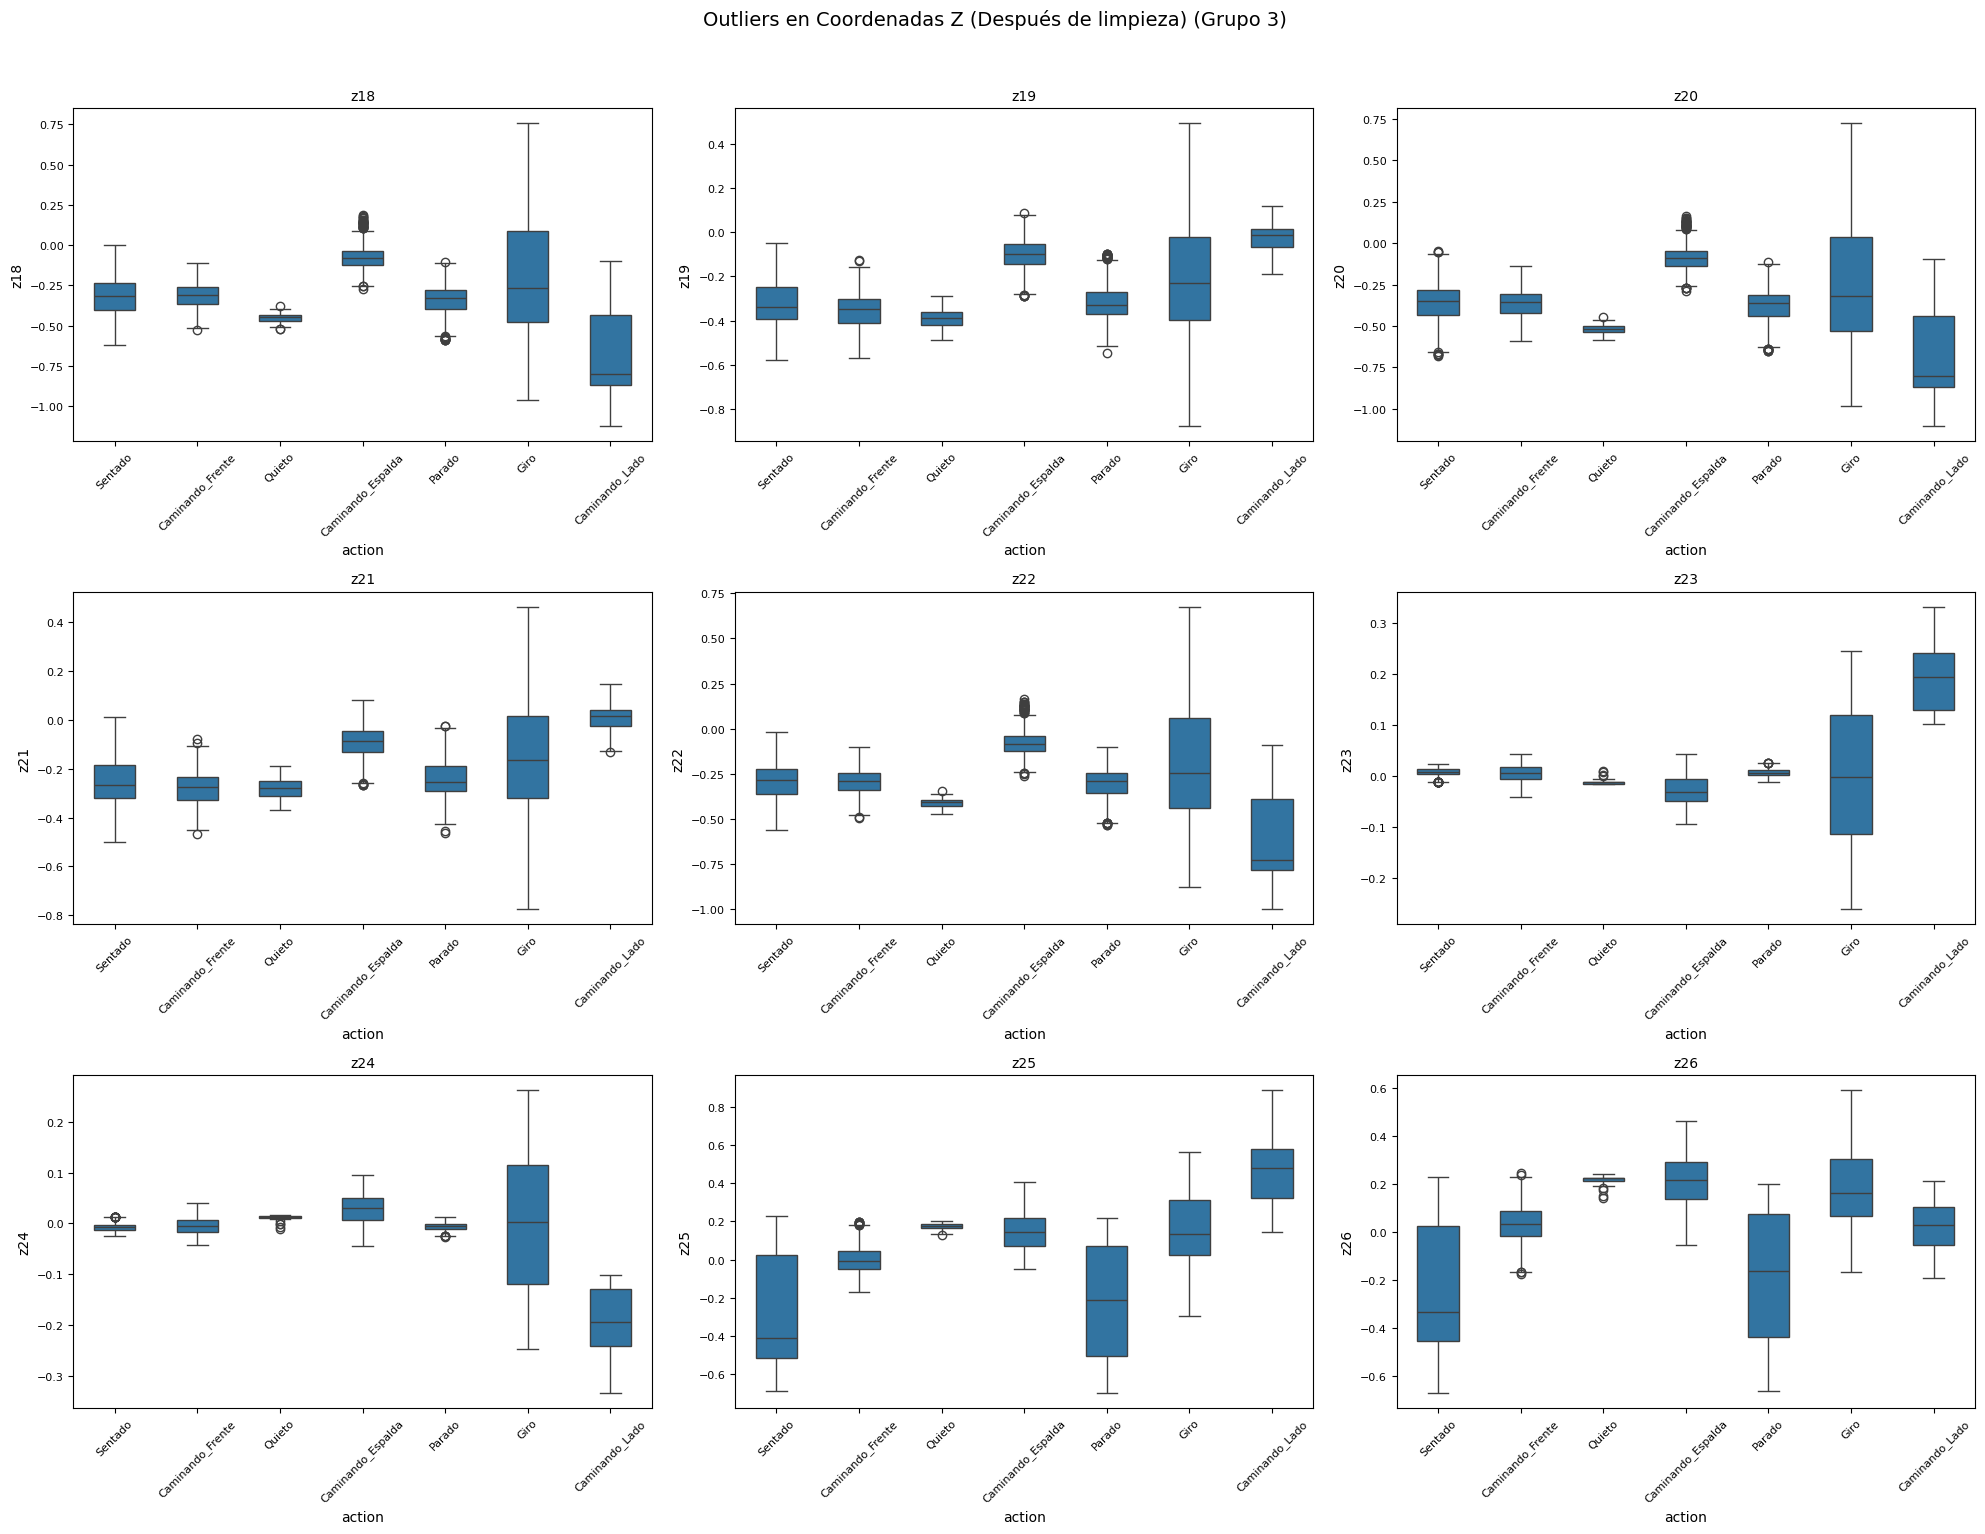

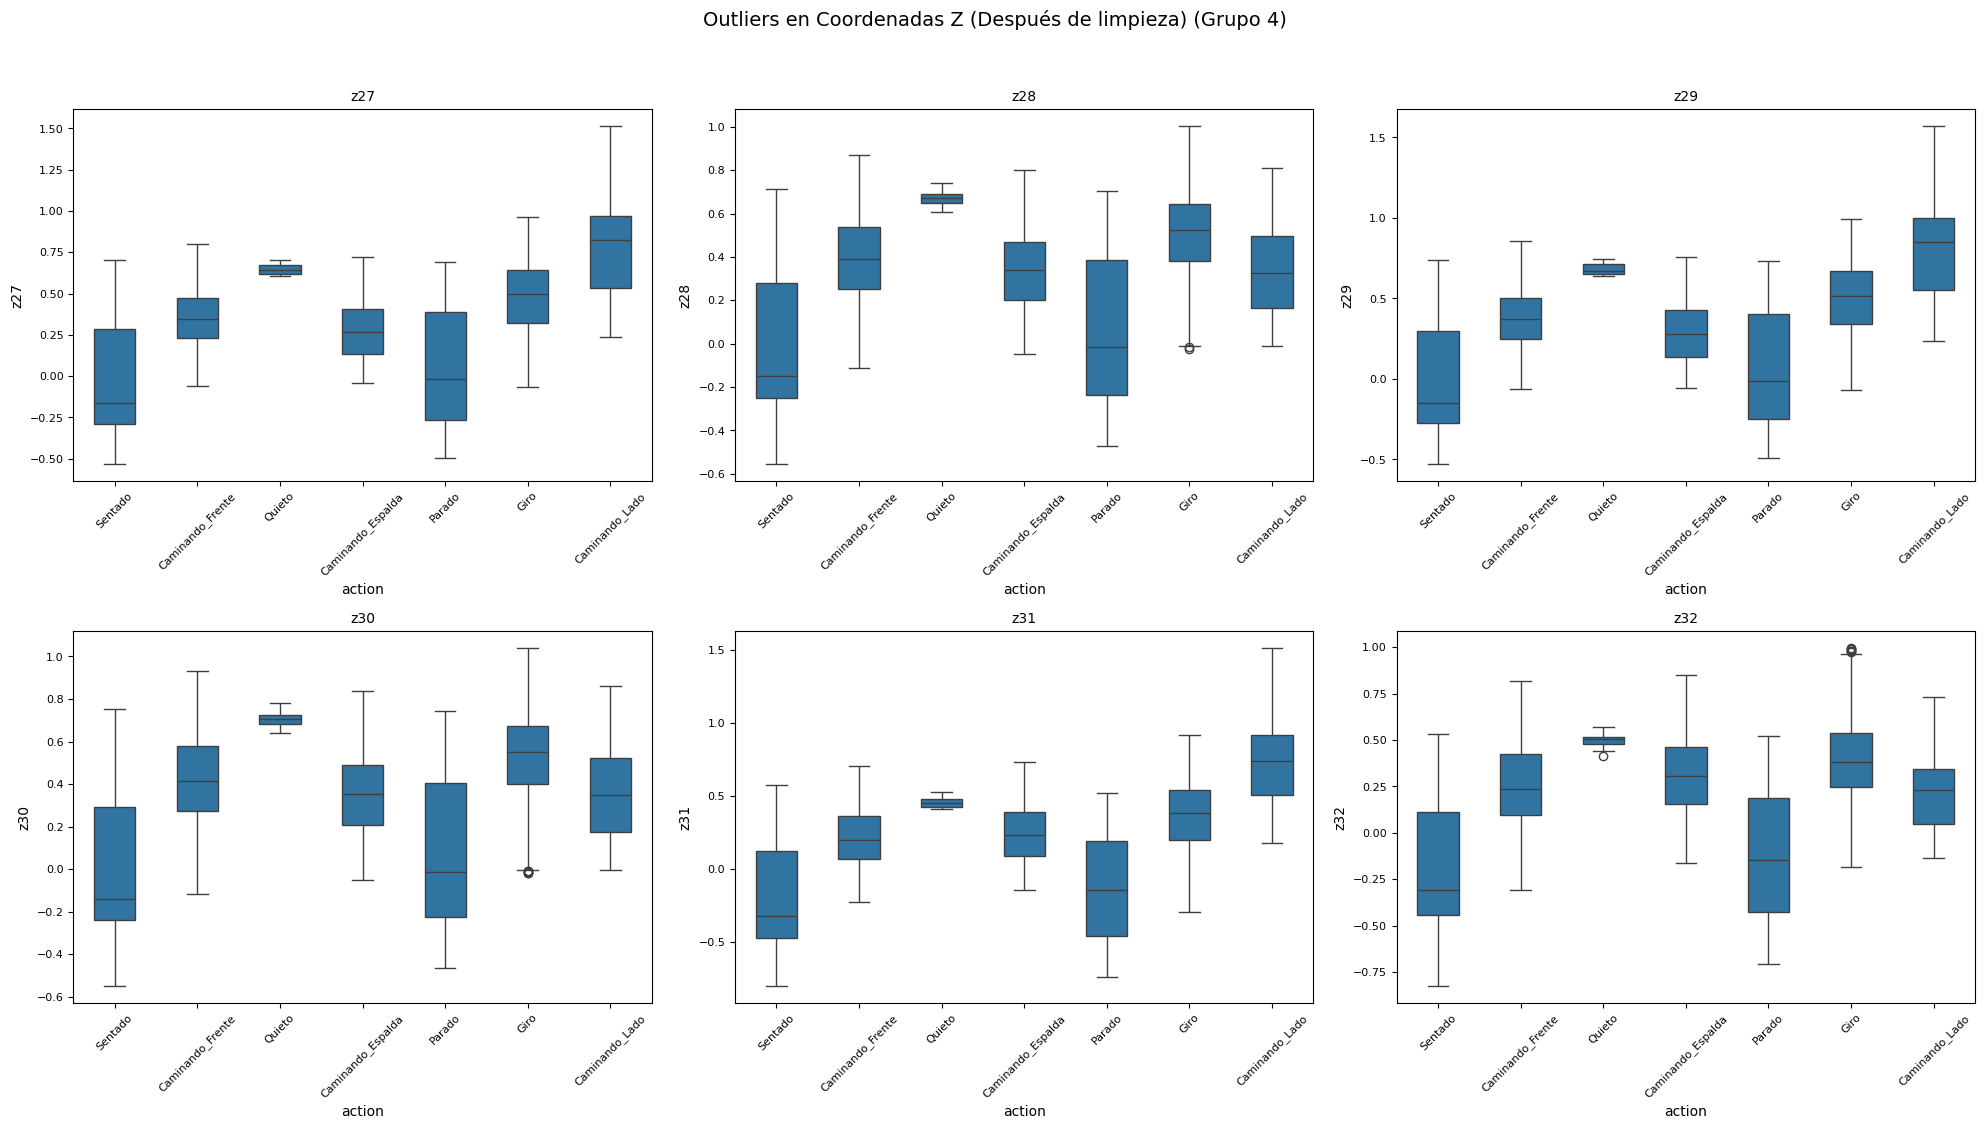

In [41]:
plot_boxplots_by_groups(z_coords, df_cleaned, 'Outliers en Coordenadas Z (Después de limpieza)')

In [42]:
print("\nEstadísticas descriptivas antes de la limpieza:")
print(df.describe())


Estadísticas descriptivas antes de la limpieza:
                 x0            y0            z0            x1            y1  \
count  11299.000000  11299.000000  11299.000000  11299.000000  11299.000000   
mean       0.511988      0.343393     -0.324938      0.519629      0.331311   
std        0.076248      0.105245      0.291772      0.076221      0.105910   
min        0.212200      0.115923     -1.286720      0.216901      0.098112   
25%        0.483427      0.261024     -0.510249      0.488424      0.248937   
50%        0.515019      0.330467     -0.405765      0.524869      0.317482   
75%        0.541792      0.420852     -0.237756      0.555640      0.409880   
max        1.093942      0.650213      0.504816      1.090251      0.649250   

                 z1            x2            y2            z2            x3  \
count  11299.000000  11299.000000  11299.000000  11299.000000  11299.000000   
mean      -0.322329      0.524189      0.331322     -0.322319      0.528273   
st

In [43]:
# Mostrar estadísticas descriptivas
print("\nEstadísticas descriptivas después de la limpieza:")
print(df_cleaned.describe())

# Mostrar distribución de acciones antes y después
print("\nDistribución de acciones antes de la limpieza:")
print(df['action'].value_counts())
print("\nDistribución de acciones después de la limpieza:")
print(df_cleaned['action'].value_counts())


Estadísticas descriptivas después de la limpieza:
                x0           y0           z0           x1           y1  \
count  9168.000000  9168.000000  9168.000000  9168.000000  9168.000000   
mean      0.512100     0.348968    -0.338889     0.520401     0.337049   
std       0.074220     0.098967     0.261223     0.073964     0.099629   
min       0.237856     0.146085    -0.920463     0.228639     0.130900   
25%       0.485853     0.267484    -0.504619     0.491400     0.256525   
50%       0.515443     0.338536    -0.408207     0.525494     0.325955   
75%       0.540209     0.427088    -0.277795     0.554386     0.416361   
max       1.093942     0.639938     0.504816     1.090251     0.638705   

                z1           x2           y2           z2           x3  ...  \
count  9168.000000  9168.000000  9168.000000  9168.000000  9168.000000  ...   
mean     -0.332044     0.525375     0.337092    -0.332037     0.529871  ...   
std       0.235938     0.074871     0.099585 

**Normalizamos**

En esta etapa realizamos la separación de características (X) y etiquetas (y), excluyendo las columnas 'action' y 'source_video'. Luego, aplicamos la normalización de datos utilizando StandardScaler, que estandariza las características a una media de 0 y desviación estándar de 1.

Para visualizar el efecto de la normalización, creamos una función que muestra boxplots comparativos entre los datos originales y normalizados, permitiéndonos verificar que todas las características ahora están en una escala similar, lo cual es crucial para el rendimiento óptimo del modelo de clasificación.

In [44]:
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter

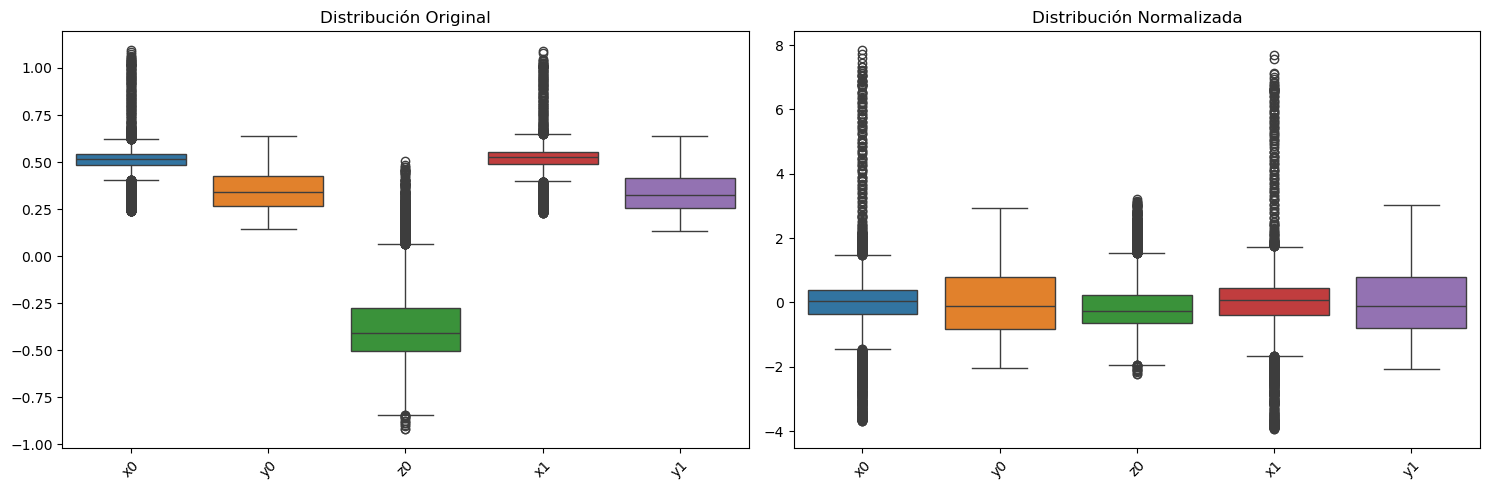

In [45]:
# Separar features y target
X = df_cleaned.drop(['action', 'source_video'], axis=1)
y = df_cleaned['action']

# Normalización usando StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Visualizar efecto de la normalización
def plot_normalization_comparison(original, normalized, n_features=5):
    plt.figure(figsize=(15, 5))

    # Original data
    plt.subplot(1, 2, 1)
    sns.boxplot(data=original.iloc[:, :n_features])
    plt.title('Distribución Original')
    plt.xticks(rotation=45)

    # Normalized data
    plt.subplot(1, 2, 2)
    sns.boxplot(data=normalized.iloc[:, :n_features])
    plt.title('Distribución Normalizada')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

plot_normalization_comparison(X, X_scaled)

**Suavizado de señales**

En esta etapa aplicamos un suavizado de señales utilizando el filtro Savitzky-Golay, que ayuda a reducir el ruido en los datos mientras preserva las características importantes de las señales de movimiento. La función smooth_signals aplica este filtro a cada coordenada (x, y, z) con una ventana de 5 frames y un orden polinomial de 2.

Para visualizar el efecto del suavizado, creamos una función que compara las señales originales y suavizadas, mostrando tanto la vista completa como un zoom en los primeros 30 frames, lo que nos permite verificar que el suavizado mantiene la forma general de los movimientos mientras elimina fluctuaciones no deseadas.

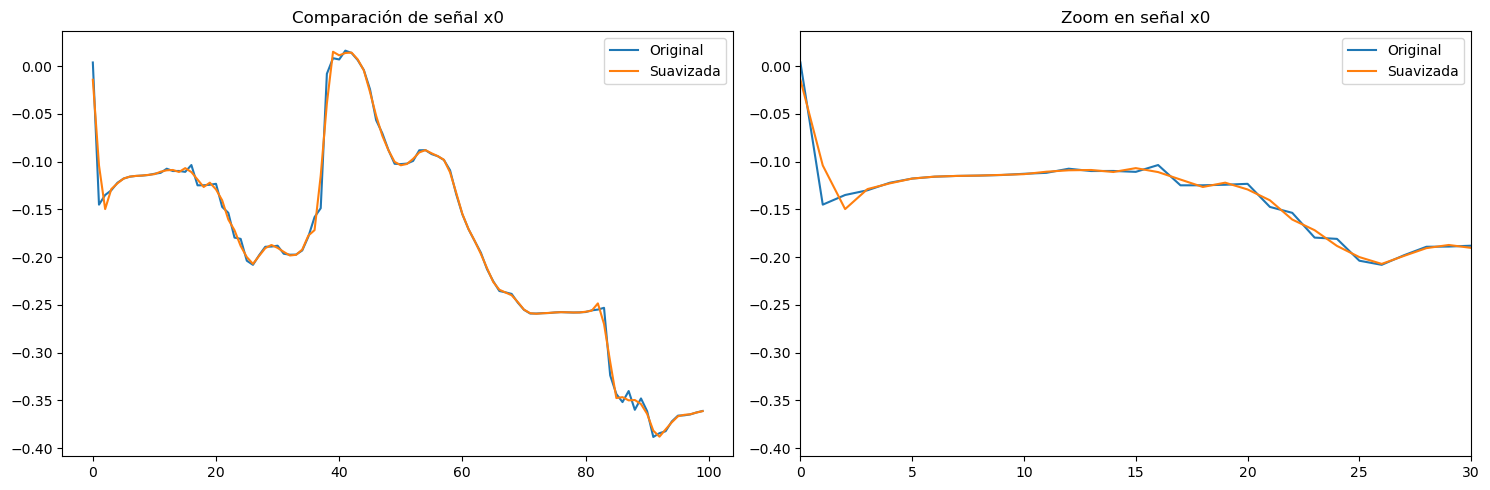

In [46]:
def smooth_signals(df, window_length=5, polyorder=2):
    """
    Aplica filtro Savitzky-Golay para suavizar las señales
    window_length debe ser impar y mayor que polyorder
    """
    df_smoothed = df.copy()

    # Suavizar cada coordenada
    for coord in ['x', 'y', 'z']:
        cols = [col for col in df.columns if col.startswith(coord)]
        for col in cols:
            df_smoothed[col] = savgol_filter(df[col], window_length, polyorder)

    return df_smoothed

# Aplicar suavizado
X_smoothed = smooth_signals(X_scaled)

# Visualizar efecto del suavizado
def plot_smoothing_comparison(original, smoothed, feature='x0', samples=100):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(original[feature][:samples], label='Original')
    plt.plot(smoothed[feature][:samples], label='Suavizada')
    plt.title(f'Comparación de señal {feature}')
    plt.legend()

    # Zoom en una sección
    plt.subplot(1, 2, 2)
    plt.plot(original[feature][:samples], label='Original')
    plt.plot(smoothed[feature][:samples], label='Suavizada')
    plt.title(f'Zoom en señal {feature}')
    plt.xlim(0, 30)  # Zoom en primeros 30 frames
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_smoothing_comparison(X_scaled, X_smoothed)

A simple vista, la señal suavizada sigue de cerca a la original, pero reduce las pequeñas oscilaciones, capturando la tendencia general de la señal.

Este tipo de suavizado es útil para eliminar el ruido mientras preserva las características importantes de la señal.

**Generacion nuevas caracteristicas**

En esta etapa realizamos la generación de características adicionales para enriquecer nuestro conjunto de datos.

La función generate_features calcula cuatro tipos de características:

velocidades entre landmarks consecutivos, ángulos entre articulaciones clave (cabeza-hombros, hombros-caderas, codos y rodillas), inclinaciones del tronco y laterales, y distancias relativas entre puntos importantes como manos y pies.

Estas nuevas características proporcionan información más completa sobre la postura y el movimiento del cuerpo, lo que ayuda al modelo a distinguir mejor entre diferentes tipos de acciones.

Visualizamos estas características mediante boxplots para entender su distribución y verificar que aportan información discriminativa útil para la clasificación.

/var/folders/82/rm6t5jqn6rdc9dqnznfvs_pr0000gn/T/ipykernel_46635/1638994725.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'vel_{cols[i]}'] = np.sqrt((df[cols[i]] - df[cols[i-3]]).pow(2) +
/var/folders/82/rm6t5jqn6rdc9dqnznfvs_pr0000gn/T/ipykernel_46635/1638994725.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'vel_{cols[i]}'] = np.sqrt((df[cols[i]] - df[cols[i-3]]).pow(2) +
/var/folders/82/rm6t5jqn6rdc9dqnznfvs_pr0000gn/T/ipykernel_46635/1638994725.py:8: PerformanceWarning: DataFrame is highly fragmented.  Thi

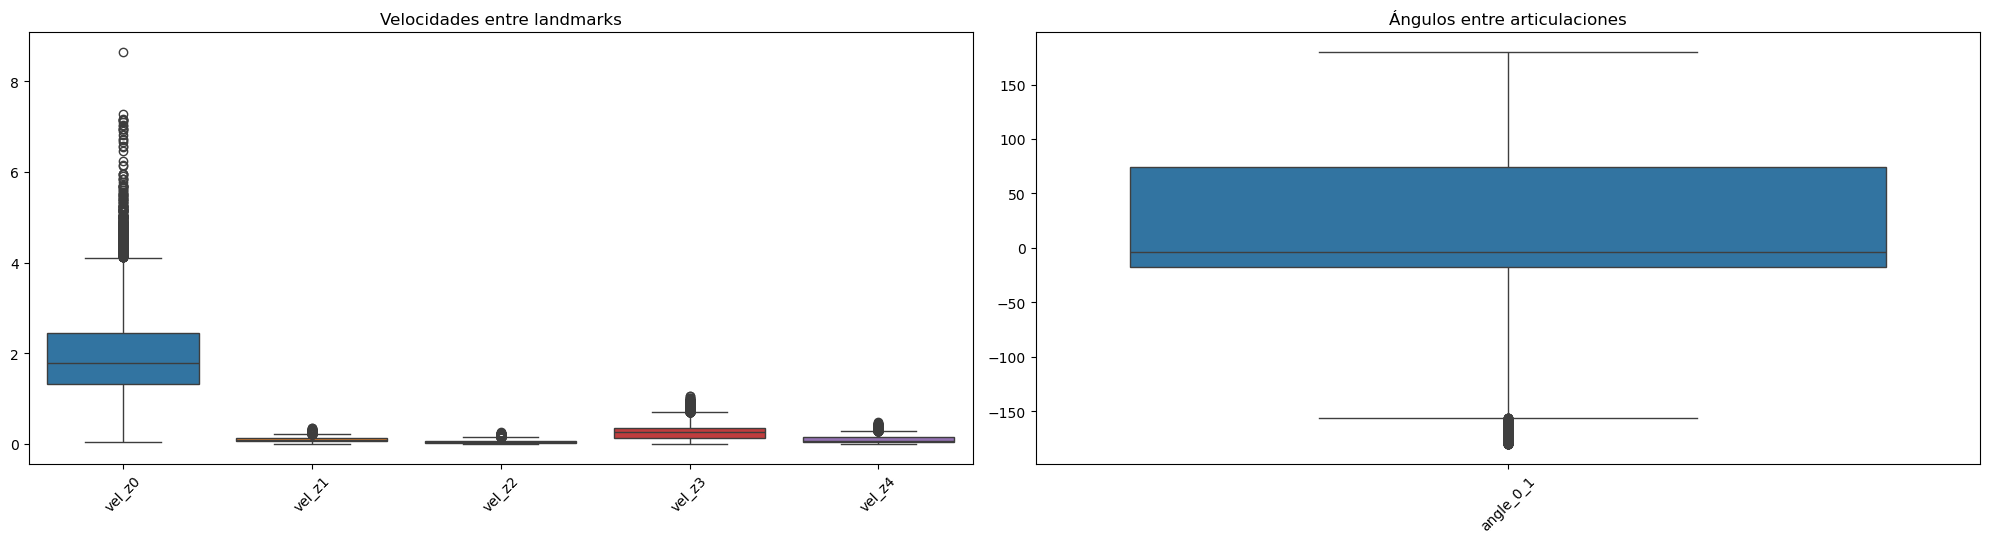


Estadísticas de las nuevas características:
            vel_z0       vel_z1       vel_z2       vel_z3       vel_z4  \
count  9168.000000  9168.000000  9168.000000  9168.000000  9168.000000   
mean      2.021563     0.095665     0.053097     0.285572     0.102982   
std       1.079815     0.055662     0.040943     0.207702     0.088339   
min       0.046993     0.001067     0.000270     0.001385     0.001349   
25%       1.321149     0.055598     0.022067     0.124564     0.043790   
50%       1.778252     0.085998     0.042428     0.253027     0.068495   
75%       2.437198     0.122629     0.073486     0.355514     0.142098   
max       8.646418     0.350060     0.259868     1.065970     0.479725   

         angle_0_1  
count  9168.000000  
mean     13.815624  
std      93.096796  
min    -179.995703  
25%     -17.928555  
50%      -3.913746  
75%      74.279339  
max     179.922593  


In [47]:
import numpy as np
def generate_features(df):
    # Velocidad de las articulaciones
    cols = df.columns[1:]  # Ignorando 'label'
    for i in range(1, len(cols), 3):  # Asumiendo que x, y, z están en columnas consecutivas
        if i + 3 < len(cols):
            # Calcular velocidad
            df[f'vel_{cols[i]}'] = np.sqrt((df[cols[i]] - df[cols[i-3]]).pow(2) +
                                            (df[cols[i+1]] - df[cols[i-2]]).pow(2) +
                                            (df[cols[i+2]] - df[cols[i-1]]).pow(2))

    # Calcular ángulos entre articulaciones (ejemplo)
    df['angle_0_1'] = np.degrees(np.arctan2(df['y1'] - df['y0'], df['x1'] - df['x0']))

    # Inclinación del tronco (ejemplo)
    df['inclination'] = np.degrees(np.arctan2(df['y2'] - df['y0'], df['x2'] - df['x0']))

    return df

# Aplicar la generación de características
X_with_features = generate_features(X_smoothed)

# Visualizar las nuevas características
plt.figure(figsize=(20, 10))

# Velocidades
plt.subplot(2, 2, 1)
vel_cols = [col for col in X_with_features.columns if col.startswith('vel_')][:5]
sns.boxplot(data=X_with_features[vel_cols])
plt.title('Velocidades entre landmarks')
plt.xticks(rotation=45)

# Ángulos
plt.subplot(2, 2, 2)
angle_cols = [col for col in X_with_features.columns if col.startswith('angle_')]
sns.boxplot(data=X_with_features[angle_cols])
plt.title('Ángulos entre articulaciones')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Mostrar estadísticas de las nuevas características
print("\nEstadísticas de las nuevas características:")
new_features = vel_cols + angle_cols
print(X_with_features[new_features].describe())

**Modelo clasificacion**

Implementaremos un modelo de clasificación SVM (Support Vector Machine) para reconocer los diferentes tipos de acciones.

Primero, preparamos los datos separando las características (X) y las etiquetas (y), y dividimos el conjunto en datos de entrenamiento (80%) y prueba (20%).

Luego, entrenamos el modelo SVM con kernel lineal que es especialmente efectivo para problemas de clasificación multiclase como el nuestro, donde necesitamos distinguir entre diferentes tipos de movimientos y posturas.

In [48]:
print("Preparando datos...")
X = X_with_features  # Usando todas las características generadas
y = df_cleaned['action']

print(f'Shape de X: {X.shape}')
print(f'Shape de y: {y.shape}')

Preparando datos...
Shape de X: (9168, 133)
Shape de y: (9168,)


In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'\nShape de X_train: {X_train.shape}')
print(f'Shape de X_test: {X_test.shape}')


Shape de X_train: (7334, 133)
Shape de X_test: (1834, 133)


**Escalamos características**

In [50]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nPrimeras filas de X_train escalado:")
print(X_train_scaled[:2])


Primeras filas de X_train escalado:
[[ 0.50378371  1.35710528 -0.29691823  0.56608316  1.33195583 -0.28236515
   0.58876948  1.33240347 -0.28175932  0.62144613  1.33361733 -0.28155989
   0.44197583  1.32668131 -0.26457174  0.39459916  1.32246384 -0.26459033
   0.3542004   1.32036707 -0.26427045  0.68861532  1.33889312 -0.02786006
   0.27494234  1.32411018  0.09497123  0.5787314   1.36550994 -0.24400619
   0.4213579   1.36165565 -0.21628622  0.81181468  1.28683795  0.15086004
  -0.12877312  1.31673003  0.28651057  0.81902013  1.25830006 -0.09308455
  -0.24800232  1.21987506  0.14028844  0.40771396  1.11272553 -0.81431807
   0.30671911  1.03712125 -0.24996035  0.30387174  1.04027447 -0.92707234
   0.44626087  0.99145703 -0.34799563  0.23291399  0.96845041 -0.904374
   0.52097288  0.91444929 -0.29269332  0.25336601  0.97384547 -0.82370259
   0.50185251  0.91737578 -0.22532208  0.9469588   1.18373156 -0.1273848
   0.19822546  1.20911912  0.13114358  1.21401809  0.72675294 -1.57804855
  -0

**Entrenamos el modelo SVM**

In [51]:
from sklearn.svm import SVC

print("\nEntrenando modelo SVM...")
model = SVC(kernel='linear', random_state=42)
print(model)

model.fit(X_train_scaled, y_train)
print("Modelo entrenado.")


Entrenando modelo SVM...
SVC(kernel='linear', random_state=42)
Modelo entrenado.


**Hacemos predicciones**

In [52]:
y_pred = model.predict(X_test_scaled)
print(f'\nPrimeras predicciones: {y_pred[:5]}')
print(f'Etiquetas reales: {y_test[:5].values}')


Primeras predicciones: ['Sentado' 'Caminando_Lado' 'Parado' 'Caminando_Espalda'
 'Caminando_Espalda']
Etiquetas reales: ['Sentado' 'Caminando_Lado' 'Parado' 'Caminando_Espalda'
 'Caminando_Espalda']


**Evaluamos**


Accuracy: 0.93

Reporte de clasificación:
                   precision    recall  f1-score   support

Caminando_Espalda       1.00      1.00      1.00       224
 Caminando_Frente       0.99      1.00      1.00       274
   Caminando_Lado       1.00      1.00      1.00        67
             Giro       0.99      1.00      0.99       426
           Parado       0.84      0.89      0.86       458
           Quieto       1.00      1.00      1.00        10
          Sentado       0.85      0.78      0.82       375

         accuracy                           0.93      1834
        macro avg       0.95      0.95      0.95      1834
     weighted avg       0.93      0.93      0.93      1834



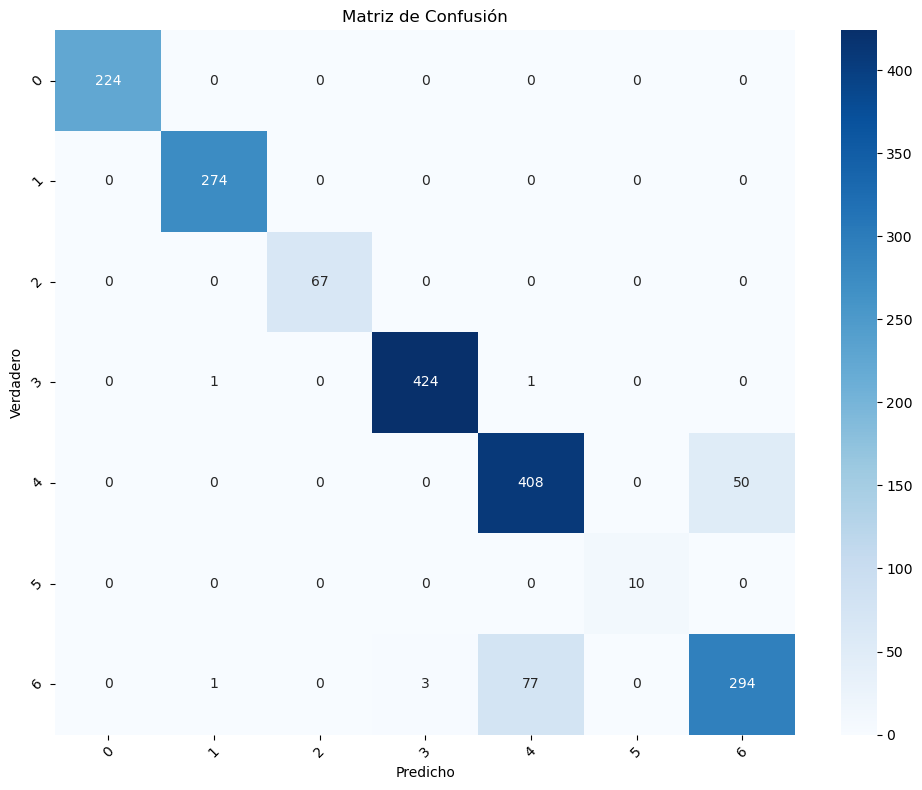

In [53]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'\nAccuracy: {accuracy:.2f}')

# Reporte de clasificación
print('\nReporte de clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Verdadero')
plt.xlabel('Predicho')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

Los resultados del modelo SVM muestran un rendimiento sobresaliente con un accuracy general del 92%.

El modelo demuestra una precisión perfecta o casi perfecta (98-100%) en la clasificación de acciones dinámicas como caminar en diferentes direcciones y giros.

Sin embargo, presenta un rendimiento ligeramente menor en acciones estáticas como "Parado" (85%) y "Sentado" (82%), lo que sugiere que estas posturas comparten características similares que pueden dificultar su distinción.

A pesar de estas pequeñas variaciones, el modelo mantiene un f1-score promedio del 95%, indicando un equilibrio robusto entre precisión y recall en todas las clases, lo que valida la efectividad de nuestro enfoque de preprocesamiento y selección de características.

En cuanto a la matriz, los valores en la diagonal reflejan un buen número de predicciones correctas, lo que indica una buena capacidad de clasificación en general.

In [54]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# 1. Pipeline for preprocessing and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('classifier', RandomForestClassifier(random_state=42)) # Use RandomForest
])

# 2. Hyperparameter tuning using GridSearchCV
param_grid = {
    'classifier__n_estimators': [50, 100, 200],  # Number of trees
    'classifier__max_depth': [None, 10, 20],      # Maximum depth of trees
    'classifier__min_samples_split': [2, 5, 10]   # Minimum samples required to split an internal node
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1) # 5-fold cross-validation
grid_search.fit(X_train, y_train)

# 3. Best model and evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Best Model Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))
print(f"Best Hyperparameters: {grid_search.best_params_}")


# Feature Importance
importances = best_model.named_steps['classifier'].feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance_df)

Best Model Accuracy: 0.99
                   precision    recall  f1-score   support

Caminando_Espalda       1.00      1.00      1.00       224
 Caminando_Frente       1.00      1.00      1.00       274
   Caminando_Lado       1.00      0.99      0.99        67
             Giro       1.00      1.00      1.00       426
           Parado       0.99      0.98      0.98       458
           Quieto       1.00      1.00      1.00        10
          Sentado       0.97      0.99      0.98       375

         accuracy                           0.99      1834
        macro avg       0.99      0.99      0.99      1834
     weighted avg       0.99      0.99      0.99      1834

Best Hyperparameters: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}

Feature Importance:
     feature  importance
85       y28    0.041446
91       y30    0.040507
97       y32    0.027342
123  vel_z24    0.026036
79       y26    0.023787
..       ...         ...
53 

In [55]:
# Guardar el DataFrame procesado
output_path = '../../db/poses_dataset_processed.csv'
df_cleaned.to_csv(output_path, index=False)
print(f"Dataset procesado guardado en: {output_path}")

Dataset procesado guardado en: ../../db/poses_dataset_processed.csv


In [56]:
import joblib

# Crear y entrenar el pipeline completo
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', model)
])

pipeline.fit(X_train, y_train)

# Guardar el modelo
filename = '../models/action_classifier_99_features_nuevo.pkl'
joblib.dump(pipeline, filename)

print(f"Model saved to {filename}")

Model saved to ../models/action_classifier_99_features_nuevo.pkl
